In [1]:
# Import required packages
import pandas as pd    
import numpy as np
from datetime import datetime
import yfinance as yf
from fredapi import Fred
import pandasdmx
from pandasdmx import Request
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import bic, aic
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Part One: US Indices VS. Spread

### 1. US Indices

* SP500
* Russel 1000
* Russel 1000 Value
* Russel 1000 Growth

[*********************100%***********************]  4 of 4 downloaded


R1000   R1000G   R1000V    SP500
Date                                          
2002-09-30   342.06   433.22   420.44   815.28
2002-10-01   355.43   449.66   435.90   847.91
2002-10-02   348.65   438.90   423.27   827.91
2002-10-03   344.95   433.83   417.96   818.95
2002-10-04   337.07   423.77   408.11   800.58
2002-10-07   331.59   415.53   398.79   785.28
2002-10-08   338.91   422.01   402.26   798.55
2002-10-09   331.77   410.52   388.64   776.76
2002-10-10   341.41   425.11   405.20   803.92
2002-10-11   354.08   441.45   421.36   835.32
2002-10-14   358.36   444.90   422.72   841.44
2002-10-15   374.36   465.68   443.41   881.27
2002-10-16   364.16   454.24   433.79   860.02
2002-10-17   372.16   465.12   445.11   879.20
2002-10-18   375.20   467.44   445.82   884.39
2002-10-21   380.38   475.47   455.09   899.72
2002-10-22   375.23   470.19   451.22   890.16
2002-10-23   378.08   473.28   453.70   896.14
2002-10-24   371.72   466.10   447.63   882.50
2002-10-25   379.17   474.23   454.19   897.65
2002-10-28   374.56   470.48   452.65   890.23
2002-10-29   371.50   465.89   447.49   882.15
2002-10-30   374.50   470.73   453.23   890.71
2002-10-31   373.19   468.51   450.51   885.76
2002-11-01   379.35   476.57   458.60   900.96
2002-11-04   382.79   480.31   461.62   908.35
2002-11-05   385.28   483.79   465.31   915.39
2002-11-06   389.63   488.28   468.64   923.76
2002-11-07   382.10   477.13   456.19   902.65
2002-11-08   377.67   472.63   452.94   894.74
...             ...      ...      ...      ...
2019-07-26  1649.92  1677.13  1278.39  3025.86
2019-07-29  1645.11  1673.63  1276.84  3020.97
2019-07-30  1639.50  1670.13  1275.92  3013.18
2019-07-31  1621.49  1652.40  1262.86  2980.38
2019-08-01  1612.74  1636.87  1245.74  2953.56
2019-08-02  1595.62  1623.84  1239.29  2932.05
2019-08-05  1542.90  1575.30  1206.32  2844.74
2019-08-06  1567.20  1595.99  1218.90  2881.77
2019-08-07  1573.91  1597.85  1216.35  2883.98
2019-08-08  1608.27  1628.36  1236.10  2938.09
2019-08-09  1596.45  1616.97  1227.91  2918.65
2019-08-12  1577.96  1597.61  1211.97  2882.70
2019-08-13  1606.22  1619.93  1224.61  2926.32
2019-08-14  1558.01  1572.57  1189.81  2840.60
2019-08-15  1561.55  1575.97  1192.25  2847.60
2019-08-16  1584.18  1599.20  1210.14  2888.68
2019-08-19  1603.98  1617.78  1223.07  2923.65
2019-08-20  1594.49  1605.48  1211.58  2900.51
2019-08-21  1610.89  1618.81  1219.09  2924.43
2019-08-22  1607.49  1617.94  1220.47  2922.95
2019-08-23  1564.47  1576.36  1190.49  2847.11
2019-08-26  1583.69  1592.98  1200.84  2878.38
2019-08-27  1580.29  1587.13  1194.47  2869.16
2019-08-28  1586.80  1597.19  1204.88  2887.94
2019-08-29  1608.81  1617.64  1218.94  2924.58
2019-08-30  1606.70  1618.61  1222.16  2926.46
2019-09-03  1591.32  1606.91  1216.38  2906.27
2019-09-04  1608.40  1624.29  1229.64  2937.78
2019-09-05  1632.74  1645.32  1242.72  2976.00
2019-09-06  1633.46  1646.51  1246.34  2977.84

[4259 rows x 4 columns]

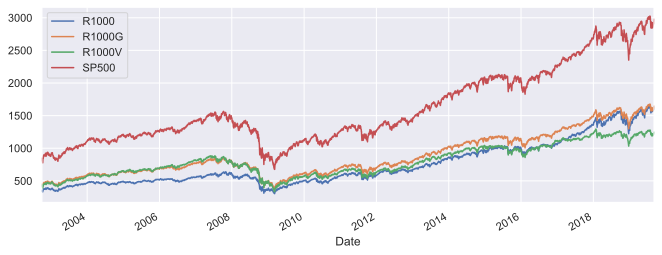

In [2]:
# Download US Indices from Yahoo API
# S&P 500, Russel 1000, R1000V, R1000G
US_Indices = ["^GSPC","^RUI",'^RLV','^RLG']
US_data = yf.download(US_Indices)
Indice_1 = US_data['Adj Close'].dropna()
Indice_1 = Indice_1.rename(columns={'^GSPC':'SP500','^RUI':'R1000G','^RLV':'R1000V','^RLG':'R1000'})
Indice_1 = Indice_1.sort_index(axis=1)
Indice_1
sns.set(rc={'figure.figsize':(11, 4)})
Indice_1.plot()

R1000    R1000G    R1000V     SP500
Date                                              
2002-10-01  0.038342  0.037246  0.036111  0.039243
2002-10-02 -0.019260 -0.024220 -0.029403 -0.023870
2002-10-03 -0.010669 -0.011619 -0.012625 -0.010881
2002-10-04 -0.023109 -0.023462 -0.023849 -0.022687
2002-10-07 -0.016391 -0.019636 -0.023102 -0.019296
2002-10-08  0.021835  0.015474  0.008664  0.016757
2002-10-09 -0.021293 -0.027604 -0.034445 -0.027666
2002-10-10  0.028642  0.034923  0.041727  0.034368
2002-10-11  0.036439  0.037717  0.039107  0.038315
2002-10-14  0.012015  0.007785  0.003222  0.007300
2002-10-15  0.043680  0.045649  0.047785  0.046249
2002-10-16 -0.027625 -0.024873 -0.021934 -0.024408
2002-10-17  0.021731  0.023670  0.025761  0.022057
2002-10-18  0.008135  0.004976  0.001594  0.005886
2002-10-21  0.013712  0.017033  0.020580  0.017185
2002-10-22 -0.013632 -0.011167 -0.008540 -0.010682
2002-10-23  0.007567  0.006550  0.005481  0.006695
2002-10-24 -0.016965 -0.015287 -0.013469 -0.015338
2002-10-25  0.019844  0.017292  0.014549  0.017021
2002-10-28 -0.012233 -0.007939 -0.003396 -0.008300
2002-10-29 -0.008203 -0.009804 -0.011465 -0.009118
2002-10-30  0.008043  0.010335  0.012746  0.009657
2002-10-31 -0.003504 -0.004727 -0.006019 -0.005573
2002-11-01  0.016372  0.017057  0.017798  0.017015
2002-11-04  0.009027  0.007817  0.006564  0.008169
2002-11-05  0.006484  0.007219  0.007962  0.007720
2002-11-06  0.011227  0.009238  0.007131  0.009102
2002-11-07 -0.019515 -0.023100 -0.026925 -0.023117
2002-11-08 -0.011662 -0.009476 -0.007150 -0.008802
2002-11-11 -0.021816 -0.020845 -0.019800 -0.020950
...              ...       ...       ...       ...
2019-07-26  0.010039  0.007613  0.005082  0.007360
2019-07-29 -0.002920 -0.002089 -0.001213 -0.001617
2019-07-30 -0.003416 -0.002093 -0.000721 -0.002582
2019-07-31 -0.011046 -0.010673 -0.010288 -0.010945
2019-08-01 -0.005411 -0.009443 -0.013649 -0.009040
2019-08-02 -0.010672 -0.007992 -0.005191 -0.007309
2019-08-05 -0.033599 -0.030348 -0.026964 -0.030230
2019-08-06  0.015627  0.013049  0.010374  0.012933
2019-08-07  0.004272  0.001165 -0.002094  0.000767
2019-08-08  0.021596  0.018914  0.016107  0.018588
2019-08-09 -0.007377 -0.007019 -0.006648 -0.006639
2019-08-12 -0.011650 -0.012045 -0.013066 -0.012394
2019-08-13  0.017751  0.013874  0.010375  0.015018
2019-08-14 -0.030474 -0.029672 -0.028829 -0.029730
2019-08-15  0.002270  0.002160  0.002049  0.002461
2019-08-16  0.014388  0.014633  0.014894  0.014323
2019-08-19  0.012421  0.011551  0.010628  0.012033
2019-08-20 -0.005934 -0.007632 -0.009439 -0.007946
2019-08-21  0.010233  0.008269  0.006179  0.008213
2019-08-22 -0.002113 -0.000538  0.001131 -0.000506
2019-08-23 -0.027127 -0.026035 -0.024871 -0.026289
2019-08-26  0.012210  0.010488  0.008656  0.010923
2019-08-27 -0.002149 -0.003679 -0.005319 -0.003208
2019-08-28  0.004111  0.006318  0.008677  0.006524
2019-08-29  0.013775  0.012722  0.011602  0.012607
2019-08-30 -0.001312  0.000599  0.002638  0.000643
2019-09-03 -0.009619 -0.007255 -0.004741 -0.006923
2019-09-04  0.010676  0.010758  0.010842  0.010784
2019-09-05  0.015020  0.012864  0.010581  0.012926
2019-09-06  0.000441  0.000723  0.002909  0.000618

[4258 rows x 4 columns]

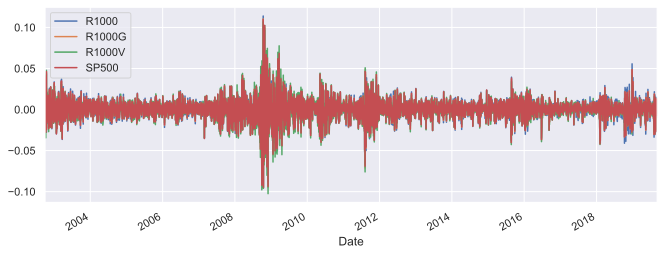

In [3]:
# Take log difference --> Return
TR_1 = np.log(Indice_1).diff().dropna()
TR_1
TR_1.plot()

R1000    R1000G     R1000V     SP500
Date                                               
2002-10-01  8.710151  7.831176   6.907849  8.291442
2002-11-01  5.192548  5.500032   5.822577  5.550058
2002-12-01 -7.291105 -5.998594  -4.650805 -6.222928
2003-01-01 -2.530097 -2.581405  -2.636353 -2.779749
2003-02-01 -0.593941 -1.760957  -2.971919 -1.714984
2003-03-01  1.749153  0.887685  -0.025528  0.832287
2003-04-01  7.076132  7.636873   8.234498  7.792735
2003-05-01  4.777050  5.372610   5.996177  4.964567
2003-06-01  1.251348  1.166838   1.079230  1.125863
2003-07-01  2.402049  1.831130   1.248816  1.609351
2003-08-01  2.361945  1.850221   1.320796  1.771534
2003-09-01 -1.171651 -1.167637  -1.163576 -1.201623
2003-10-01  5.379164  5.548351   5.724132  5.350427
2003-11-01  0.945482  1.027573   1.113868  0.710323
2003-12-01  3.282110  4.513700   5.770335  4.951890
2004-01-01  1.982772  1.775387   1.564719  1.712888
2004-02-01  0.508854  1.210404   1.914144  1.213510
2004-03-01 -1.949273 -1.506607  -1.065646 -1.649422
2004-04-01 -1.214257 -1.939404  -2.657600 -1.693339
2004-05-01  1.738915  1.270972   0.795082  1.201102
2004-06-01  1.137139  1.639801   2.147690  1.782919
2004-07-01 -5.872672 -3.694466  -1.603431 -3.489224
2004-08-01 -0.628061  0.319647   1.204977  0.228472
2004-09-01  0.879950  1.109106   1.319269  0.932034
2004-10-01  1.491633  1.474818   1.458525  1.391696
2004-11-01  3.255415  4.012631   4.706808  3.786878
2004-12-01  3.764679  3.394976   3.057709  3.194249
2005-01-01 -3.443213 -2.646110  -1.924526 -2.561575
2005-02-01  0.929152  2.020492   2.990637  1.872693
2005-03-01 -1.928443 -1.738551  -1.571321 -1.930275
...              ...       ...        ...       ...
2017-04-01  2.181269  0.940558  -0.331047  0.905014
2017-05-01  2.383220  1.033628  -0.384645  1.150972
2017-06-01 -0.377620  0.547824   1.437704  0.480228
2017-07-01  2.555833  1.847336   1.162697  1.916396
2017-08-01  1.633451  0.075963  -1.459676  0.054634
2017-09-01  1.201057  1.972947   2.740088  1.911896
2017-10-01  3.733605  2.162013   0.580499  2.194560
2017-11-01  2.799006  2.763013   2.727175  2.769552
2017-12-01  0.693780  0.975856   1.263428  0.978360
2018-01-01  6.785496  5.248504   3.659400  5.465742
2018-02-01 -2.815429 -3.946459  -5.149210 -3.972612
2018-03-01 -2.890414 -2.451827  -1.980362 -2.725251
2018-04-01  0.280503  0.232515   0.181893  0.271511
2018-05-01  4.114378  2.291228   0.302141  2.137820
2018-06-01  0.861540  0.507924   0.069077  0.483071
2018-07-01  2.842282  3.283340   3.714599  3.538798
2018-08-01  5.162683  3.175230   1.203347  2.981432
2018-09-01  0.473600  0.238122  -0.000802  0.428511
2018-10-01 -9.422744 -7.448538  -5.479570 -7.192935
2018-11-01  0.863638  1.779685   2.665644  1.770178
2018-12-01 -9.086627 -9.719585 -10.337158 -9.626529
2019-01-01  8.555235  7.920548   7.293949  7.574215
2019-02-01  3.335416  3.112511   2.890544  2.929559
2019-03-01  2.703876  1.572581   0.430165  1.776554
2019-04-01  4.367489  3.850449   3.317437  3.856034
2019-05-01 -6.694529 -6.811259  -6.931850 -6.804089
2019-06-01  6.538344  6.636460   6.737567  6.665832
2019-07-01  2.173951  1.425017   0.649843  1.304277
2019-08-01 -0.916309 -2.066102  -3.275920 -1.825731
2019-09-01  1.651808  1.709014   1.959147  1.740470

[204 rows x 4 columns]

R1000     R1000G     R1000V      SP500
Date                                                  
2002-12-31   6.611595   7.332614   8.079621   7.618573
2003-03-31  -1.374886  -3.454677  -5.633799  -3.662446
2003-06-30  13.104530  14.176321  15.309905  13.883164
2003-09-30   3.592342   2.513713   1.406037   2.179262
2003-12-31   9.606756  11.089623  12.608335  11.012639
2004-03-31   0.542353   1.479184   2.413217   1.276976
2004-06-30   1.661797   0.971370   0.285172   1.290682
2004-09-30  -5.620782  -2.265713   0.920815  -2.328718
2004-12-31   8.511727   8.882425   9.223042   8.372823
2005-03-31  -4.442505  -2.364169  -0.505210  -2.619157
2005-06-30   2.163017   1.582307   1.056342   0.905602
2005-09-30   3.676226   3.440562   3.204911   3.097589
2005-12-31   2.635105   1.615822   0.581907   1.572839
2006-03-31   2.751313   3.943750   5.156660   3.663569
2006-06-30  -4.283302  -2.136565  -0.029080  -1.923594
2006-09-30   3.568687   4.476155   5.410221   5.039342
2006-12-31   5.452489   6.242150   7.038615   5.989118
2007-03-31   0.886497   0.761945   0.641161   0.180335
2007-06-30   6.351533   5.296850   4.221783   5.643363
2007-09-30   3.839844   1.505393  -0.878620   1.544534
2007-12-31  -1.069529  -3.774959  -6.676269  -3.899516
2008-03-31 -11.048670 -10.469114  -9.831706 -10.447103
2008-06-30   0.933703  -2.402577  -6.163952  -3.281502
2008-09-30 -13.727079 -10.469396  -7.056615  -9.297229
2008-12-31 -26.152667 -26.113184 -26.075992 -25.564370
2009-03-31  -4.696657 -11.756011 -19.303473 -12.405369
2009-06-30  14.655855  14.685395  14.709237  14.168859
2009-09-30  12.657517  14.383855  16.145749  13.963140
2009-12-31   7.219373   5.377224   3.518908   5.343370
2010-03-31   4.143114   5.062396   6.000635   4.757236
...               ...        ...        ...        ...
2012-06-30  -4.514848  -3.702214  -2.886459  -3.343233
2012-09-30   5.499842   5.586974   5.670836   5.603661
2012-12-31  -1.830770  -0.484960   0.805625  -1.010173
2013-03-31   8.698225   9.900921  11.026745   9.555301
2013-06-30   1.608280   2.105843   2.563863   2.336138
2013-09-30   7.378680   5.337383   3.272577   4.579504
2013-12-31   9.508330   9.231572   8.944777   9.458277
2014-03-31   0.722083   1.546656   2.405058   1.289023
2014-06-30   4.588141   4.500505   4.410898   4.587283
2014-09-30   1.105925   0.167958  -0.790598   0.613349
2014-12-31   4.281382   4.279482   4.275837   4.297656
2015-03-31   3.388179   1.093296  -1.324549   0.435690
2015-06-30  -0.270862  -0.373227  -0.480096  -0.231421
2015-09-30  -5.821708  -7.583660  -9.408404  -7.187374
2015-12-31   6.657105   5.766161   4.823103   6.253851
2016-03-31   0.314474   0.613023   0.932802   0.770044
2016-06-30   0.193185   1.976234   3.839477   1.881458
2016-09-30   4.106749   3.442226   2.776007   3.253527
2016-12-31   0.592135   3.225439   5.811980   3.202379
2017-03-31   8.165719   5.362374   2.607898   5.386009
2017-06-30   4.186869   2.522010   0.722012   2.536214
2017-09-30   5.390341   3.896246   2.443109   3.882926
2017-12-31   7.226391   5.900882   4.571101   5.942472
2018-03-31   1.079652  -1.149781  -3.470172  -1.232121
2018-06-30   5.256420   3.031666   0.553110   2.892403
2018-09-30   8.478565   6.696693   4.917145   6.948741
2018-12-31 -17.645733 -15.388439 -13.151085 -15.049286
2019-03-31  14.594527  12.605640  10.614658  12.280329
2019-06-30   4.211304   3.675650   3.123154   3.717777
2019-09-30   2.909450   1.067929  -0.666930   1.219016

[68 rows x 4 columns]

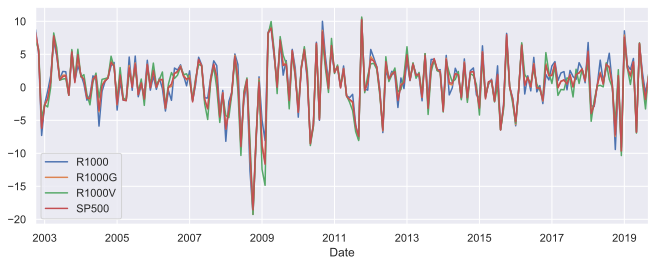

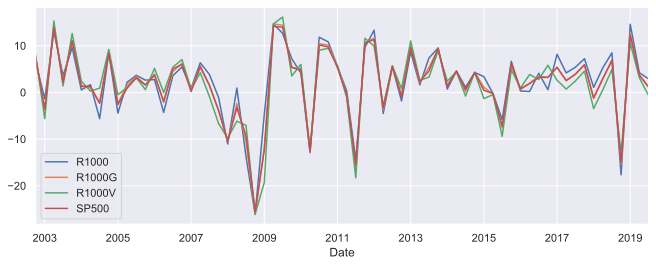

In [4]:
# Calculate Monthly Return
TR_1_M = TR_1.resample('MS').sum()*100
# Calculate Quarterly Return
TR_1_Q = TR_1.resample('Q').sum()*100
TR_1_M
TR_1_M.plot()
TR_1_Q
TR_1_Q.plot()

### 2. Global Indices

* ACWI Net TR USD 
* ACWI ex USA Net TR USD 
* MSCI EAFE Net TR USD

In [5]:
# Monthly Data
ACWI = pd.read_excel('historyIndex_MSCI.xls', skiprows=5,header=1,skipfooter=18)
ACWI = ACWI.set_index('Date')
ACWI_exUSA = pd.read_excel('historyIndex_MSCI ex USA.xls', skiprows=5,header=1,skipfooter=18)
ACWI_exUSA = ACWI_exUSA.set_index('Date')
EAFE = pd.read_excel('historyIndex_MSCI EAFE.xls', skiprows=5,header=1,skipfooter=18)
EAFE = EAFE.set_index('Date')
Indice_2 = pd.concat([ACWI,ACWI_exUSA,EAFE],join='inner',axis=1)
TR_2 = np.log(Indice_2).diff().dropna()

In [6]:
# Change frequency to monthly
TR_2_M = TR_2.resample('MS').sum()*100
# Change frequency to annually
TR_2_Y = TR_2.resample('YS').sum()*100
# Change frequency to quarterly
TR_2_Q = TR_2.resample('Q').sum()*100
TR_2_Y
TR_2_M
TR_2_Q

ACWI Standard (Large+Mid Cap)   \
Date                                         
2001-01-01                      -17.684458   
2002-01-01                      -21.464366   
2003-01-01                       29.257357   
2004-01-01                       14.179215   
2005-01-01                       10.287518   
2006-01-01                       19.024089   
2007-01-01                       11.031275   
2008-01-01                      -54.809543   
2009-01-01                       29.733124   
2010-01-01                       11.929053   
2011-01-01                       -7.631192   
2012-01-01                       14.953370   
2013-01-01                       20.539949   
2014-01-01                        4.076565   
2015-01-01                       -2.392695   
2016-01-01                        7.570407   
2017-01-01                       21.488799   
2018-01-01                       -9.887411   
2019-01-01                       15.329702   

            ACWI ex USA Standard (Large+Mid Cap)   \
Date                                                
2001-01-01                             -21.982407   
2002-01-01                             -16.190498   
2003-01-01                              34.238513   
2004-01-01                              18.984796   
2005-01-01                              15.374012   
2006-01-01                              23.627618   
2007-01-01                              15.402586   
2008-01-01                             -60.743316   
2009-01-01                              34.676458   
2010-01-01                              10.573369   
2011-01-01                             -14.742734   
2012-01-01                              15.555008   
2013-01-01                              14.226317   
2014-01-01                              -3.943401   
2015-01-01                              -5.828665   
2016-01-01                               4.397216   
2017-01-01                              24.052332   
2018-01-01                             -15.309567   
2019-01-01                              11.533149   

            EAFE Standard (Large+Mid Cap)   
Date                                        
2001-01-01                      -24.134144  
2002-01-01                      -17.363962  
2003-01-01                       32.631920  
2004-01-01                       18.437894  
2005-01-01                       12.694596  
2006-01-01                       23.381095  
2007-01-01                       10.588731  
2008-01-01                      -56.878083  
2009-01-01                       27.593434  
2010-01-01                        7.464373  
2011-01-01                      -12.943884  
2012-01-01                       15.970971  
2013-01-01                       20.520782  
2014-01-01                       -5.025907  
2015-01-01                       -0.817497  
2016-01-01                        0.995222  
2017-01-01                       22.341828  
2018-01-01                      -14.838711  
2019-01-01                       11.847265

ACWI Standard (Large+Mid Cap)   \
Date                                         
2001-01-01                        2.482919   
2001-02-01                       -8.809918   
2001-03-01                       -7.007856   
2001-04-01                        6.990809   
2001-05-01                       -1.182203   
2001-06-01                       -3.141000   
2001-07-01                       -1.609420   
2001-08-01                       -4.740498   
2001-09-01                       -9.607513   
2001-10-01                        2.088319   
2001-11-01                        5.940744   
2001-12-01                        0.911157   
2002-01-01                       -2.799256   
2002-02-01                       -0.767562   
2002-03-01                        4.382188   
2002-04-01                       -3.256888   
2002-05-01                        0.077016   
2002-06-01                       -6.335876   
2002-07-01                       -8.782482   
2002-08-01                        0.221500   
2002-09-01                      -11.655342   
2002-10-01                        7.078887   
2002-11-01                        5.291551   
2002-12-01                       -4.918101   
2003-01-01                       -2.987762   
2003-02-01                       -1.810081   
2003-03-01                       -0.432356   
2003-04-01                        8.492717   
2003-05-01                        5.590489   
2003-06-01                        1.855072   
...                                    ...   
2017-02-01                        2.766695   
2017-03-01                        1.215594   
2017-04-01                        1.546672   
2017-05-01                        2.184207   
2017-06-01                        0.453674   
2017-07-01                        2.756147   
2017-08-01                        0.382478   
2017-09-01                        1.913517   
2017-10-01                        2.055302   
2017-11-01                        1.917370   
2017-12-01                        1.599379   
2018-01-01                        5.488059   
2018-02-01                       -4.290440   
2018-03-01                       -2.163771   
2018-04-01                        0.950308   
2018-05-01                        0.124649   
2018-06-01                       -0.542765   
2018-07-01                        2.971184   
2018-08-01                        0.782266   
2018-09-01                        0.434441   
2018-10-01                       -7.789546   
2018-11-01                        1.451930   
2018-12-01                       -7.303726   
2019-01-01                        7.599663   
2019-02-01                        2.639719   
2019-03-01                        1.249418   
2019-04-01                        3.320987   
2019-05-01                       -6.115188   
2019-06-01                        6.342695   
2019-07-01                        0.292410   

            ACWI ex USA Standard (Large+Mid Cap)   \
Date                                                
2001-01-01                               1.482950   
2001-02-01                              -8.251965   
2001-03-01                              -7.379277   
2001-04-01                               6.526041   
2001-05-01                              -2.876030   
2001-06-01                              -3.949976   
2001-07-01                              -2.262334   
2001-08-01                              -2.537509   
2001-09-01                             -11.240150   
2001-10-01                               2.765227   
2001-11-01                               4.464221   
2001-12-01                               1.276394   
2002-01-01                              -4.386808   
2002-02-01                               0.709522   
2002-03-01                               5.244685   
2002-04-01                               0.593082   
2002-05-01                               1.004461   
2002-06-01                              -4.452693   
2002-07-01                             -10.265927   


ACWI Standard (Large+Mid Cap)   \
Date                                         
2001-03-31                      -13.334855   
2001-06-30                        2.667607   
2001-09-30                      -15.957430   
2001-12-31                        8.940221   
2002-03-31                        0.815370   
2002-06-30                       -9.515749   
2002-09-30                      -20.216324   
2002-12-31                        7.452337   
2003-03-31                       -5.230198   
2003-06-30                       15.938278   
2003-09-30                        5.080943   
2003-12-31                       13.468334   
2004-03-31                        2.895347   
2004-06-30                        0.356495   
2004-09-30                       -0.590567   
2004-12-31                       11.517939   
2005-03-31                       -0.965549   
2005-06-30                        0.624869   
2005-09-30                        7.352759   
2005-12-31                        3.275438   
2006-03-31                        6.739712   
2006-06-30                       -0.790954   
2006-09-30                        4.398423   
2006-12-31                        8.676908   
2007-03-31                        2.447419   
2007-06-30                        6.978753   
2007-09-30                        3.413261   
2007-12-31                       -1.808159   
2008-03-31                       -9.741155   
2008-06-30                       -1.588565   
...                                    ...   
2012-06-30                       -5.722842   
2012-09-30                        6.611755   
2012-12-31                        2.841687   
2013-03-31                        6.300209   
2013-06-30                       -0.424475   
2013-09-30                        7.606890   
2013-12-31                        7.057324   
2014-03-31                        1.079102   
2014-06-30                        4.917341   
2014-09-30                       -2.331746   
2014-12-31                        0.411868   
2015-03-31                        2.280291   
2015-06-30                        0.347238   
2015-09-30                       -9.926893   
2015-12-31                        4.906669   
2016-03-31                        0.238177   
2016-06-30                        0.984109   
2016-09-30                        5.165784   
2016-12-31                        1.182337   
2017-03-31                        6.680053   
2017-06-30                        4.184553   
2017-09-30                        5.052142   
2017-12-31                        5.572051   
2018-03-31                       -0.966152   
2018-06-30                        0.532191   
2018-09-30                        4.187891   
2018-12-31                      -13.641342   
2019-03-31                       11.488799   
2019-06-30                        3.548493   
2019-09-30                        0.292410   

            ACWI ex USA Standard (Large+Mid Cap)   \
Date                                                
2001-03-31                             -14.148292   
2001-06-30                              -0.299964   
2001-09-30                             -16.039992   
2001-12-31                               8.505842   
2002-03-31                               1.567399   
2002-06-30                              -2.855151   
2002-09-30                             -21.511794   
2002-12-31                               6.609048   
2003-03-31                              -7.680461   
2003-06-30                              17.879330   
2003-09-30                               8.272741   
2003-12-31                              15.766903   
2004-03-31                               4.645855   
2004-06-30                              -0.899640   
2004-09-30                               0.944311   
2004-12-31                              14.294270   
2005-03-31                               0.249169   
2005-06-30                              -0.244868   
2005-09-30                              11.114006   


### 3. Spread Between US and Global Indices

* SP500-ACWI ex USA

In [7]:
spread1 = TR_1_M.iloc[:,3]-TR_2_M.iloc[:,1]
spread1
spread1 = pd.DataFrame(spread1.dropna(),columns = {'SP500-ACWI ex USA'})
spread1

Date
2001-01-01         NaN
2001-02-01         NaN
2001-03-01         NaN
2001-04-01         NaN
2001-05-01         NaN
2001-06-01         NaN
2001-07-01         NaN
2001-08-01         NaN
2001-09-01         NaN
2001-10-01         NaN
2001-11-01         NaN
2001-12-01         NaN
2002-01-01         NaN
2002-02-01         NaN
2002-03-01         NaN
2002-04-01         NaN
2002-05-01         NaN
2002-06-01         NaN
2002-07-01         NaN
2002-08-01         NaN
2002-09-01         NaN
2002-10-01    3.073344
2002-11-01    0.865385
2002-12-01   -2.929204
2003-01-01    0.803645
2003-02-01    0.351309
2003-03-01    2.863060
2003-04-01   -1.315927
2003-05-01   -1.130339
2003-06-01   -1.549900
                ...   
2017-04-01   -1.212849
2017-05-01   -2.042723
2017-06-01    0.170341
2017-07-01   -1.703286
2017-08-01   -0.467001
2017-09-01    0.072564
2017-10-01    0.330533
2017-11-01    1.960533
2017-12-01   -1.232209
2018-01-01    0.045902
2018-02-01    0.857244
2018-03-01   -0.945594
2018-0

SP500-ACWI ex USA
Date                         
2002-10-01           3.073344
2002-11-01           0.865385
2002-12-01          -2.929204
2003-01-01           0.803645
2003-02-01           0.351309
2003-03-01           2.863060
2003-04-01          -1.315927
2003-05-01          -1.130339
2003-06-01          -1.549900
2003-07-01          -1.003121
2003-08-01          -1.146842
2003-09-01          -3.943516
2003-10-01          -0.923415
2003-11-01          -1.431610
2003-12-01          -2.399238
2004-01-01           0.134022
2004-02-01          -1.278922
2004-03-01          -2.223979
2004-04-01           1.539649
2004-05-01           0.972669
2004-06-01          -0.321996
2004-07-01          -0.511821
2004-08-01          -0.543693
2004-09-01          -2.217515
2004-10-01          -2.021052
2004-11-01          -2.898286
2004-12-01          -1.002109
2005-01-01          -0.809420
2005-02-01          -2.916108
2005-03-01           0.857202
...                       ...
2017-02-01           2.070558
2017-03-01          -2.542670
2017-04-01          -1.212849
2017-05-01          -2.042723
2017-06-01           0.170341
2017-07-01          -1.703286
2017-08-01          -0.467001
2017-09-01           0.072564
2017-10-01           0.330533
2017-11-01           1.960533
2017-12-01          -1.232209
2018-01-01           0.045902
2018-02-01           0.857244
2018-03-01          -0.945594
2018-04-01          -1.312700
2018-05-01           4.473996
2018-06-01           2.380531
2018-07-01           1.175291
2018-08-01           5.096612
2018-09-01          -0.025948
2018-10-01           1.290743
2018-11-01           0.828146
2018-12-01          -4.994920
2019-01-01           0.290283
2019-02-01           0.994662
2019-03-01           1.182602
2019-04-01           1.248543
2019-05-01          -1.287370
2019-06-01           0.818567
2019-07-01           2.521947

[202 rows x 1 columns]

* SP500-EAFE

In [8]:
spread2 = TR_1_M.iloc[:,3]-TR_2_M.iloc[:,2]
spread2
spread2 = pd.DataFrame(spread2.dropna(),columns = {'SP500-EAFE'})
spread2

Date
2001-01-01         NaN
2001-02-01         NaN
2001-03-01         NaN
2001-04-01         NaN
2001-05-01         NaN
2001-06-01         NaN
2001-07-01         NaN
2001-08-01         NaN
2001-09-01         NaN
2001-10-01         NaN
2001-11-01         NaN
2001-12-01         NaN
2002-01-01         NaN
2002-02-01         NaN
2002-03-01         NaN
2002-04-01         NaN
2002-05-01         NaN
2002-06-01         NaN
2002-07-01         NaN
2002-08-01         NaN
2002-09-01         NaN
2002-10-01    3.056363
2002-11-01    1.111491
2002-12-01   -2.802643
2003-01-01    1.484666
2003-02-01    0.606749
2003-03-01    2.816638
2003-04-01   -1.557381
2003-05-01   -0.918217
2003-06-01   -1.262002
                ...   
2017-04-01   -1.607647
2017-05-01   -2.453668
2017-06-01    0.657243
2017-07-01   -0.927366
2017-08-01    0.092321
2017-09-01   -0.545699
2017-10-01    0.687503
2017-11-01    1.726092
2017-12-01   -0.614011
2018-01-01    0.571539
2018-02-01    0.646025
2018-03-01   -0.906450
2018-0

SP500-EAFE
Date                  
2002-10-01    3.056363
2002-11-01    1.111491
2002-12-01   -2.802643
2003-01-01    1.484666
2003-02-01    0.606749
2003-03-01    2.816638
2003-04-01   -1.557381
2003-05-01   -0.918217
2003-06-01   -1.262002
2003-07-01   -0.782466
2003-08-01   -0.614686
2003-09-01   -4.237714
2003-10-01   -0.695939
2003-11-01   -1.488539
2003-12-01   -2.570411
2004-01-01    0.308726
2004-02-01   -1.068684
2004-03-01   -2.210518
2004-04-01    0.594733
2004-05-01    0.865415
2004-06-01   -0.384448
2004-07-01   -0.190041
2004-08-01   -0.212167
2004-09-01   -1.647963
2004-10-01   -1.961425
2004-11-01   -2.821222
2004-12-01   -1.098537
2005-01-01   -0.709824
2005-02-01   -2.357492
2005-03-01    0.614029
...                ...
2017-02-01    2.232490
2017-03-01   -2.754588
2017-04-01   -1.607647
2017-05-01   -2.453668
2017-06-01    0.657243
2017-07-01   -0.927366
2017-08-01    0.092321
2017-09-01   -0.545699
2017-10-01    0.687503
2017-11-01    1.726092
2017-12-01   -0.614011
2018-01-01    0.571539
2018-02-01    0.646025
2018-03-01   -0.906450
2018-04-01   -1.986079
2018-05-01    4.411265
2018-06-01    1.712320
2018-07-01    1.107076
2018-08-01    4.931576
2018-09-01   -0.435625
2018-10-01    1.100899
2018-11-01    1.896268
2018-12-01   -4.650366
2019-01-01    1.209142
2019-02-01    0.412375
2019-03-01    1.147955
2019-04-01    1.083302
2019-05-01   -1.882346
2019-06-01    0.902598
2019-07-01    2.582091

[202 rows x 1 columns]

In [9]:
spread = pd.concat([spread1,spread2],join='inner',axis=1)
spread

SP500-ACWI ex USA  SP500-EAFE
Date                                     
2002-10-01           3.073344    3.056363
2002-11-01           0.865385    1.111491
2002-12-01          -2.929204   -2.802643
2003-01-01           0.803645    1.484666
2003-02-01           0.351309    0.606749
2003-03-01           2.863060    2.816638
2003-04-01          -1.315927   -1.557381
2003-05-01          -1.130339   -0.918217
2003-06-01          -1.549900   -1.262002
2003-07-01          -1.003121   -0.782466
2003-08-01          -1.146842   -0.614686
2003-09-01          -3.943516   -4.237714
2003-10-01          -0.923415   -0.695939
2003-11-01          -1.431610   -1.488539
2003-12-01          -2.399238   -2.570411
2004-01-01           0.134022    0.308726
2004-02-01          -1.278922   -1.068684
2004-03-01          -2.223979   -2.210518
2004-04-01           1.539649    0.594733
2004-05-01           0.972669    0.865415
2004-06-01          -0.321996   -0.384448
2004-07-01          -0.511821   -0.190041
2004-08-01          -0.543693   -0.212167
2004-09-01          -2.217515   -1.647963
2004-10-01          -2.021052   -1.961425
2004-11-01          -2.898286   -2.821222
2004-12-01          -1.002109   -1.098537
2005-01-01          -0.809420   -0.709824
2005-02-01          -2.916108   -2.357492
2005-03-01           0.857202    0.614029
...                       ...         ...
2017-02-01           2.070558    2.232490
2017-03-01          -2.542670   -2.754588
2017-04-01          -1.212849   -1.607647
2017-05-01          -2.042723   -2.453668
2017-06-01           0.170341    0.657243
2017-07-01          -1.703286   -0.927366
2017-08-01          -0.467001    0.092321
2017-09-01           0.072564   -0.545699
2017-10-01           0.330533    0.687503
2017-11-01           1.960533    1.726092
2017-12-01          -1.232209   -0.614011
2018-01-01           0.045902    0.571539
2018-02-01           0.857244    0.646025
2018-03-01          -0.945594   -0.906450
2018-04-01          -1.312700   -1.986079
2018-05-01           4.473996    4.411265
2018-06-01           2.380531    1.712320
2018-07-01           1.175291    1.107076
2018-08-01           5.096612    4.931576
2018-09-01          -0.025948   -0.435625
2018-10-01           1.290743    1.100899
2018-11-01           0.828146    1.896268
2018-12-01          -4.994920   -4.650366
2019-01-01           0.290283    1.209142
2019-02-01           0.994662    0.412375
2019-03-01           1.182602    1.147955
2019-04-01           1.248543    1.083302
2019-05-01          -1.287370   -1.882346
2019-06-01           0.818567    0.902598
2019-07-01           2.521947    2.582091

[202 rows x 2 columns]

### 4. US Indicators

### 4.1 Leading Indicators

* Manufacturers' New Orders: Durable Goods (DGORDER)
* Consumer Opinion Surveys: Confidence Indicators: Composite Indicators: OECD Indicator for the United States (CSCICP03USM665S)
* New Private Housing Units Authorized by Building Permits (PERMIT)
* 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity (T10Y3M)
* Initial Claims (ICSA)
* Average Weekly Hours of All Employees: Manufacturing (AWHAEMAN)

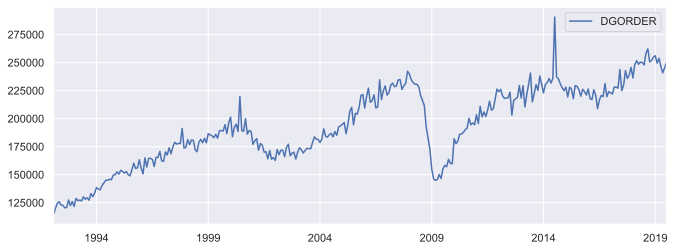

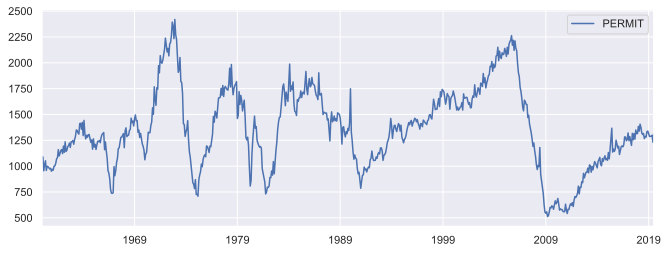

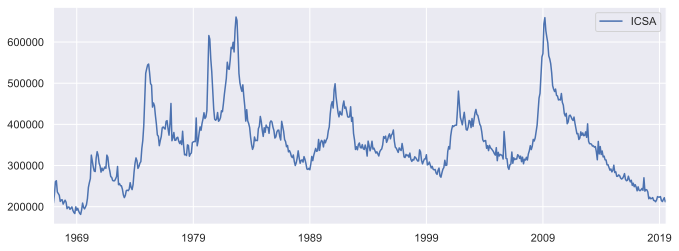

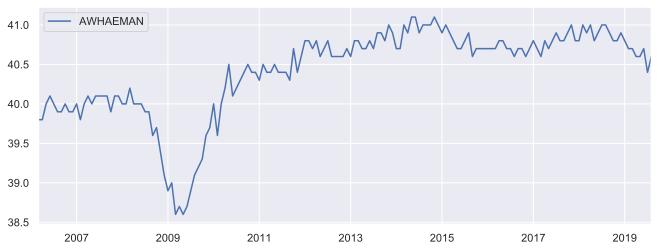

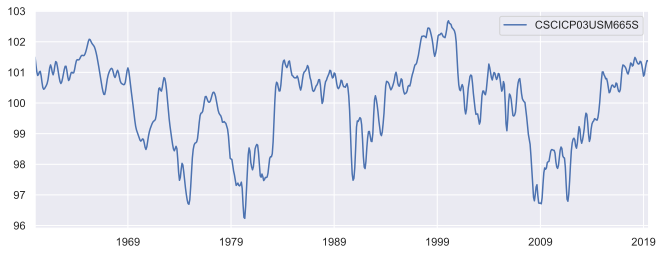

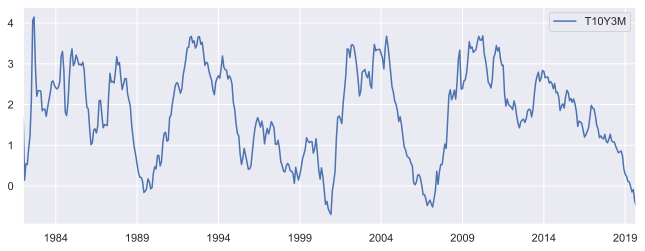

In [10]:
# Get Indicators Data through Fred API
fred = Fred(api_key='c61f0bb859e22e163419d6e5cf28655b')
leading_fred = ['DGORDER','PERMIT','ICSA','AWHAEMAN','CSCICP03USM665S','T10Y3M']
leading_df = {}
for i in range(0,len(leading_fred)):
    data = fred.get_series(leading_fred[i]).dropna()
    data_series = pd.DataFrame(data,columns=[leading_fred[i]])
    data_series = data_series.resample('MS').mean().dropna()
    data_series.plot()
    leading_df[leading_fred[i]] = data_series

In [11]:
# Seasonally Adjusted
for i in range(0,len(leading_fred)):
    leading_df[leading_fred[i]] = leading_df[leading_fred[i]].diff(periods=12).dropna()

# Merge all Indicators and TRs
def Merge(df,fred):
    merge = df[fred[0]]
    for i in range(0,len(fred)-1):
        merge = pd.concat([merge,df[fred[i+1]]],join='inner',axis=1)
    merge1 = pd.concat([spread,merge],join='inner',axis=1)
    merge1 = merge1.dropna()
    
    return merge1
merge1 = Merge(leading_df,leading_fred)
merge1

SP500-ACWI ex USA  SP500-EAFE  DGORDER  PERMIT      ICSA  \
Date                                                                   
2007-03-01          -1.740222   -1.524034   2714.0  -522.0    7650.0   
2007-04-01          -0.222178   -0.109518  17002.0  -528.0   16650.0   
2007-05-01           0.608456    1.465859  12732.0  -412.0  -28500.0   
2007-06-01          -2.610464   -1.919796   7841.0  -460.0    9700.0   
2007-07-01          -2.946955   -1.766716  25082.0  -402.0   -5550.0   
2007-08-01           2.852950    2.853200  24360.0  -401.0    5750.0   
2007-09-01          -2.877160   -1.694970  -8672.0  -394.0   -2800.0   
2007-10-01          -3.948966   -2.382502  12335.0  -378.0   12750.0   
2007-11-01           0.117234   -1.160651   6579.0  -311.0    9750.0   
2007-12-01           0.598555    1.409875  13107.0  -489.0   24200.0   
2008-01-01           3.882394    3.381393  18638.0  -532.0   21500.0   
2008-02-01          -6.362737   -4.960504  11501.0  -584.0   24000.0   
2008-03-01           1.623993    0.460014   2338.0  -629.0   54000.0   
2008-04-01          -1.231639   -0.640522   -965.0  -462.0   39250.0   
2008-05-01          -0.509944    0.092691   2129.0  -498.0   62550.0   
2008-06-01          -0.411932   -0.455658   -619.0  -227.0   68050.0   
2008-07-01           2.676590    2.271320 -13766.0  -440.0   84750.0   
2008-08-01           6.004625    5.348432 -18491.0  -463.0  113000.0   
2008-09-01           6.758688    6.099355 -14337.0  -464.0  150600.0   
2008-10-01           6.306709    3.973842 -36599.0  -456.0  147000.0   
2008-11-01          -1.821658   -2.223221 -48601.0  -598.0  183800.0   
2008-12-01          -4.761977   -5.059264 -69663.0  -595.0  215800.0   
2009-01-01           0.297779    1.373812 -84653.0  -549.0  233250.0   
2009-02-01          -1.848649   -0.821050 -88425.0  -456.0  297250.0   
2009-03-01           0.474776    2.050390 -87374.0  -454.0  295850.0   
2009-04-01          -3.797985   -3.070986 -85049.0  -487.0  268250.0   
2009-05-01          -7.525203   -6.009452 -80598.0  -439.0  245200.0   
2009-06-01           1.126926    0.589956 -81856.0  -579.0  215000.0   
2009-07-01          -2.176527   -1.584875 -65597.0  -326.0  168500.0   
2009-08-01          -0.333319   -1.992315 -58076.0  -242.0  126200.0   
...                       ...         ...      ...     ...       ...   
2017-02-01           2.070558    2.232490   4141.0    55.0  -28000.0   
2017-03-01          -2.542670   -2.754588  11327.0   173.0  -14750.0   
2017-04-01          -1.212849   -1.607647   2289.0    93.0  -24000.0   
2017-05-01          -2.042723   -2.453668   6350.0    13.0  -35250.0   
2017-06-01           0.170341    0.657243  34839.0   121.0  -24750.0   
2017-07-01          -1.703286   -0.927366   8251.0    68.0  -16000.0   
2017-08-01          -0.467001    0.092321   9252.0   108.0  -24500.0   
2017-09-01           0.072564   -0.545699  23082.0   -22.0   18450.0   
2017-10-01           0.330533    0.687503   4553.0    68.0  -19250.0   
2017-11-01           1.960533    1.726092  19402.0    68.0   -7000.0   
2017-12-01          -1.232209   -0.614011  21647.0    58.0  -12600.0   
2018-01-01           0.045902    0.571539  13319.0    63.0  -12000.0   
2018-02-01           0.857244    0.646025  26307.0    92.0  -19250.0   
2018-03-01          -0.945594   -0.906450  23443.0   120.0  -25450.0   
2018-04-01          -1.312700   -1.986079  20423.0   131.0  -20750.0   
2018-05-01           4.473996    4.411265  23188.0   120.0  -18750.0   
2018-06-01           2.380531    1.712320   6234.0   -11.0  -19000.0   
2018-07-01           1.175291    1.107076  22910.0    61.0  -28950.0   
2018-08-01           5.096612    4.931576  28466.0   -48.0  -25000.0   
2018-09-01          -0.025948   -0.435625  19387.0    27.0  -58200.0   
2018-10-01           1.290743    1.100899  14696.0   -68.0  -21750.0   
2018-11-01           0.828146    1.896268  12955.0    20.0  -17000.0   
2018-12-01          -4.994920   -4.650366   9046.0  

In [12]:
# ADF Test: test whether the series is stationary or not, take the difference if not stationary
# drop the indicator if not stationary after taking difference three times
def ADF_Test(df_diff):
    index_remove2 = []
    for i in range(2,df_diff.shape[1]):
        k = 0
        for j in range(0,3):
            pValue = ts.adfuller(df_diff.iloc[:,i].values)[1]
            # If p-value>0.05, do not reject null hypothesis that the series is non-stationary
            if pValue>0.05:
                k = k + 1
                df_diff.iloc[:,i] = df_diff.iloc[:,i].diff()
                df_diff = df_diff.dropna()
        df_diff.iloc[:,i].plot()
        if k == 3:
            index_remove2.append(i) 
            
        print(k)
    df_diff = df_diff.drop(df_diff.columns[index_remove2],axis=1) # drop columns whose p-value>0.05
#     df_diff = df_diff.reset_index(drop=True)
    
    return index_remove2,df_diff

1
1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


1
1
0
1


[]

SP500-ACWI ex USA  SP500-EAFE  DGORDER  PERMIT     ICSA  \
Date                                                                  
2007-08-01           2.852950    2.853200   -722.0     1.0  11300.0   
2007-09-01          -2.877160   -1.694970 -33032.0     7.0  -8550.0   
2007-10-01          -3.948966   -2.382502  21007.0    16.0  15550.0   
2007-11-01           0.117234   -1.160651  -5756.0    67.0  -3000.0   
2007-12-01           0.598555    1.409875   6528.0  -178.0  14450.0   
2008-01-01           3.882394    3.381393   5531.0   -43.0  -2700.0   
2008-02-01          -6.362737   -4.960504  -7137.0   -52.0   2500.0   
2008-03-01           1.623993    0.460014  -9163.0   -45.0  30000.0   
2008-04-01          -1.231639   -0.640522  -3303.0   167.0 -14750.0   
2008-05-01          -0.509944    0.092691   3094.0   -36.0  23300.0   
2008-06-01          -0.411932   -0.455658  -2748.0   271.0   5500.0   
2008-07-01           2.676590    2.271320 -13147.0  -213.0  16700.0   
2008-08-01           6.004625    5.348432  -4725.0   -23.0  28250.0   
2008-09-01           6.758688    6.099355   4154.0    -1.0  37600.0   
2008-10-01           6.306709    3.973842 -22262.0     8.0  -3600.0   
2008-11-01          -1.821658   -2.223221 -12002.0  -142.0  36800.0   
2008-12-01          -4.761977   -5.059264 -21062.0     3.0  32000.0   
2009-01-01           0.297779    1.373812 -14990.0    46.0  17450.0   
2009-02-01          -1.848649   -0.821050  -3772.0    93.0  64000.0   
2009-03-01           0.474776    2.050390   1051.0     2.0  -1400.0   
2009-04-01          -3.797985   -3.070986   2325.0   -33.0 -27600.0   
2009-05-01          -7.525203   -6.009452   4451.0    48.0 -23050.0   
2009-06-01           1.126926    0.589956  -1258.0  -140.0 -30200.0   
2009-07-01          -2.176527   -1.584875  16259.0   253.0 -46500.0   
2009-08-01          -0.333319   -1.992315   7521.0    84.0 -42300.0   
2009-09-01          -1.498288   -0.247342   3443.0    54.0 -42700.0   
2009-10-01          -0.749365   -0.738526  25614.0    35.0 -33350.0   
2009-11-01           2.752023    3.595497   6264.0   150.0 -75950.0   
2009-12-01          -0.328625    0.331458   9834.0   113.0 -52700.0   
2010-01-01           1.243099    0.738218  39990.0   -19.0 -13700.0   
...                       ...         ...      ...     ...      ...   
2017-02-01           2.070558    2.232490   7490.0   -90.0   4650.0   
2017-03-01          -2.542670   -2.754588   7186.0   118.0  13250.0   
2017-04-01          -1.212849   -1.607647  -9038.0   -80.0  -9250.0   
2017-05-01          -2.042723   -2.453668   4061.0   -80.0 -11250.0   
2017-06-01           0.170341    0.657243  28489.0   108.0  10500.0   
2017-07-01          -1.703286   -0.927366 -26588.0   -53.0   8750.0   
2017-08-01          -0.467001    0.092321   1001.0    40.0  -8500.0   
2017-09-01           0.072564   -0.545699  13830.0  -130.0  42950.0   
2017-10-01           0.330533    0.687503 -18529.0    90.0 -37700.0   
2017-11-01           1.960533    1.726092  14849.0     0.0  12250.0   
2017-12-01          -1.232209   -0.614011   2245.0   -10.0  -5600.0   
2018-01-01           0.045902    0.571539  -8328.0     5.0    600.0   
2018-02-01           0.857244    0.646025  12988.0    29.0  -7250.0   
2018-03-01          -0.945594   -0.906450  -2864.0    28.0  -6200.0   
2018-04-01          -1.312700   -1.986079  -3020.0    11.0   4700.0   
2018-05-01           4.473996    4.411265   2765.0   -11.0   2000.0   
2018-06-01           2.380531    1.712320 -16954.0  -131.0   -250.0   
2018-07-01           1.175291    1.107076  16676.0    72.0  -9950.0   
2018-08-01           5.096612    4.931576   5556.0  -109.0   3950.0   
2018-09-01          -0.025948   -0.435625  -9079.0    75.0 -33200.0   
2018-10-01           1.290743    1.100899  -4691.0   -95.0  36450.0   
2018-11-01           0.828146    1.896268  -1741.0    88.0   4750.0   
2018-12-01          -4.994920   -4.650366  -3909.0     4.0   -600.0   
2019-01-01           0.290283    1.2

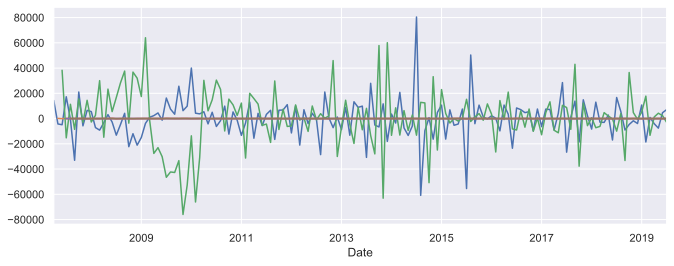

In [13]:
merge1_diff = merge1.copy()
[index_remove2,merge1_differenced] = ADF_Test(merge1_diff)
index_remove2
merge1_differenced

In [14]:
# Testing Causation using Granger’s Causality Test
# Granger’s causality tests the null hypothesis that the past values of time series (X) do not cause the other series (Y). 
# So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.
maxlag = 12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#### 4.1.1 Forecast the spread for [SP500-ACWI ex USA]

In [15]:
# Grangers Causation Test, drop the indicator that do not pass the test
def causation_test(df_differenced,n):
    df_select = df_differenced.copy()
    df_select = pd.concat([df_select.iloc[:,n],df_select.iloc[:,2:]], axis=1)
    print(df_select)
    causation_matrix = grangers_causation_matrix(df_select, variables = df_select.columns)
    index_remove=[]
    for i in causation_matrix.iloc[0,1:]:
        if i>0.055:
            index_remove.append(causation_matrix.columns.get_loc((causation_matrix == i).idxmax(axis=1)[0])+1) 
            # get column index of indicators whose p-value>0.05
    df_differenced = df_differenced.drop(df_differenced.columns[index_remove],axis=1) # drop columns whose p-value>0.05
    return causation_matrix,index_remove,df_differenced

[causation_matrix,index_remove,merge1_tested] = causation_test(merge1_differenced,0)
causation_matrix
index_remove
merge1_tested

            SP500-ACWI ex USA  DGORDER  PERMIT     ICSA      AWHAEMAN  \
Date                                                                    
2007-08-01           2.852950   -722.0     1.0  11300.0  1.000000e-01   
2007-09-01          -2.877160 -33032.0     7.0  -8550.0  0.000000e+00   
2007-10-01          -3.948966  21007.0    16.0  15550.0 -3.000000e-01   
2007-11-01           0.117234  -5756.0    67.0  -3000.0  3.000000e-01   
2007-12-01           0.598555   6528.0  -178.0  14450.0  0.000000e+00   
2008-01-01           3.882394   5531.0   -43.0  -2700.0 -2.000000e-01   
2008-02-01          -6.362737  -7137.0   -52.0   2500.0  2.000000e-01   
2008-03-01           1.623993  -9163.0   -45.0  30000.0  0.000000e+00   
2008-04-01          -1.231639  -3303.0   167.0 -14750.0 -3.000000e-01   
2008-05-01          -0.509944   3094.0   -36.0  23300.0  1.000000e-01   
2008-06-01          -0.411932  -2748.0   271.0   5500.0 -1.000000e-01   
2008-07-01           2.676590 -13147.0  -213.0  167

SP500-ACWI ex USA_x  DGORDER_x  PERMIT_x  ICSA_x  \
SP500-ACWI ex USA_y               1.0000     0.2815    0.1721  0.0720   
DGORDER_y                         0.0030     1.0000    0.0894  0.0000   
PERMIT_y                          0.0032     0.0000    1.0000  0.0000   
ICSA_y                            0.0150     0.0535    0.0216  1.0000   
AWHAEMAN_y                        0.0008     0.0000    0.0001  0.0000   
CSCICP03USM665S_y                 0.0956     0.1197    0.0075  0.2277   
T10Y3M_y                          0.1823     0.0001    0.0000  0.1609   

                     AWHAEMAN_x  CSCICP03USM665S_x  T10Y3M_x  
SP500-ACWI ex USA_y      0.4401             0.0287    0.2440  
DGORDER_y                0.0000             0.0037    0.5878  
PERMIT_y                 0.0017             0.0049    0.0001  
ICSA_y                   0.1471             0.0001    0.0050  
AWHAEMAN_y               1.0000             0.0100    0.0003  
CSCICP03USM665S_y        0.0574             1.0000    0.0000  
T10Y3M_y                 0.0978             0.0445    1.0000

[2, 3, 4, 5, 7]

SP500-ACWI ex USA  SP500-EAFE  CSCICP03USM665S
Date                                                      
2007-08-01           2.852950    2.853200         0.089706
2007-09-01          -2.877160   -1.694970        -0.469253
2007-10-01          -3.948966   -2.382502        -1.169357
2007-11-01           0.117234   -1.160651        -1.675790
2007-12-01           0.598555    1.409875        -1.953669
2008-01-01           3.882394    3.381393        -2.143401
2008-02-01          -6.362737   -4.960504        -2.305934
2008-03-01           1.623993    0.460014        -2.499122
2008-04-01          -1.231639   -0.640522        -2.846579
2008-05-01          -0.509944    0.092691        -3.159378
2008-06-01          -0.411932   -0.455658        -3.236472
2008-07-01           2.676590    2.271320        -3.014665
2008-08-01           6.004625    5.348432        -2.537795
2008-09-01           6.758688    6.099355        -2.213249
2008-10-01           6.306709    3.973842        -2.270743
2008-11-01          -1.821658   -2.223221        -2.242307
2008-12-01          -4.761977   -5.059264        -2.084861
2009-01-01           0.297779    1.373812        -1.919417
2009-02-01          -1.848649   -0.821050        -1.563785
2009-03-01           0.474776    2.050390        -0.906266
2009-04-01          -3.797985   -3.070986         0.051088
2009-05-01          -7.525203   -6.009452         0.801047
2009-06-01           1.126926    0.589956         1.074522
2009-07-01          -2.176527   -1.584875         0.831038
2009-08-01          -0.333319   -1.992315         0.621565
2009-09-01          -1.498288   -0.247342         0.721359
2009-10-01          -0.749365   -0.738526         1.096482
2009-11-01           2.752023    3.595497         1.361849
2009-12-01          -0.328625    0.331458         1.539892
2010-01-01           1.243099    0.738218         1.691073
...                       ...         ...              ...
2017-02-01           2.070558    2.232490         0.679215
2017-03-01          -2.542670   -2.754588         0.688332
2017-04-01          -1.212849   -1.607647         0.627653
2017-05-01          -2.042723   -2.453668         0.437164
2017-06-01           0.170341    0.657243         0.354733
2017-07-01          -1.703286   -0.927366         0.458731
2017-08-01          -0.467001    0.092321         0.657897
2017-09-01           0.072564   -0.545699         0.795597
2017-10-01           0.330533    0.687503         0.867145
2017-11-01           1.960533    1.726092         0.523457
2017-12-01          -1.232209   -0.614011         0.110147
2018-01-01           0.045902    0.571539        -0.006872
2018-02-01           0.857244    0.646025         0.162074
2018-03-01          -0.945594   -0.906450         0.289593
2018-04-01          -1.312700   -1.986079         0.279573
2018-05-01           4.473996    4.411265         0.266922
2018-06-01           2.380531    1.712320         0.315223
2018-07-01           1.175291    1.107076         0.325261
2018-08-01           5.096612    4.931576         0.241242
2018-09-01          -0.025948   -0.435625         0.202726
2018-10-01           1.290743    1.100899         0.038614
2018-11-01           0.828146    1.896268        -0.046454
2018-12-01          -4.994920   -4.650366        -0.129410
2019-01-01           0.290283    1.209142        -0.356422
2019-02-01           0.994662    0.412375        -0.466586
2019-03-01           1.182602    1.147955        -0.363192
2019-04-01           1.248543    1.083302        -0.165530
2019-05-01          -1.287370   -1.882346         0.023230
2019-06-01           0.818567    0.902598         0.080335
2019-07-01           2.521947    2.582091         0.091190

[144 rows x 3 columns]

In [16]:
# Build VAR Model
def VAR_Model(df_differenced,n,test_size):
    # Split the data into trainset and testset
    df = df_differenced.copy()
    df = pd.concat([df.iloc[:,n],df.iloc[:,2:]], axis=1)
    df_train, df_test = train_test_split(df, test_size=test_size,shuffle=False)
    
    # Build the Vector Autoregressive Model
    model = VAR(df_train)
    aic = []
    bic = []
    for i in range(0,7):
        try:
            result = model.fit(i)
            aic.append(result.aic)
            bic.append(result.bic)
        except:
            break
    lag1 = aic.index(min(aic))
    lag2 = bic.index(min(bic))

    if lag1>6:
        lag = lag2
    else:
        lag = lag1 

    model_fitted = model.fit(lag)
    print(model_fitted.summary())
    
    # Generate Forecast
    lag_order = model_fitted.k_ar
    nobs = df_test.shape[0]
    fc = model_fitted.forecast(y=model_fitted.y,steps=nobs)
    df_forecast = pd.DataFrame(fc, index=df_test.index, columns
                               =df.columns + '_forecast')

    # Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
    out = durbin_watson(model_fitted.resid)

    for col, val in zip(df.columns, out):
        def adjust(val, length= 6): return str(val).ljust(length)
        print(adjust(col), ':', round(val, 2))
    
    return df_train,df_test,df_forecast

In [17]:
# Forecast and Plot
def forecast_plot(df_forecast,df_train,df_test,train_size):
    date_f = df_forecast.index.values
    nobs = len(date_f)
    col = df_train.columns[0]  
    date = df_train.index.values
    
    fig, ax = plt.subplots(dpi=300)
    plt.plot(date, df_train[col],
             marker='.', linestyle='-', linewidth=0.7)
    plt.plot(date_f, df_forecast.iloc[:,0],marker='.',
             linestyle='-', linewidth=0.7)
    plt.plot(date_f, df_test[col],marker='.', linestyle='-', linewidth=0.7)
    plt.gca().legend((col+'_train',col+'_forecast',col+'_actual'))
    myFmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    plt.xticks(rotation=30)
    plt.xlabel('Date')
    plt.ylabel('Returns(%)')
    plt.title(col + ": Forecast vs Actuals Expected Returns, Train Set = "+ "%.2f%%"% train_size)
    plt.show()


In [18]:
# Train Set = 95%
[df1_train,df1_test,df1_forecast] = VAR_Model(merge1_tested,0,0.05)
df1_forecast 
df1_test

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     09:51:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.60175
Nobs:                     132.000    HQIC:                  -1.83512
Log likelihood:          -224.939    FPE:                   0.136090
AIC:                     -1.99486    Det(Omega_mle):        0.119271
--------------------------------------------------------------------
Results for equation SP500-ACWI ex USA
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.389099         0.224657            1.732           0.083
L1.SP500-ACWI ex USA         0.116868         0.088933            1.314           0.189
L1.CSCICP03USM665S  

SP500-ACWI ex USA_forecast  CSCICP03USM665S_forecast
Date                                                            
2018-12-01                   -0.045869                 -0.028403
2019-01-01                    0.710171                  0.038571
2019-02-01                    0.543296                  0.092465
2019-03-01                    0.422955                  0.109912
2019-04-01                    0.400258                  0.108729
2019-05-01                    0.300221                  0.110081
2019-06-01                    0.354602                  0.121997
2019-07-01                    0.405478                  0.140521

SP500-ACWI ex USA  CSCICP03USM665S
Date                                          
2018-12-01          -4.994920        -0.129410
2019-01-01           0.290283        -0.356422
2019-02-01           0.994662        -0.466586
2019-03-01           1.182602        -0.363192
2019-04-01           1.248543        -0.165530
2019-05-01          -1.287370         0.023230
2019-06-01           0.818567         0.080335
2019-07-01           2.521947         0.091190

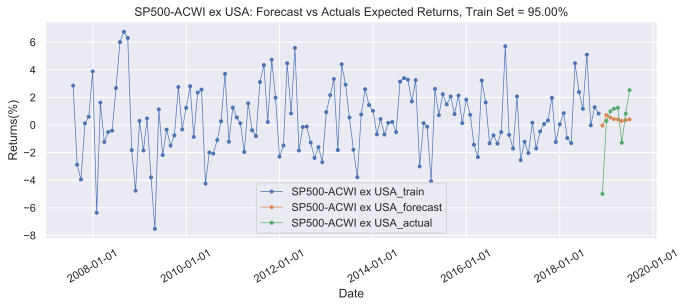

In [19]:
forecast_plot(df1_forecast,df1_train,df1_test,95)

#### 4.1.2 Forecast the spread for [SP500-EAFE]

In [20]:
[causation_matrix,index_remove,merge1_tested_EAFE] = causation_test(merge1_differenced,1)
causation_matrix
index_remove
merge1_tested_EAFE

            SP500-EAFE  DGORDER  PERMIT     ICSA      AWHAEMAN  \
Date                                                             
2007-08-01    2.853200   -722.0     1.0  11300.0  1.000000e-01   
2007-09-01   -1.694970 -33032.0     7.0  -8550.0  0.000000e+00   
2007-10-01   -2.382502  21007.0    16.0  15550.0 -3.000000e-01   
2007-11-01   -1.160651  -5756.0    67.0  -3000.0  3.000000e-01   
2007-12-01    1.409875   6528.0  -178.0  14450.0  0.000000e+00   
2008-01-01    3.381393   5531.0   -43.0  -2700.0 -2.000000e-01   
2008-02-01   -4.960504  -7137.0   -52.0   2500.0  2.000000e-01   
2008-03-01    0.460014  -9163.0   -45.0  30000.0  0.000000e+00   
2008-04-01   -0.640522  -3303.0   167.0 -14750.0 -3.000000e-01   
2008-05-01    0.092691   3094.0   -36.0  23300.0  1.000000e-01   
2008-06-01   -0.455658  -2748.0   271.0   5500.0 -1.000000e-01   
2008-07-01    2.271320 -13147.0  -213.0  16700.0 -1.000000e-01   
2008-08-01    5.348432  -4725.0   -23.0  28250.0  0.000000e+00   
2008-09-01

SP500-EAFE_x  DGORDER_x  PERMIT_x  ICSA_x  AWHAEMAN_x  \
SP500-EAFE_y             1.0000     0.2180    0.1755  0.0623      0.2534   
DGORDER_y                0.0164     1.0000    0.0894  0.0000      0.0000   
PERMIT_y                 0.0495     0.0000    1.0000  0.0000      0.0017   
ICSA_y                   0.0224     0.0535    0.0216  1.0000      0.1471   
AWHAEMAN_y               0.0035     0.0000    0.0001  0.0000      1.0000   
CSCICP03USM665S_y        0.0428     0.1197    0.0075  0.2277      0.0574   
T10Y3M_y                 0.2553     0.0001    0.0000  0.1609      0.0978   

                   CSCICP03USM665S_x  T10Y3M_x  
SP500-EAFE_y                  0.0306    0.1605  
DGORDER_y                     0.0037    0.5878  
PERMIT_y                      0.0049    0.0001  
ICSA_y                        0.0001    0.0050  
AWHAEMAN_y                    0.0100    0.0003  
CSCICP03USM665S_y             1.0000    0.0000  
T10Y3M_y                      0.0445    1.0000

[2, 3, 4, 5, 7]

SP500-ACWI ex USA  SP500-EAFE  CSCICP03USM665S
Date                                                      
2007-08-01           2.852950    2.853200         0.089706
2007-09-01          -2.877160   -1.694970        -0.469253
2007-10-01          -3.948966   -2.382502        -1.169357
2007-11-01           0.117234   -1.160651        -1.675790
2007-12-01           0.598555    1.409875        -1.953669
2008-01-01           3.882394    3.381393        -2.143401
2008-02-01          -6.362737   -4.960504        -2.305934
2008-03-01           1.623993    0.460014        -2.499122
2008-04-01          -1.231639   -0.640522        -2.846579
2008-05-01          -0.509944    0.092691        -3.159378
2008-06-01          -0.411932   -0.455658        -3.236472
2008-07-01           2.676590    2.271320        -3.014665
2008-08-01           6.004625    5.348432        -2.537795
2008-09-01           6.758688    6.099355        -2.213249
2008-10-01           6.306709    3.973842        -2.270743
2008-11-01          -1.821658   -2.223221        -2.242307
2008-12-01          -4.761977   -5.059264        -2.084861
2009-01-01           0.297779    1.373812        -1.919417
2009-02-01          -1.848649   -0.821050        -1.563785
2009-03-01           0.474776    2.050390        -0.906266
2009-04-01          -3.797985   -3.070986         0.051088
2009-05-01          -7.525203   -6.009452         0.801047
2009-06-01           1.126926    0.589956         1.074522
2009-07-01          -2.176527   -1.584875         0.831038
2009-08-01          -0.333319   -1.992315         0.621565
2009-09-01          -1.498288   -0.247342         0.721359
2009-10-01          -0.749365   -0.738526         1.096482
2009-11-01           2.752023    3.595497         1.361849
2009-12-01          -0.328625    0.331458         1.539892
2010-01-01           1.243099    0.738218         1.691073
...                       ...         ...              ...
2017-02-01           2.070558    2.232490         0.679215
2017-03-01          -2.542670   -2.754588         0.688332
2017-04-01          -1.212849   -1.607647         0.627653
2017-05-01          -2.042723   -2.453668         0.437164
2017-06-01           0.170341    0.657243         0.354733
2017-07-01          -1.703286   -0.927366         0.458731
2017-08-01          -0.467001    0.092321         0.657897
2017-09-01           0.072564   -0.545699         0.795597
2017-10-01           0.330533    0.687503         0.867145
2017-11-01           1.960533    1.726092         0.523457
2017-12-01          -1.232209   -0.614011         0.110147
2018-01-01           0.045902    0.571539        -0.006872
2018-02-01           0.857244    0.646025         0.162074
2018-03-01          -0.945594   -0.906450         0.289593
2018-04-01          -1.312700   -1.986079         0.279573
2018-05-01           4.473996    4.411265         0.266922
2018-06-01           2.380531    1.712320         0.315223
2018-07-01           1.175291    1.107076         0.325261
2018-08-01           5.096612    4.931576         0.241242
2018-09-01          -0.025948   -0.435625         0.202726
2018-10-01           1.290743    1.100899         0.038614
2018-11-01           0.828146    1.896268        -0.046454
2018-12-01          -4.994920   -4.650366        -0.129410
2019-01-01           0.290283    1.209142        -0.356422
2019-02-01           0.994662    0.412375        -0.466586
2019-03-01           1.182602    1.147955        -0.363192
2019-04-01           1.248543    1.083302        -0.165530
2019-05-01          -1.287370   -1.882346         0.023230
2019-06-01           0.818567    0.902598         0.080335
2019-07-01           2.521947    2.582091         0.091190

[144 rows x 3 columns]

In [21]:
# Train Set = 95%
[df1_train_EAFE,df1_test_EAFE,df1_forecast_EAFE] = VAR_Model(merge1_tested_EAFE,1,0.05)
df1_forecast_EAFE 
df1_test_EAFE

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     09:51:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.66440
Nobs:                     132.000    HQIC:                  -1.89777
Log likelihood:          -220.804    FPE:                   0.127826
AIC:                     -2.05751    Det(Omega_mle):        0.112028
--------------------------------------------------------------------
Results for equation SP500-EAFE
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.428276         0.220071            1.946           0.052
L1.SP500-EAFE              0.051535         0.089604            0.575           0.565
L1.CSCICP03USM665S         0.392804

SP500-EAFE_forecast  CSCICP03USM665S_forecast
Date                                                     
2018-12-01             0.159670                 -0.029956
2019-01-01             0.709401                  0.032098
2019-02-01             0.584594                  0.078448
2019-03-01             0.322764                  0.084512
2019-04-01             0.352500                  0.073399
2019-05-01             0.325497                  0.070149
2019-06-01             0.386429                  0.082130
2019-07-01             0.440666                  0.103475

SP500-EAFE  CSCICP03USM665S
Date                                   
2018-12-01   -4.650366        -0.129410
2019-01-01    1.209142        -0.356422
2019-02-01    0.412375        -0.466586
2019-03-01    1.147955        -0.363192
2019-04-01    1.083302        -0.165530
2019-05-01   -1.882346         0.023230
2019-06-01    0.902598         0.080335
2019-07-01    2.582091         0.091190

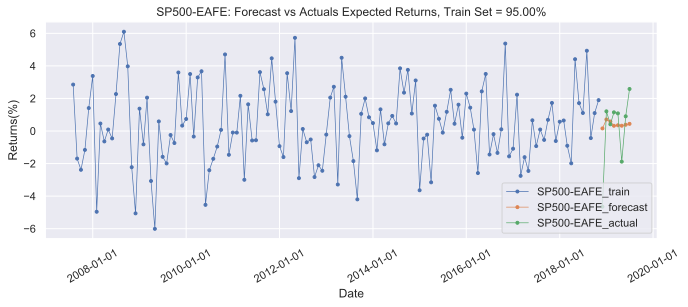

In [22]:
forecast_plot(df1_forecast_EAFE,df1_train_EAFE,df1_test_EAFE,95)

### 4.2 Coincident Indicators

* All Employees: Total Nonfarm Payrolls (PAYEMS)
* Real Disposable Personal Income (DSPIC96)
* Industrial Production Index (INDPRO)
* Real Manufacturing and Trade Industries Sales (CMRMTSPL)
* Personal Consumption Expenditures (PCE)
* Advance Real Retail and Food Services Sales (RRSFS)
* Merchant Wholesalers, Except Manufacturers' Sales Branches and Offices Sales: Durable Goods Sales (S423SMM144SCEN)
* Producer Price Index for All Commodities (PPIACO)

PAYEMS
1940-02-01 -0.236005
1940-03-01 -0.242996
1940-04-01 -0.086741
1940-05-01 -0.094797
1940-06-01 -0.148000
1940-07-01 -0.096172
1940-08-01 -0.014364
1940-09-01  0.014025
1940-10-01  0.030924
1940-11-01  0.129182
1940-12-01  0.232004
1941-01-01  0.271098
1941-02-01  0.348316
1941-03-01  0.399636
1941-04-01  0.502169
1941-05-01  0.631512
1941-06-01  0.743099
1941-07-01  0.848647
1941-08-01  0.793488
1941-09-01  0.722955
1941-10-01  0.618912
1941-11-01  0.450810
1941-12-01  0.239242
1942-01-01  0.159262
1942-02-01  0.050459
1942-03-01  0.051661
1942-04-01 -0.069723
1942-05-01 -0.266984
1942-06-01 -0.401715
1942-07-01 -0.539128
...              ...
2017-03-01 -0.029552
2017-04-01 -0.024138
2017-05-01  0.000219
2017-06-01 -0.009373
2017-07-01 -0.019362
2017-08-01 -0.017154
2017-09-01 -0.039417
2017-10-01 -0.019566
2017-11-01 -0.012921
2017-12-01 -0.011428
2018-01-01 -0.025392
2018-02-01 -0.009436
2018-03-01 -0.000126
2018-04-01 -0.001193
2018-05-01  0.000228
2018-06-01  0.005141
2018-07-01  0.011299
2018-08-01  0.013591
2018-09-01  0.033108
2018-10-01  0.026418
2018-11-01  0.022181
2018-12-01  0.027447
2019-01-01  0.039858
2019-02-01  0.013838
2019-03-01  0.009082
2019-04-01  0.011146
2019-05-01 -0.008420
2019-06-01 -0.014905
2019-07-01 -0.014454
2019-08-01 -0.028163

[943 rows x 1 columns]

DSPIC96
1960-02-01 -0.283672
1960-03-01 -0.368731
1960-04-01 -0.333759
1960-05-01 -0.331418
1960-06-01 -0.312941
1960-07-01 -0.207791
1960-08-01 -0.126005
1960-09-01 -0.097829
1960-10-01 -0.054754
1960-11-01 -0.162326
1960-12-01 -0.276545
1961-01-01 -0.191423
1961-02-01 -0.134543
1961-03-01 -0.071711
1961-04-01 -0.064348
1961-05-01  0.011928
1961-06-01  0.109474
1961-07-01  0.097977
1961-08-01  0.086868
1961-09-01  0.074293
1961-10-01  0.107140
1961-11-01  0.312520
1961-12-01  0.519053
1962-01-01  0.356019
1962-02-01  0.325653
1962-03-01  0.320757
1962-04-01  0.354984
1962-05-01  0.242965
1962-06-01  0.081409
1962-07-01  0.074251
...              ...
2017-02-01 -0.014403
2017-03-01 -0.013215
2017-04-01  0.051418
2017-05-01  0.132718
2017-06-01  0.138756
2017-07-01  0.135844
2017-08-01  0.149686
2017-09-01  0.142135
2017-10-01  0.144583
2017-11-01  0.123598
2017-12-01  0.166386
2018-01-01  0.179005
2018-02-01  0.143896
2018-03-01  0.098867
2018-04-01  0.104738
2018-05-01  0.040590
2018-06-01  0.082971
2018-07-01  0.083943
2018-08-01  0.094578
2018-09-01  0.072990
2018-10-01  0.049359
2018-11-01  0.027598
2018-12-01  0.044217
2019-01-01 -0.063097
2019-02-01 -0.037030
2019-03-01 -0.038243
2019-04-01 -0.054531
2019-05-01 -0.032088
2019-06-01 -0.063172
2019-07-01 -0.084839

[704 rows x 1 columns]

INDPRO
1920-03-01  2.760115
1920-04-01 -0.588333
1920-05-01  0.049271
1920-06-01 -1.000273
1920-07-01 -2.226304
1920-08-01 -2.054820
1920-09-01 -1.993846
1920-10-01 -2.134416
1920-11-01 -2.622761
1920-12-01 -3.089576
1921-04-01 -3.710677
1921-05-01 -3.853119
1921-06-01 -3.560955
1921-07-01 -2.712698
1921-08-01 -2.383360
1921-09-01 -1.895067
1921-10-01 -0.776209
1921-11-01  0.419215
1921-12-01  1.526600
1922-01-01  3.577688
1922-10-01  3.388956
1922-11-01  3.240841
1922-12-01  3.062970
1923-01-01  1.747370
1923-02-01  0.982338
1923-03-01  0.141784
1923-04-01  0.898629
1923-05-01  0.384595
1923-06-01 -0.557698
1923-07-01 -0.687955
...              ...
2017-02-01  0.293057
2017-03-01  0.457961
2017-04-01  0.466704
2017-05-01  0.456029
2017-06-01  0.368182
2017-07-01  0.371316
2017-08-01  0.333770
2017-09-01  0.301960
2017-10-01  0.364163
2017-11-01  0.383336
2017-12-01  0.219900
2018-01-01  0.250332
2018-02-01  0.283491
2018-03-01  0.152493
2018-04-01  0.086693
2018-05-01 -0.009296
2018-06-01  0.062132
2018-07-01  0.126916
2018-08-01  0.265216
2018-09-01  0.276783
2018-10-01  0.060557
2018-11-01  0.000246
2018-12-01  0.021226
2019-01-01  0.039666
2019-02-01 -0.092897
2019-03-01 -0.123661
2019-04-01 -0.252862
2019-05-01 -0.089093
2019-06-01 -0.185661
2019-07-01 -0.281225

[1158 rows x 1 columns]

CMRMTSPL
1968-02-01  0.068902
1968-03-01  0.044349
1968-04-01 -0.014829
1968-05-01  0.183950
1968-06-01  0.140064
1968-07-01  0.383064
1968-08-01 -0.107930
1968-09-01  0.035249
1968-10-01  0.258160
1968-11-01  0.052405
1968-12-01 -0.236979
1969-01-01 -0.133022
1969-02-01 -0.099488
1969-03-01 -0.132333
1969-04-01 -0.068732
1969-05-01 -0.197697
1969-06-01 -0.258232
1969-07-01 -0.468200
1969-08-01  0.019512
1969-09-01 -0.142649
1969-10-01 -0.329029
1969-11-01 -0.366811
1969-12-01 -0.043643
1970-01-01 -0.233753
1970-02-01 -0.278595
1970-03-01 -0.375945
1970-04-01 -0.506623
1970-05-01 -0.346914
1970-06-01 -0.245340
1970-07-01 -0.162005
...              ...
2017-01-01  0.160040
2017-02-01 -0.005355
2017-03-01  0.009181
2017-04-01  0.079652
2017-05-01  0.117568
2017-06-01  0.072612
2017-07-01  0.124306
2017-08-01  0.063195
2017-09-01  0.150417
2017-10-01  0.153829
2017-11-01  0.194379
2017-12-01  0.022229
2018-01-01 -0.010090
2018-02-01  0.088773
2018-03-01  0.110122
2018-04-01  0.123573
2018-05-01  0.047684
2018-06-01  0.017298
2018-07-01 -0.040896
2018-08-01 -0.029015
2018-09-01 -0.090762
2018-10-01 -0.170179
2018-11-01 -0.272138
2018-12-01 -0.251514
2019-01-01  0.022350
2019-02-01 -0.053436
2019-03-01 -0.048249
2019-04-01 -0.110777
2019-05-01 -0.145940
2019-06-01 -0.028174

[607 rows x 1 columns]

PCE
1960-03-01 -0.057104
1960-05-01 -0.314058
1960-06-01 -0.377616
1960-07-01 -0.228208
1960-08-01 -0.294467
1960-09-01 -0.345175
1960-10-01 -0.192283
1960-11-01 -0.176152
1960-12-01 -0.271952
1961-01-01 -0.244728
1961-02-01 -0.199768
1961-03-01 -0.266624
1961-05-01 -0.112294
1961-06-01 -0.037683
1961-07-01 -0.121010
1961-08-01 -0.031750
1961-09-01  0.037320
1961-10-01 -0.047766
1961-11-01  0.036186
1961-12-01  0.300508
1962-01-01  0.292235
1962-02-01  0.279666
1962-03-01  0.285319
1962-04-01  0.484975
1962-05-01  0.278616
1962-06-01  0.195265
1962-07-01  0.265783
1962-08-01  0.232088
1962-09-01  0.299916
1962-10-01  0.196306
...              ...
2017-02-01  0.039379
2017-03-01  0.125468
2017-04-01  0.068411
2017-05-01  0.058100
2017-06-01  0.003092
2017-07-01  0.036211
2017-08-01  0.039924
2017-09-01  0.037221
2017-10-01  0.025163
2017-11-01  0.064462
2017-12-01  0.029648
2018-01-01 -0.005680
2018-02-01  0.035281
2018-03-01 -0.000384
2018-04-01  0.054271
2018-05-01  0.124998
2018-06-01  0.147904
2018-07-01  0.173142
2018-08-01  0.170936
2018-09-01  0.059049
2018-10-01  0.061449
2018-11-01  0.000347
2018-12-01 -0.116207
2019-01-01 -0.068614
2019-02-01 -0.085560
2019-03-01 -0.047855
2019-04-01 -0.071064
2019-05-01 -0.131305
2019-06-01 -0.132625
2019-07-01 -0.150837

[705 rows x 1 columns]

RRSFS
1993-02-01 -0.848248
1993-03-01 -0.579273
1993-04-01  0.217550
1993-05-01  0.246993
1993-06-01  0.154594
1993-07-01  0.275531
1993-08-01  0.187865
1993-09-01  0.128580
1993-10-01  0.103178
1993-11-01  0.172850
1993-12-01  0.121148
1994-01-01 -0.011983
1994-02-01  0.249556
1994-03-01  0.487490
1994-04-01  0.150393
1994-05-01  0.018952
1994-06-01  0.128150
1994-07-01 -0.055427
1994-08-01  0.061485
1994-09-01  0.098831
1994-10-01  0.161059
1994-11-01  0.017185
1994-12-01  0.016792
1995-01-01  0.210150
1995-02-01 -0.243265
1995-03-01 -0.525826
1995-04-01 -0.337031
1995-05-01 -0.121394
1995-06-01 -0.199457
1995-07-01 -0.122065
...              ...
2017-02-01 -0.105603
2017-03-01  0.077421
2017-04-01  0.102212
2017-05-01  0.101374
2017-06-01 -0.001229
2017-07-01  0.056230
2017-08-01  0.055870
2017-09-01  0.122149
2017-10-01  0.100824
2017-11-01  0.195138
2017-12-01  0.130467
2018-01-01 -0.067534
2018-02-01  0.069770
2018-03-01  0.028477
2018-04-01 -0.025004
2018-05-01  0.127818
2018-06-01  0.120687
2018-07-01  0.138791
2018-08-01  0.153841
2018-09-01 -0.105812
2018-10-01 -0.066282
2018-11-01 -0.163927
2018-12-01 -0.307918
2019-01-01 -0.090281
2019-02-01 -0.173408
2019-03-01 -0.046834
2019-04-01 -0.036359
2019-05-01 -0.198029
2019-06-01 -0.124975
2019-07-01 -0.151005

[311 rows x 1 columns]

S423SMM144SCEN
1993-04-01       -1.425233
1993-05-01       -0.233774
1993-06-01       -1.010502
1993-07-01       -0.475233
1993-08-01       -0.409771
1993-09-01       -0.412298
1993-10-01       -0.350983
1993-11-01       -0.520526
1993-12-01       -0.517518
1994-01-01       -0.603696
1994-02-01       -0.309325
1994-03-01        0.357063
1994-04-01       -0.026541
1994-05-01       -0.363103
1994-06-01        0.147591
1994-07-01       -0.174580
1994-08-01        0.163376
1994-09-01        0.168913
1994-10-01        0.256789
1994-11-01        0.465564
1994-12-01        0.738260
1995-01-01        0.705402
1995-02-01        0.673431
1995-03-01        0.016793
1995-04-01        0.286862
1995-05-01        0.363610
1995-06-01        0.130647
1995-07-01        0.131782
1995-08-01       -0.407627
1995-09-01       -0.271881
...                    ...
2017-01-01        0.979374
2017-02-01        0.533311
2017-03-01        0.534999
2017-04-01        0.811296
2017-05-01        0.694502
2017-06-01        0.390797
2017-07-01        0.455948
2017-08-01        0.647128
2017-09-01        0.798668
2017-10-01        0.699777
2017-11-01        0.748457
2017-12-01        0.318223
2018-01-01       -0.060638
2018-02-01        0.146534
2018-03-01        0.230519
2018-04-01       -0.027505
2018-05-01        0.202201
2018-06-01        0.327231
2018-07-01        0.275898
2018-08-01        0.038250
2018-09-01       -0.116488
2018-10-01       -0.269391
2018-11-01       -0.534226
2018-12-01       -0.404619
2019-01-01       -0.105960
2019-02-01       -0.394870
2019-03-01       -0.450186
2019-04-01       -0.429302
2019-05-01       -0.705727
2019-06-01       -0.681695

[305 rows x 1 columns]

PPIACO
1914-02-01  0.829880
1914-03-01 -0.010594
1914-04-01 -0.007063
1914-05-01 -0.010685
1914-06-01 -0.008548
1914-07-01 -0.146594
1914-08-01  0.358656
1914-09-01  0.210943
1914-10-01 -0.186013
1914-11-01 -0.085107
1914-12-01 -0.003885
1915-01-01  0.209216
1915-02-01  0.140059
1915-03-01  0.281904
1915-04-01  0.281904
1915-05-01  0.425555
1915-06-01  0.355231
1915-07-01  0.495290
1915-08-01 -0.140059
1915-09-01 -0.140629
1915-10-01  0.628864
1915-11-01  0.696892
1915-12-01  1.033111
1916-01-01  0.997204
1916-02-01  1.121585
1916-03-01  1.293988
1916-04-01  1.413038
1916-05-01  1.259752
1916-06-01  1.458880
1916-07-01  1.376304
...              ...
2017-02-01  0.899171
2017-03-01  0.838864
2017-04-01  0.777358
2017-05-01  0.687181
2017-06-01  0.576196
2017-07-01  0.524418
2017-08-01  0.548888
2017-09-01  0.442516
2017-10-01  0.393828
2017-11-01  0.391835
2017-12-01  0.140403
2018-01-01 -0.052860
2018-02-01 -0.132128
2018-03-01 -0.086737
2018-04-01 -0.124881
2018-05-01  0.107167
2018-06-01  0.181863
2018-07-01  0.198995
2018-08-01  0.087403
2018-09-01  0.023202
2018-10-01  0.046556
2018-11-01 -0.150822
2018-12-01 -0.153984
2019-01-01 -0.258458
2019-02-01 -0.332527
2019-03-01 -0.270210
2019-04-01 -0.234831
2019-05-01 -0.507822
2019-06-01 -0.604912
2019-07-01 -0.588305

[1244 rows x 1 columns]

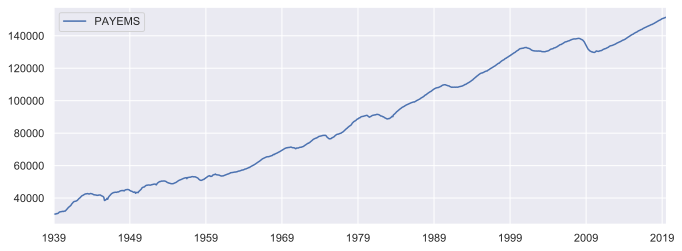

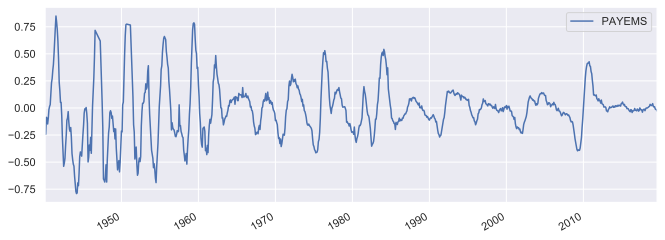

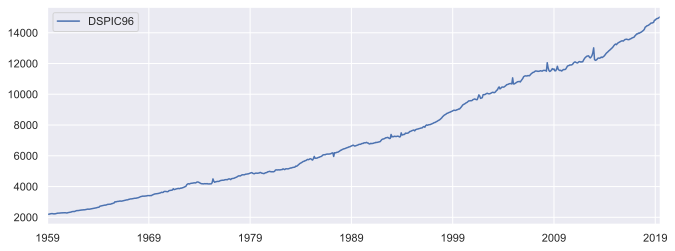

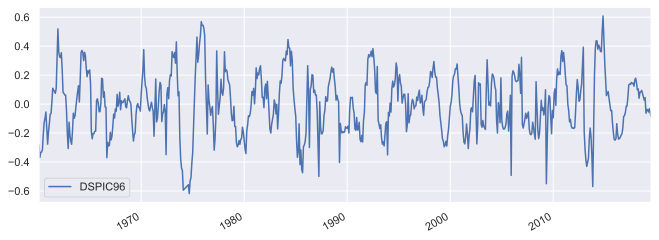

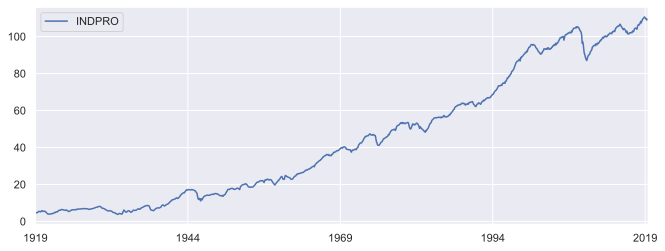

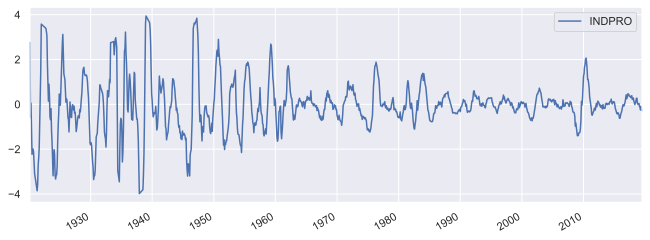

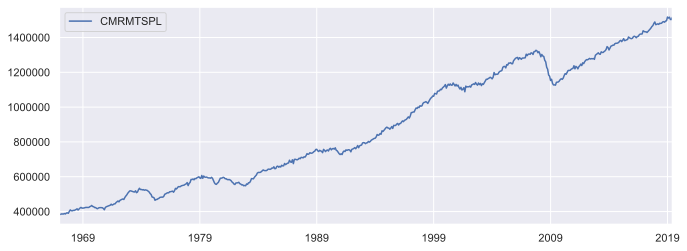

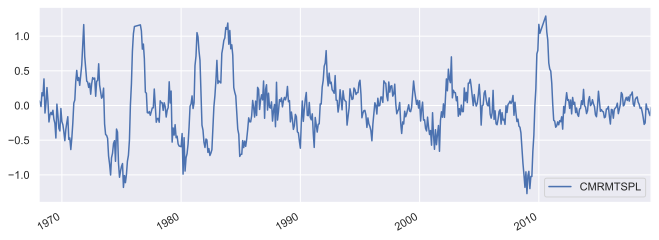

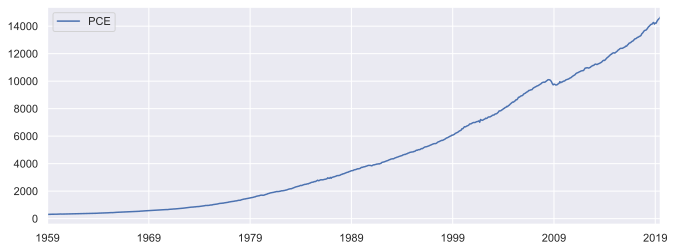

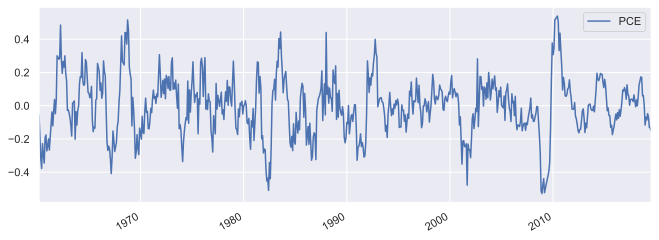

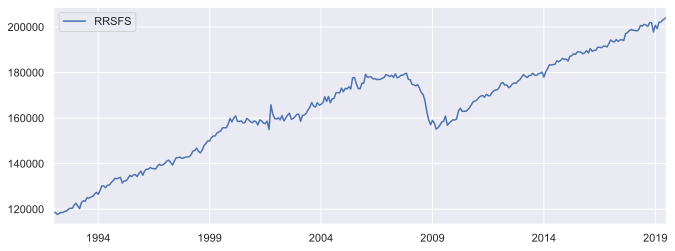

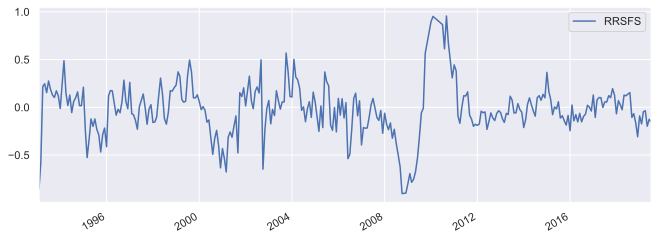

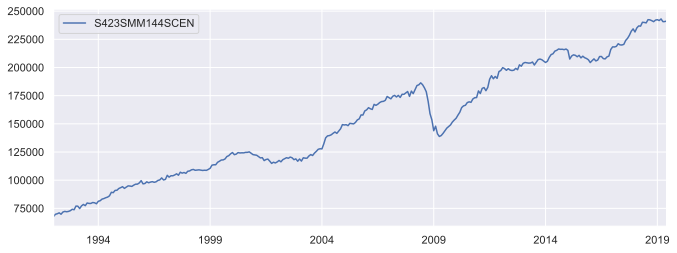

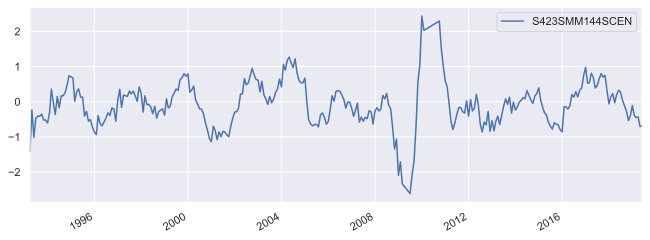

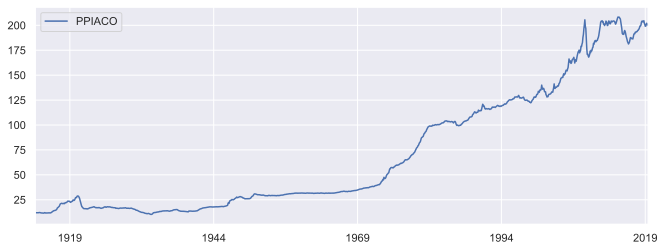

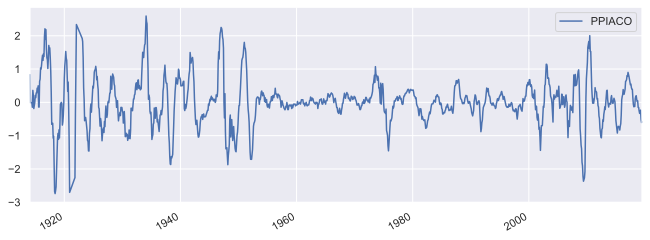

In [23]:
# Coincident Indicators from Fred Data
coincident_fred = ['PAYEMS','DSPIC96','INDPRO','CMRMTSPL','PCE','RRSFS','S423SMM144SCEN','PPIACO']
coincident_df = {}
for i in range(0,len(coincident_fred)):
    data = fred.get_series(coincident_fred[i]).dropna()
    data_series = pd.DataFrame(data,columns=[coincident_fred[i]])
    data_series = data_series.resample('MS').sum().dropna()
    data_series.plot()
    data_series = np.log(data_series).diff().dropna()*100
    data_series = data_series.diff(periods=12).dropna()
    data_series = data_series.rolling(12, min_periods=1).mean()
    z = np.abs(stats.zscore(data_series))
    data_series_o = data_series[(z < 3).all(axis=1)]
    data_series_o.plot()
    coincident_df[coincident_fred[i]] = data_series_o
    data_series_o
    

In [24]:
merge2 = Merge(coincident_df,coincident_fred)
merge2 = merge2.rename(columns={'index':'Date'})
merge2

SP500-ACWI ex USA  SP500-EAFE    PAYEMS   DSPIC96    INDPRO  \
2002-10-01           3.073344    3.056363  0.004206  0.147638  0.594417   
2002-11-01           0.865385    1.111491  0.055747  0.131342  0.721922   
2002-12-01          -2.929204   -2.802643  0.076576  0.139069  0.653793   
2003-01-01           0.803645    1.484666  0.099263 -0.139311  0.558220   
2003-02-01           0.351309    0.606749  0.111199 -0.159950  0.520974   
2003-03-01           2.863060    2.816638  0.097305 -0.113320  0.346765   
2003-04-01          -1.315927   -1.557381  0.088249 -0.151563  0.193963   
2003-05-01          -1.130339   -0.918217  0.084787 -0.163442  0.074919   
2003-06-01          -1.549900   -1.262002  0.071424 -0.175391 -0.118949   
2003-07-01          -1.003121   -0.782466  0.075028  0.099308 -0.090106   
2003-08-01          -1.146842   -0.614686  0.063512  0.305734 -0.114520   
2003-09-01          -3.943516   -4.237714  0.064845  0.137041 -0.120675   
2003-10-01          -0.923415   -0.695939  0.041608 -0.007681 -0.094843   
2003-11-01          -1.431610   -1.488539  0.024424  0.014362 -0.158581   
2003-12-01          -2.399238   -2.570411  0.039912 -0.012750 -0.080597   
2004-01-01           0.134022    0.308726  0.029517  0.142816 -0.133349   
2004-02-01          -1.278922   -1.068684  0.042996  0.207337 -0.108901   
2004-03-01          -2.223979   -2.210518  0.089058  0.198603 -0.044146   
2004-04-01           1.539649    0.594733  0.106729  0.175951  0.147298   
2004-05-01           0.972669    0.865415  0.123371  0.122251  0.243577   
2004-06-01          -0.321996   -0.384448  0.132695  0.098532  0.225641   
2004-07-01          -0.511821   -0.190041  0.130750 -0.110267  0.196384   
2004-08-01          -0.543693   -0.212167  0.141555 -0.199733  0.227405   
2004-09-01          -2.217515   -1.647963  0.132088  0.009624  0.148172   
2004-10-01          -2.021052   -1.961425  0.137182 -0.026069  0.178421   
2004-11-01          -2.898286   -2.821222  0.137768 -0.128237  0.111338   
2004-12-01          -1.002109   -1.098537  0.121626  0.180742  0.143311   
2005-01-01          -0.809420   -0.709824  0.114541 -0.108001  0.202333   
2005-02-01          -2.916108   -2.357492  0.114898 -0.155212  0.170623   
2005-03-01           0.857202    0.614029  0.069097 -0.172507  0.221187   
...                       ...         ...       ...       ...       ...   
2017-01-01          -1.708501   -1.086877 -0.009963 -0.055815  0.248374   
2017-02-01           2.070558    2.232490 -0.014195 -0.014403  0.293057   
2017-03-01          -2.542670   -2.754588 -0.029552 -0.013215  0.457961   
2017-04-01          -1.212849   -1.607647 -0.024138  0.051418  0.466704   
2017-05-01          -2.042723   -2.453668  0.000219  0.132718  0.456029   
2017-06-01           0.170341    0.657243 -0.009373  0.138756  0.368182   
2017-07-01          -1.703286   -0.927366 -0.019362  0.135844  0.371316   
2017-08-01          -0.467001    0.092321 -0.017154  0.149686  0.333770   
2017-09-01           0.072564   -0.545699 -0.039417  0.142135  0.301960   
2017-10-01           0.330533    0.687503 -0.019566  0.144583  0.364163   
2017-11-01           1.960533    1.726092 -0.012921  0.123598  0.383336   
2017-12-01          -1.232209   -0.614011 -0.011428  0.166386  0.219900   
2018-01-01           0.045902    0.571539 -0.025392  0.179005  0.250332   
2018-02-01           0.857244    0.646025 -0.009436  0.143896  0.283491   
2018-03-01          -0.945594   -0.906450 -0.000126  0.098867  0.152493   
2018-04-01          -1.312700   -1.986079 -0.001193  0.104738  0.086693   
2018-05-01           4.473996    4.411265  0.000228  0.040590 -0.009296   
2018-06-01           2.380531    1.712320  0.005141  0.082971  0.062132   
2018-07-01           1.175291    1.107076  0.011299  0.083943  0.126916   
2018-08-01           5.096612    4.931576  0.013591  0.094578  0.265216   
2018-09-01          -0.025948   -0.435625  0.033108  0.072990  0.276783   
2018-10-01           1.290743    1.10

0
0
0
0
0
0
0
0


[]

SP500-ACWI ex USA  SP500-EAFE    PAYEMS   DSPIC96    INDPRO  \
2002-10-01           3.073344    3.056363  0.004206  0.147638  0.594417   
2002-11-01           0.865385    1.111491  0.055747  0.131342  0.721922   
2002-12-01          -2.929204   -2.802643  0.076576  0.139069  0.653793   
2003-01-01           0.803645    1.484666  0.099263 -0.139311  0.558220   
2003-02-01           0.351309    0.606749  0.111199 -0.159950  0.520974   
2003-03-01           2.863060    2.816638  0.097305 -0.113320  0.346765   
2003-04-01          -1.315927   -1.557381  0.088249 -0.151563  0.193963   
2003-05-01          -1.130339   -0.918217  0.084787 -0.163442  0.074919   
2003-06-01          -1.549900   -1.262002  0.071424 -0.175391 -0.118949   
2003-07-01          -1.003121   -0.782466  0.075028  0.099308 -0.090106   
2003-08-01          -1.146842   -0.614686  0.063512  0.305734 -0.114520   
2003-09-01          -3.943516   -4.237714  0.064845  0.137041 -0.120675   
2003-10-01          -0.923415   -0.695939  0.041608 -0.007681 -0.094843   
2003-11-01          -1.431610   -1.488539  0.024424  0.014362 -0.158581   
2003-12-01          -2.399238   -2.570411  0.039912 -0.012750 -0.080597   
2004-01-01           0.134022    0.308726  0.029517  0.142816 -0.133349   
2004-02-01          -1.278922   -1.068684  0.042996  0.207337 -0.108901   
2004-03-01          -2.223979   -2.210518  0.089058  0.198603 -0.044146   
2004-04-01           1.539649    0.594733  0.106729  0.175951  0.147298   
2004-05-01           0.972669    0.865415  0.123371  0.122251  0.243577   
2004-06-01          -0.321996   -0.384448  0.132695  0.098532  0.225641   
2004-07-01          -0.511821   -0.190041  0.130750 -0.110267  0.196384   
2004-08-01          -0.543693   -0.212167  0.141555 -0.199733  0.227405   
2004-09-01          -2.217515   -1.647963  0.132088  0.009624  0.148172   
2004-10-01          -2.021052   -1.961425  0.137182 -0.026069  0.178421   
2004-11-01          -2.898286   -2.821222  0.137768 -0.128237  0.111338   
2004-12-01          -1.002109   -1.098537  0.121626  0.180742  0.143311   
2005-01-01          -0.809420   -0.709824  0.114541 -0.108001  0.202333   
2005-02-01          -2.916108   -2.357492  0.114898 -0.155212  0.170623   
2005-03-01           0.857202    0.614029  0.069097 -0.172507  0.221187   
...                       ...         ...       ...       ...       ...   
2017-01-01          -1.708501   -1.086877 -0.009963 -0.055815  0.248374   
2017-02-01           2.070558    2.232490 -0.014195 -0.014403  0.293057   
2017-03-01          -2.542670   -2.754588 -0.029552 -0.013215  0.457961   
2017-04-01          -1.212849   -1.607647 -0.024138  0.051418  0.466704   
2017-05-01          -2.042723   -2.453668  0.000219  0.132718  0.456029   
2017-06-01           0.170341    0.657243 -0.009373  0.138756  0.368182   
2017-07-01          -1.703286   -0.927366 -0.019362  0.135844  0.371316   
2017-08-01          -0.467001    0.092321 -0.017154  0.149686  0.333770   
2017-09-01           0.072564   -0.545699 -0.039417  0.142135  0.301960   
2017-10-01           0.330533    0.687503 -0.019566  0.144583  0.364163   
2017-11-01           1.960533    1.726092 -0.012921  0.123598  0.383336   
2017-12-01          -1.232209   -0.614011 -0.011428  0.166386  0.219900   
2018-01-01           0.045902    0.571539 -0.025392  0.179005  0.250332   
2018-02-01           0.857244    0.646025 -0.009436  0.143896  0.283491   
2018-03-01          -0.945594   -0.906450 -0.000126  0.098867  0.152493   
2018-04-01          -1.312700   -1.986079 -0.001193  0.104738  0.086693   
2018-05-01           4.473996    4.411265  0.000228  0.040590 -0.009296   
2018-06-01           2.380531    1.712320  0.005141  0.082971  0.062132   
2018-07-01           1.175291    1.107076  0.011299  0.083943  0.126916   
2018-08-01           5.096612    4.931576  0.013591  0.094578  0.265216   
2018-09-01          -0.025948   -0.435625  0.033108  0.072990  0.276783   
2018-10-01           1.290743    1.10

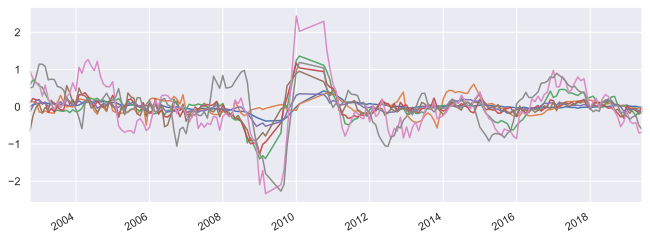

In [25]:
# ADF Test
merge2_diff = merge2.copy()

[index_remove2,merge2_differenced]=ADF_Test(merge2_diff)
index_remove2
merge2_differenced

#### 4.2.1 Forecast the spread for [SP500-ACWI ex USA]

In [26]:
# Grangers Causation Test
[causation_matrix,index_remove,merge2_tested] = causation_test(merge2_differenced,0)
causation_matrix
index_remove
merge2_tested

            SP500-ACWI ex USA    PAYEMS   DSPIC96    INDPRO  CMRMTSPL  \
2002-10-01           3.073344  0.004206  0.147638  0.594417  0.110698   
2002-11-01           0.865385  0.055747  0.131342  0.721922  0.219846   
2002-12-01          -2.929204  0.076576  0.139069  0.653793  0.187226   
2003-01-01           0.803645  0.099263 -0.139311  0.558220  0.185118   
2003-02-01           0.351309  0.111199 -0.159950  0.520974  0.068662   
2003-03-01           2.863060  0.097305 -0.113320  0.346765  0.126198   
2003-04-01          -1.315927  0.088249 -0.151563  0.193963 -0.154515   
2003-05-01          -1.130339  0.084787 -0.163442  0.074919 -0.044556   
2003-06-01          -1.549900  0.071424 -0.175391 -0.118949 -0.135476   
2003-07-01          -1.003121  0.075028  0.099308 -0.090106  0.005881   
2003-08-01          -1.146842  0.063512  0.305734 -0.114520 -0.088260   
2003-09-01          -3.943516  0.064845  0.137041 -0.120675 -0.088042   
2003-10-01          -0.923415  0.041608 -0.007681 -

SP500-ACWI ex USA_x  PAYEMS_x  DSPIC96_x  INDPRO_x  \
SP500-ACWI ex USA_y               1.0000    0.3362     0.0356    0.2822   
PAYEMS_y                          0.0041    1.0000     0.4327    0.0000   
DSPIC96_y                         0.1596    0.0660     1.0000    0.1283   
INDPRO_y                          0.0289    0.0000     0.6947    1.0000   
CMRMTSPL_y                        0.0204    0.0018     0.0216    0.0012   
PCE_y                             0.0002    0.1343     0.0008    0.0001   
RRSFS_y                           0.0023    0.0737     0.0000    0.0000   
S423SMM144SCEN_y                  0.0199    0.0233     0.5054    0.0000   
PPIACO_y                          0.0001    0.2581     0.0292    0.0000   

                     CMRMTSPL_x   PCE_x  RRSFS_x  S423SMM144SCEN_x  PPIACO_x  
SP500-ACWI ex USA_y      0.4894  0.3313   0.6836            0.2792    0.0790  
PAYEMS_y                 0.0000  0.0000   0.0000            0.0000    0.0000  
DSPIC96_y                0.0030  0.0002   0.0000            0.0400    0.0159  
INDPRO_y                 0.0016  0.0183   0.0016            0.0002    0.0000  
CMRMTSPL_y               1.0000  0.0106   0.0018            0.0004    0.0000  
PCE_y                    0.0000  1.0000   0.0011            0.0057    0.0000  
RRSFS_y                  0.0003  0.0749   1.0000            0.0010    0.0000  
S423SMM144SCEN_y         0.0007  0.0002   0.0000            1.0000    0.0000  
PPIACO_y                 0.0000  0.0020   0.0001            0.0563    1.0000

[2, 4, 5, 6, 7, 8, 9]

SP500-ACWI ex USA  SP500-EAFE   DSPIC96
2002-10-01           3.073344    3.056363  0.147638
2002-11-01           0.865385    1.111491  0.131342
2002-12-01          -2.929204   -2.802643  0.139069
2003-01-01           0.803645    1.484666 -0.139311
2003-02-01           0.351309    0.606749 -0.159950
2003-03-01           2.863060    2.816638 -0.113320
2003-04-01          -1.315927   -1.557381 -0.151563
2003-05-01          -1.130339   -0.918217 -0.163442
2003-06-01          -1.549900   -1.262002 -0.175391
2003-07-01          -1.003121   -0.782466  0.099308
2003-08-01          -1.146842   -0.614686  0.305734
2003-09-01          -3.943516   -4.237714  0.137041
2003-10-01          -0.923415   -0.695939 -0.007681
2003-11-01          -1.431610   -1.488539  0.014362
2003-12-01          -2.399238   -2.570411 -0.012750
2004-01-01           0.134022    0.308726  0.142816
2004-02-01          -1.278922   -1.068684  0.207337
2004-03-01          -2.223979   -2.210518  0.198603
2004-04-01           1.539649    0.594733  0.175951
2004-05-01           0.972669    0.865415  0.122251
2004-06-01          -0.321996   -0.384448  0.098532
2004-07-01          -0.511821   -0.190041 -0.110267
2004-08-01          -0.543693   -0.212167 -0.199733
2004-09-01          -2.217515   -1.647963  0.009624
2004-10-01          -2.021052   -1.961425 -0.026069
2004-11-01          -2.898286   -2.821222 -0.128237
2004-12-01          -1.002109   -1.098537  0.180742
2005-01-01          -0.809420   -0.709824 -0.108001
2005-02-01          -2.916108   -2.357492 -0.155212
2005-03-01           0.857202    0.614029 -0.172507
...                       ...         ...       ...
2017-01-01          -1.708501   -1.086877 -0.055815
2017-02-01           2.070558    2.232490 -0.014403
2017-03-01          -2.542670   -2.754588 -0.013215
2017-04-01          -1.212849   -1.607647  0.051418
2017-05-01          -2.042723   -2.453668  0.132718
2017-06-01           0.170341    0.657243  0.138756
2017-07-01          -1.703286   -0.927366  0.135844
2017-08-01          -0.467001    0.092321  0.149686
2017-09-01           0.072564   -0.545699  0.142135
2017-10-01           0.330533    0.687503  0.144583
2017-11-01           1.960533    1.726092  0.123598
2017-12-01          -1.232209   -0.614011  0.166386
2018-01-01           0.045902    0.571539  0.179005
2018-02-01           0.857244    0.646025  0.143896
2018-03-01          -0.945594   -0.906450  0.098867
2018-04-01          -1.312700   -1.986079  0.104738
2018-05-01           4.473996    4.411265  0.040590
2018-06-01           2.380531    1.712320  0.082971
2018-07-01           1.175291    1.107076  0.083943
2018-08-01           5.096612    4.931576  0.094578
2018-09-01          -0.025948   -0.435625  0.072990
2018-10-01           1.290743    1.100899  0.049359
2018-11-01           0.828146    1.896268  0.027598
2018-12-01          -4.994920   -4.650366  0.044217
2019-01-01           0.290283    1.209142 -0.063097
2019-02-01           0.994662    0.412375 -0.037030
2019-03-01           1.182602    1.147955 -0.038243
2019-04-01           1.248543    1.083302 -0.054531
2019-05-01          -1.287370   -1.882346 -0.032088
2019-06-01           0.818567    0.902598 -0.063172

[185 rows x 3 columns]

In [27]:
# Train Set = 95%
[df2_train,df2_test,df2_forecast] = VAR_Model(merge2_tested,0,0.05)
df2_forecast 
df2_test

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     09:51:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.15607
Nobs:                     174.000    HQIC:                  -2.22081
Log likelihood:          -290.735    FPE:                   0.103831
AIC:                     -2.26500    Det(Omega_mle):        0.100341
--------------------------------------------------------------------
Results for equation SP500-ACWI ex USA
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.042370         0.177141            0.239           0.811
L1.SP500-ACWI ex USA         0.155164         0.076022            2.041           0.041
L1.DSPIC96          

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SP500-ACWI ex USA_forecast  DSPIC96_forecast
2018-09-01                    0.751470          0.080635
2018-10-01                    0.089306          0.063353
2018-11-01                    0.001493          0.049195
2018-12-01                    0.000100          0.038296
2019-01-01                    0.009300          0.030007
2019-02-01                    0.017888          0.023719
2019-03-01                    0.024653          0.018952
2019-04-01                    0.029822          0.015338
2019-05-01                    0.033746          0.012598
2019-06-01                    0.036722          0.010521

SP500-ACWI ex USA   DSPIC96
2018-09-01          -0.025948  0.072990
2018-10-01           1.290743  0.049359
2018-11-01           0.828146  0.027598
2018-12-01          -4.994920  0.044217
2019-01-01           0.290283 -0.063097
2019-02-01           0.994662 -0.037030
2019-03-01           1.182602 -0.038243
2019-04-01           1.248543 -0.054531
2019-05-01          -1.287370 -0.032088
2019-06-01           0.818567 -0.063172

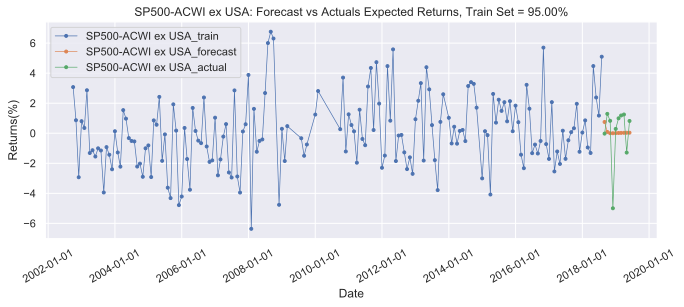

In [28]:
forecast_plot(df2_forecast,df2_train,df2_test,95)

#### 4.2.2 Forecast the spread for [SP500-EAFE]

In [29]:
[causation_matrix,index_remove,merge2_tested_EAFE] = causation_test(merge2_differenced,1)
causation_matrix
index_remove
merge2_tested_EAFE

            SP500-EAFE    PAYEMS   DSPIC96    INDPRO  CMRMTSPL       PCE  \
2002-10-01    3.056363  0.004206  0.147638  0.594417  0.110698 -0.125535   
2002-11-01    1.111491  0.055747  0.131342  0.721922  0.219846  0.017991   
2002-12-01   -2.802643  0.076576  0.139069  0.653793  0.187226  0.176248   
2003-01-01    1.484666  0.099263 -0.139311  0.558220  0.185118  0.174294   
2003-02-01    0.606749  0.111199 -0.159950  0.520974  0.068662  0.097911   
2003-03-01    2.816638  0.097305 -0.113320  0.346765  0.126198  0.113742   
2003-04-01   -1.557381  0.088249 -0.151563  0.193963 -0.154515 -0.001987   
2003-05-01   -0.918217  0.084787 -0.163442  0.074919 -0.044556  0.112097   
2003-06-01   -1.262002  0.071424 -0.175391 -0.118949 -0.135476  0.102105   
2003-07-01   -0.782466  0.075028  0.099308 -0.090106  0.005881  0.039042   
2003-08-01   -0.614686  0.063512  0.305734 -0.114520 -0.088260  0.137660   
2003-09-01   -4.237714  0.064845  0.137041 -0.120675 -0.088042  0.048432   
2003-10-01  

SP500-EAFE_x  PAYEMS_x  DSPIC96_x  INDPRO_x  CMRMTSPL_x  \
SP500-EAFE_y            1.0000    0.1403     0.0541    0.1574      0.2148   
PAYEMS_y                0.0075    1.0000     0.4327    0.0000      0.0000   
DSPIC96_y               0.1575    0.0660     1.0000    0.1283      0.0030   
INDPRO_y                0.0628    0.0000     0.6947    1.0000      0.0016   
CMRMTSPL_y              0.1059    0.0018     0.0216    0.0012      1.0000   
PCE_y                   0.0024    0.1343     0.0008    0.0001      0.0000   
RRSFS_y                 0.0171    0.0737     0.0000    0.0000      0.0003   
S423SMM144SCEN_y        0.0386    0.0233     0.5054    0.0000      0.0007   
PPIACO_y                0.0031    0.2581     0.0292    0.0000      0.0000   

                   PCE_x  RRSFS_x  S423SMM144SCEN_x  PPIACO_x  
SP500-EAFE_y      0.3069   0.6790            0.1003    0.0898  
PAYEMS_y          0.0000   0.0000            0.0000    0.0000  
DSPIC96_y         0.0002   0.0000            0.0400    0.0159  
INDPRO_y          0.0183   0.0016            0.0002    0.0000  
CMRMTSPL_y        0.0106   0.0018            0.0004    0.0000  
PCE_y             1.0000   0.0011            0.0057    0.0000  
RRSFS_y           0.0749   1.0000            0.0010    0.0000  
S423SMM144SCEN_y  0.0002   0.0000            1.0000    0.0000  
PPIACO_y          0.0020   0.0001            0.0563    1.0000

[2, 4, 5, 6, 7, 8, 9]

SP500-ACWI ex USA  SP500-EAFE   DSPIC96
2002-10-01           3.073344    3.056363  0.147638
2002-11-01           0.865385    1.111491  0.131342
2002-12-01          -2.929204   -2.802643  0.139069
2003-01-01           0.803645    1.484666 -0.139311
2003-02-01           0.351309    0.606749 -0.159950
2003-03-01           2.863060    2.816638 -0.113320
2003-04-01          -1.315927   -1.557381 -0.151563
2003-05-01          -1.130339   -0.918217 -0.163442
2003-06-01          -1.549900   -1.262002 -0.175391
2003-07-01          -1.003121   -0.782466  0.099308
2003-08-01          -1.146842   -0.614686  0.305734
2003-09-01          -3.943516   -4.237714  0.137041
2003-10-01          -0.923415   -0.695939 -0.007681
2003-11-01          -1.431610   -1.488539  0.014362
2003-12-01          -2.399238   -2.570411 -0.012750
2004-01-01           0.134022    0.308726  0.142816
2004-02-01          -1.278922   -1.068684  0.207337
2004-03-01          -2.223979   -2.210518  0.198603
2004-04-01           1.539649    0.594733  0.175951
2004-05-01           0.972669    0.865415  0.122251
2004-06-01          -0.321996   -0.384448  0.098532
2004-07-01          -0.511821   -0.190041 -0.110267
2004-08-01          -0.543693   -0.212167 -0.199733
2004-09-01          -2.217515   -1.647963  0.009624
2004-10-01          -2.021052   -1.961425 -0.026069
2004-11-01          -2.898286   -2.821222 -0.128237
2004-12-01          -1.002109   -1.098537  0.180742
2005-01-01          -0.809420   -0.709824 -0.108001
2005-02-01          -2.916108   -2.357492 -0.155212
2005-03-01           0.857202    0.614029 -0.172507
...                       ...         ...       ...
2017-01-01          -1.708501   -1.086877 -0.055815
2017-02-01           2.070558    2.232490 -0.014403
2017-03-01          -2.542670   -2.754588 -0.013215
2017-04-01          -1.212849   -1.607647  0.051418
2017-05-01          -2.042723   -2.453668  0.132718
2017-06-01           0.170341    0.657243  0.138756
2017-07-01          -1.703286   -0.927366  0.135844
2017-08-01          -0.467001    0.092321  0.149686
2017-09-01           0.072564   -0.545699  0.142135
2017-10-01           0.330533    0.687503  0.144583
2017-11-01           1.960533    1.726092  0.123598
2017-12-01          -1.232209   -0.614011  0.166386
2018-01-01           0.045902    0.571539  0.179005
2018-02-01           0.857244    0.646025  0.143896
2018-03-01          -0.945594   -0.906450  0.098867
2018-04-01          -1.312700   -1.986079  0.104738
2018-05-01           4.473996    4.411265  0.040590
2018-06-01           2.380531    1.712320  0.082971
2018-07-01           1.175291    1.107076  0.083943
2018-08-01           5.096612    4.931576  0.094578
2018-09-01          -0.025948   -0.435625  0.072990
2018-10-01           1.290743    1.100899  0.049359
2018-11-01           0.828146    1.896268  0.027598
2018-12-01          -4.994920   -4.650366  0.044217
2019-01-01           0.290283    1.209142 -0.063097
2019-02-01           0.994662    0.412375 -0.037030
2019-03-01           1.182602    1.147955 -0.038243
2019-04-01           1.248543    1.083302 -0.054531
2019-05-01          -1.287370   -1.882346 -0.032088
2019-06-01           0.818567    0.902598 -0.063172

[185 rows x 3 columns]

In [30]:
# Train Set = 95%
[df2_train_EAFE,df2_test_EAFE,df2_forecast_EAFE] = VAR_Model(merge2_tested_EAFE,1,0.05)
df2_forecast_EAFE 
df2_test_EAFE

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     09:51:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.25462
Nobs:                     174.000    HQIC:                  -2.31936
Log likelihood:          -282.161    FPE:                  0.0940859
AIC:                     -2.36355    Det(Omega_mle):       0.0909236
--------------------------------------------------------------------
Results for equation SP500-EAFE
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.060060         0.168777            0.356           0.722
L1.SP500-EAFE         0.093526         0.076535            1.222           0.222
L1.DSPIC96           -0.942471         0.814547        

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SP500-EAFE_forecast  DSPIC96_forecast
2018-09-01             0.432154          0.079276
2018-10-01             0.025763          0.061699
2018-11-01             0.004320          0.047803
2018-12-01             0.015411          0.037213
2019-01-01             0.026429          0.029179
2019-02-01             0.035032          0.023087
2019-03-01             0.041577          0.018469
2019-04-01             0.046542          0.014967
2019-05-01             0.050307          0.012313
2019-06-01             0.053161          0.010300

SP500-EAFE   DSPIC96
2018-09-01   -0.435625  0.072990
2018-10-01    1.100899  0.049359
2018-11-01    1.896268  0.027598
2018-12-01   -4.650366  0.044217
2019-01-01    1.209142 -0.063097
2019-02-01    0.412375 -0.037030
2019-03-01    1.147955 -0.038243
2019-04-01    1.083302 -0.054531
2019-05-01   -1.882346 -0.032088
2019-06-01    0.902598 -0.063172

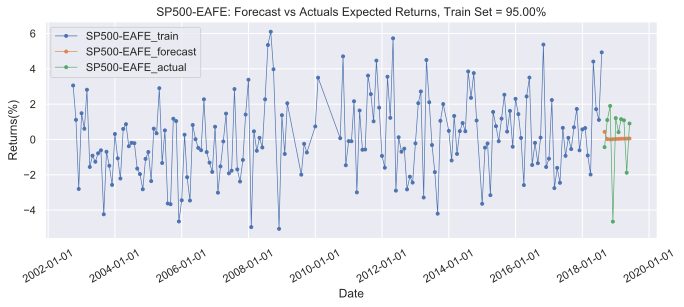

In [31]:
forecast_plot(df2_forecast_EAFE,df2_train_EAFE,df2_test_EAFE,95)

### 4.3 Lagging Indicators

* Gross Domestic Product (A191RP1Q027SBEA)
* Consumer Price Index: Total All Items for the United States (CPALTT01USQ657N)
* Manufacturers: Inventories to Sales Ratio (MNFCTRIRSA)
* Civilian Unemployment Rate (UNRATE)
* Effective Federal Funds Rate (FEDFUNDS)
* Nonfarm Business Sector: Unit Labor Cost (ULCNFB)

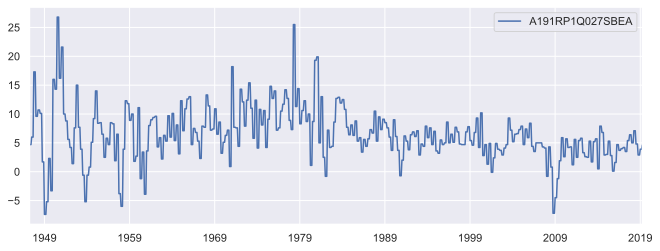

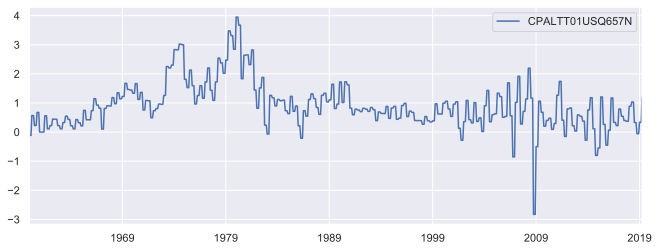

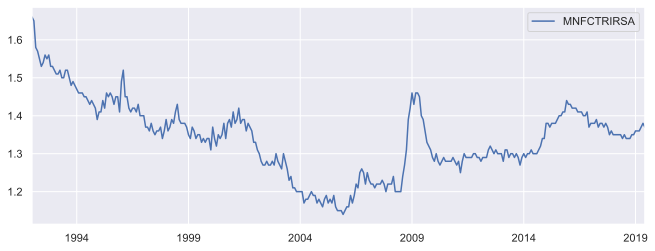

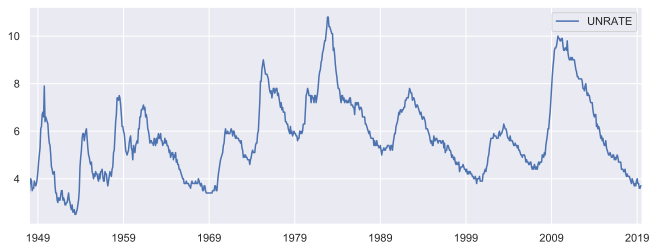

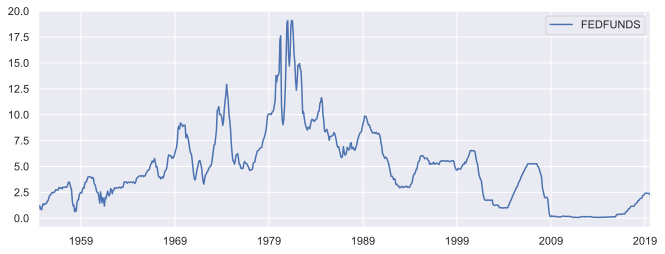

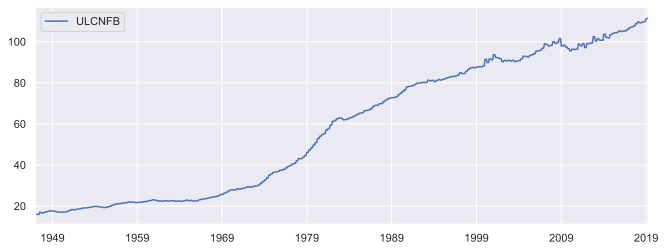

In [32]:
lagging_fred = ['A191RP1Q027SBEA','CPALTT01USQ657N','MNFCTRIRSA','UNRATE','FEDFUNDS','ULCNFB']
lagging_df = {}
for i in range(0,len(lagging_fred)):
    data = fred.get_series(lagging_fred[i]).dropna()
    data_series = pd.DataFrame(data,columns=[lagging_fred[i]])
    data_series = data_series.asfreq(freq='MS',method='ffill')
    data_series.plot()
#     data_series
    lagging_df[lagging_fred[i]] = data_series

In [33]:
# Eliminate Seasonality
for i in range(0,len(lagging_fred)):
    lagging_df[lagging_fred[i]] = lagging_df[lagging_fred[i]].diff(periods=12).dropna()

# Merge all Indicators and Indices
merge3 = Merge(lagging_df,lagging_fred)
merge3

SP500-ACWI ex USA  SP500-EAFE  A191RP1Q027SBEA  CPALTT01USQ657N  \
Date                                                                          
2002-10-01           3.073344    3.056363              0.5         0.595036   
2002-11-01           0.865385    1.111491              0.5         0.595036   
2002-12-01          -2.929204   -2.802643              0.5         0.595036   
2003-01-01           0.803645    1.484666             -0.8         0.654682   
2003-02-01           0.351309    0.606749             -0.8         0.654682   
2003-03-01           2.863060    2.816638             -0.8         0.654682   
2003-04-01          -1.315927   -1.557381              0.8        -0.722454   
2003-05-01          -1.130339   -0.918217              0.8        -0.722454   
2003-06-01          -1.549900   -1.262002              0.8        -0.722454   
2003-07-01          -1.003121   -0.782466              5.6         0.063697   
2003-08-01          -1.146842   -0.614686              5.6         0.063697   
2003-09-01          -3.943516   -4.237714              5.6         0.063697   
2003-10-01          -0.923415   -0.695939              4.3        -0.295709   
2003-11-01          -1.431610   -1.488539              4.3        -0.295709   
2003-12-01          -2.399238   -2.570411              4.3        -0.295709   
2004-01-01           0.134022    0.308726              1.1        -0.109107   
2004-02-01          -1.278922   -1.068684              1.1        -0.109107   
2004-03-01          -2.223979   -2.210518              1.1        -0.109107   
2004-04-01           1.539649    0.594733              1.8         1.067341   
2004-05-01           0.972669    0.865415              1.8         1.067341   
2004-06-01          -0.321996   -0.384448              1.8         1.067341   
2004-07-01          -0.511821   -0.190041             -2.7        -0.137160   
2004-08-01          -0.543693   -0.212167             -2.7        -0.137160   
2004-09-01          -2.217515   -1.647963             -2.7        -0.137160   
2004-10-01          -2.021052   -1.961425              0.1         0.579689   
2004-11-01          -2.898286   -2.821222              0.1         0.579689   
2004-12-01          -1.002109   -1.098537              0.1         0.579689   
2005-01-01          -0.809420   -0.709824              2.7        -0.273702   
2005-02-01          -2.916108   -2.357492              2.7        -0.273702   
2005-03-01           0.857202    0.614029              2.7        -0.273702   
...                       ...         ...              ...              ...   
2016-11-01           5.700507    5.372053              3.9         0.672418   
2016-12-01          -0.722398   -1.558560              3.9         0.672418   
2017-01-01          -1.708501   -1.086877              2.6         0.726103   
2017-02-01           2.070558    2.232490              2.6         0.726103   
2017-03-01          -2.542670   -2.754588              2.6         0.726103   
2017-04-01          -1.212849   -1.607647             -1.2        -0.628833   
2017-05-01          -2.042723   -2.453668             -1.2        -0.628833   
2017-06-01           0.170341    0.657243             -1.2        -0.628833   
2017-07-01          -1.703286   -0.927366              1.7         0.063934   
2017-08-01          -0.467001    0.092321              1.7         0.063934   
2017-09-01           0.072564   -0.545699              1.7         0.063934   
2017-10-01           0.330533    0.687503              2.4         0.148055   
2017-11-01           1.960533    1.726092              2.4         0.148055   
2017-12-01          -1.232209   -0.614011              2.4         0.148055   
2018-01-01           0.045902    0.571539              0.8         0.095381   
2018-02-01           0.857244    0.646025              0.8         0.095381   
2018-03-01          -0.945594   -0.906450              0.8         0.095381   
2018-04-01          -1.312700   -1.986079              3.6    

0
0
0
1
0
1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


[]

SP500-ACWI ex USA  SP500-EAFE  A191RP1Q027SBEA  CPALTT01USQ657N  \
Date                                                                          
2002-12-01          -2.929204   -2.802643              0.5         0.595036   
2003-01-01           0.803645    1.484666             -0.8         0.654682   
2003-02-01           0.351309    0.606749             -0.8         0.654682   
2003-03-01           2.863060    2.816638             -0.8         0.654682   
2003-04-01          -1.315927   -1.557381              0.8        -0.722454   
2003-05-01          -1.130339   -0.918217              0.8        -0.722454   
2003-06-01          -1.549900   -1.262002              0.8        -0.722454   
2003-07-01          -1.003121   -0.782466              5.6         0.063697   
2003-08-01          -1.146842   -0.614686              5.6         0.063697   
2003-09-01          -3.943516   -4.237714              5.6         0.063697   
2003-10-01          -0.923415   -0.695939              4.3        -0.295709   
2003-11-01          -1.431610   -1.488539              4.3        -0.295709   
2003-12-01          -2.399238   -2.570411              4.3        -0.295709   
2004-01-01           0.134022    0.308726              1.1        -0.109107   
2004-02-01          -1.278922   -1.068684              1.1        -0.109107   
2004-03-01          -2.223979   -2.210518              1.1        -0.109107   
2004-04-01           1.539649    0.594733              1.8         1.067341   
2004-05-01           0.972669    0.865415              1.8         1.067341   
2004-06-01          -0.321996   -0.384448              1.8         1.067341   
2004-07-01          -0.511821   -0.190041             -2.7        -0.137160   
2004-08-01          -0.543693   -0.212167             -2.7        -0.137160   
2004-09-01          -2.217515   -1.647963             -2.7        -0.137160   
2004-10-01          -2.021052   -1.961425              0.1         0.579689   
2004-11-01          -2.898286   -2.821222              0.1         0.579689   
2004-12-01          -1.002109   -1.098537              0.1         0.579689   
2005-01-01          -0.809420   -0.709824              2.7        -0.273702   
2005-02-01          -2.916108   -2.357492              2.7        -0.273702   
2005-03-01           0.857202    0.614029              2.7        -0.273702   
2005-04-01           0.566197    0.347771             -1.8        -0.094369   
2005-05-01           2.420680    2.902898             -1.8        -0.094369   
...                       ...         ...              ...              ...   
2016-11-01           5.700507    5.372053              3.9         0.672418   
2016-12-01          -0.722398   -1.558560              3.9         0.672418   
2017-01-01          -1.708501   -1.086877              2.6         0.726103   
2017-02-01           2.070558    2.232490              2.6         0.726103   
2017-03-01          -2.542670   -2.754588              2.6         0.726103   
2017-04-01          -1.212849   -1.607647             -1.2        -0.628833   
2017-05-01          -2.042723   -2.453668             -1.2        -0.628833   
2017-06-01           0.170341    0.657243             -1.2        -0.628833   
2017-07-01          -1.703286   -0.927366              1.7         0.063934   
2017-08-01          -0.467001    0.092321              1.7         0.063934   
2017-09-01           0.072564   -0.545699              1.7         0.063934   
2017-10-01           0.330533    0.687503              2.4         0.148055   
2017-11-01           1.960533    1.726092              2.4         0.148055   
2017-12-01          -1.232209   -0.614011              2.4         0.148055   
2018-01-01           0.045902    0.571539              0.8         0.095381   
2018-02-01           0.857244    0.646025              0.8         0.095381   
2018-03-01          -0.945594   -0.906450              0.8         0.095381   
2018-04-01          -1.312700   -1.986079              3.6    

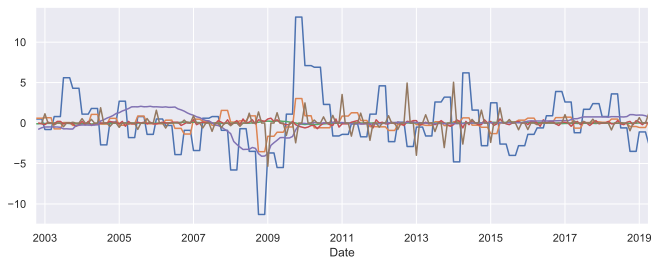

In [34]:
# ADF Test: test whether the series is stationary or not, take the difference if not stationary
merge3_diff = merge3.copy()

[index_remove3,merge3_differenced]=ADF_Test(merge3_diff)
index_remove3
merge3_differenced

#### 4.3.1 Forecast the spread for [SP500-ACWI ex USA]

In [35]:
# Grangers Causation Test
[causation_matrix,index_remove,merge3_tested] = causation_test(merge3_differenced,0)
causation_matrix
index_remove
merge3_tested

            SP500-ACWI ex USA  A191RP1Q027SBEA  CPALTT01USQ657N  MNFCTRIRSA  \
Date                                                                          
2002-12-01          -2.929204              0.5         0.595036       -0.03   
2003-01-01           0.803645             -0.8         0.654682       -0.05   
2003-02-01           0.351309             -0.8         0.654682       -0.04   
2003-03-01           2.863060             -0.8         0.654682       -0.04   
2003-04-01          -1.315927              0.8        -0.722454        0.02   
2003-05-01          -1.130339              0.8        -0.722454        0.01   
2003-06-01          -1.549900              0.8        -0.722454       -0.01   
2003-07-01          -1.003121              5.6         0.063697       -0.05   
2003-08-01          -1.146842              5.6         0.063697       -0.03   
2003-09-01          -3.943516              5.6         0.063697       -0.06   
2003-10-01          -0.923415              4.3      

SP500-ACWI ex USA_x  A191RP1Q027SBEA_x  \
SP500-ACWI ex USA_y               1.0000             0.0288   
A191RP1Q027SBEA_y                 0.0002             1.0000   
CPALTT01USQ657N_y                 0.0006             0.1267   
MNFCTRIRSA_y                      0.0005             0.0000   
UNRATE_y                          0.0000             0.0000   
FEDFUNDS_y                        0.0000             0.0015   
ULCNFB_y                          0.0004             0.0003   

                     CPALTT01USQ657N_x  MNFCTRIRSA_x  UNRATE_x  FEDFUNDS_x  \
SP500-ACWI ex USA_y             0.0029        0.0898    0.0137       0.071   
A191RP1Q027SBEA_y               0.0958        0.0000    0.0001       0.000   
CPALTT01USQ657N_y               1.0000        0.0000    0.0001       0.000   
MNFCTRIRSA_y                    0.0000        1.0000    0.0004       0.000   
UNRATE_y                        0.0001        0.0000    1.0000       0.000   
FEDFUNDS_y                      0.0000        0.0080    0.0299       1.000   
ULCNFB_y                        0.0160        0.0010    0.0000       0.012   

                     ULCNFB_x  
SP500-ACWI ex USA_y    0.0585  
A191RP1Q027SBEA_y      0.0000  
CPALTT01USQ657N_y      0.6843  
MNFCTRIRSA_y           0.1075  
UNRATE_y               0.0000  
FEDFUNDS_y             0.0091  
ULCNFB_y               1.0000

[4, 6, 7]

SP500-ACWI ex USA  SP500-EAFE  A191RP1Q027SBEA  CPALTT01USQ657N  \
Date                                                                          
2002-12-01          -2.929204   -2.802643              0.5         0.595036   
2003-01-01           0.803645    1.484666             -0.8         0.654682   
2003-02-01           0.351309    0.606749             -0.8         0.654682   
2003-03-01           2.863060    2.816638             -0.8         0.654682   
2003-04-01          -1.315927   -1.557381              0.8        -0.722454   
2003-05-01          -1.130339   -0.918217              0.8        -0.722454   
2003-06-01          -1.549900   -1.262002              0.8        -0.722454   
2003-07-01          -1.003121   -0.782466              5.6         0.063697   
2003-08-01          -1.146842   -0.614686              5.6         0.063697   
2003-09-01          -3.943516   -4.237714              5.6         0.063697   
2003-10-01          -0.923415   -0.695939              4.3        -0.295709   
2003-11-01          -1.431610   -1.488539              4.3        -0.295709   
2003-12-01          -2.399238   -2.570411              4.3        -0.295709   
2004-01-01           0.134022    0.308726              1.1        -0.109107   
2004-02-01          -1.278922   -1.068684              1.1        -0.109107   
2004-03-01          -2.223979   -2.210518              1.1        -0.109107   
2004-04-01           1.539649    0.594733              1.8         1.067341   
2004-05-01           0.972669    0.865415              1.8         1.067341   
2004-06-01          -0.321996   -0.384448              1.8         1.067341   
2004-07-01          -0.511821   -0.190041             -2.7        -0.137160   
2004-08-01          -0.543693   -0.212167             -2.7        -0.137160   
2004-09-01          -2.217515   -1.647963             -2.7        -0.137160   
2004-10-01          -2.021052   -1.961425              0.1         0.579689   
2004-11-01          -2.898286   -2.821222              0.1         0.579689   
2004-12-01          -1.002109   -1.098537              0.1         0.579689   
2005-01-01          -0.809420   -0.709824              2.7        -0.273702   
2005-02-01          -2.916108   -2.357492              2.7        -0.273702   
2005-03-01           0.857202    0.614029              2.7        -0.273702   
2005-04-01           0.566197    0.347771             -1.8        -0.094369   
2005-05-01           2.420680    2.902898             -1.8        -0.094369   
...                       ...         ...              ...              ...   
2016-11-01           5.700507    5.372053              3.9         0.672418   
2016-12-01          -0.722398   -1.558560              3.9         0.672418   
2017-01-01          -1.708501   -1.086877              2.6         0.726103   
2017-02-01           2.070558    2.232490              2.6         0.726103   
2017-03-01          -2.542670   -2.754588              2.6         0.726103   
2017-04-01          -1.212849   -1.607647             -1.2        -0.628833   
2017-05-01          -2.042723   -2.453668             -1.2        -0.628833   
2017-06-01           0.170341    0.657243             -1.2        -0.628833   
2017-07-01          -1.703286   -0.927366              1.7         0.063934   
2017-08-01          -0.467001    0.092321              1.7         0.063934   
2017-09-01           0.072564   -0.545699              1.7         0.063934   
2017-10-01           0.330533    0.687503              2.4         0.148055   
2017-11-01           1.960533    1.726092              2.4         0.148055   
2017-12-01          -1.232209   -0.614011              2.4         0.148055   
2018-01-01           0.045902    0.571539              0.8         0.095381   
2018-02-01           0.857244    0.646025              0.8         0.095381   
2018-03-01          -0.945594   -0.906450              0.8         0.095381   
2018-04-01          -1.312700   -1.986079              3.6    

In [36]:
# Train Set = 95%
[df3_train,df3_test,df3_forecast] = VAR_Model(merge3_tested,0,0.05)
df3_forecast 
df3_test

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     09:52:03
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.319858
Nobs:                     182.000    HQIC:                 -0.559442
Log likelihood:          -843.526    FPE:                   0.315125
AIC:                     -1.15891    Det(Omega_mle):        0.203603
--------------------------------------------------------------------
Results for equation SP500-ACWI ex USA
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.028091         0.172524           -0.163           0.871
L1.SP500-ACWI ex USA         0.138567         0.078787            1.759           0.079
L1.A191RP1Q027SBEA  

SP500-ACWI ex USA_forecast  A191RP1Q027SBEA_forecast  \
Date                                                               
2018-07-01                    0.425080                  1.202209   
2018-08-01                    1.637636                 -0.190155   
2018-09-01                    1.464510                 -0.347134   
2018-10-01                    0.237961                 -0.830542   
2018-11-01                   -0.256475                 -0.929424   
2018-12-01                   -0.743889                 -0.329748   
2019-01-01                   -0.874784                  0.259775   
2019-02-01                   -0.417854                  0.384695   
2019-03-01                   -0.441369                  0.201780   
2019-04-01                   -0.340681                 -0.071047   

            CPALTT01USQ657N_forecast  UNRATE_forecast  
Date                                                   
2018-07-01                 -0.048483        -0.162425  
2018-08-01                 -0.426476        -0.068652  
2018-09-01                 -0.437364        -0.018792  
2018-10-01                 -0.828015        -0.063240  
2018-11-01                 -0.926373         0.076095  
2018-12-01                 -0.644978         0.021933  
2019-01-01                 -0.338390         0.039532  
2019-02-01                 -0.147683         0.043579  
2019-03-01                 -0.050840        -0.010674  
2019-04-01                  0.008800        -0.008938

SP500-ACWI ex USA  A191RP1Q027SBEA  CPALTT01USQ657N  UNRATE
Date                                                                   
2018-07-01           1.175291             -0.6        -0.069348    -0.1
2018-08-01           5.096612             -0.6        -0.069348    -0.2
2018-09-01          -0.025948             -0.6        -0.069348     0.1
2018-10-01           1.290743             -3.5        -0.428124     0.2
2018-11-01           0.828146             -3.5        -0.428124    -0.2
2018-12-01          -4.994920             -3.5        -0.428124     0.3
2019-01-01           0.290283             -1.1        -0.551002     0.1
2019-02-01           0.994662             -1.1        -0.551002    -0.2
2019-03-01           1.182602             -1.1        -0.551002     0.1
2019-04-01           1.248543             -2.5         0.165438    -0.1

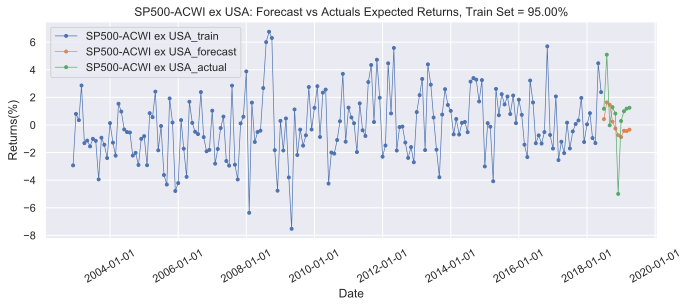

In [37]:
forecast_plot(df3_forecast,df3_train,df3_test,95)

#### 4.3.2 Forecast the spread for [SP500-EAFE]

In [38]:
[causation_matrix,index_remove,merge3_tested_EAFE] = causation_test(merge3_differenced,1)
causation_matrix
index_remove
merge3_tested_EAFE

            SP500-EAFE  A191RP1Q027SBEA  CPALTT01USQ657N  MNFCTRIRSA  \
Date                                                                   
2002-12-01   -2.802643              0.5         0.595036       -0.03   
2003-01-01    1.484666             -0.8         0.654682       -0.05   
2003-02-01    0.606749             -0.8         0.654682       -0.04   
2003-03-01    2.816638             -0.8         0.654682       -0.04   
2003-04-01   -1.557381              0.8        -0.722454        0.02   
2003-05-01   -0.918217              0.8        -0.722454        0.01   
2003-06-01   -1.262002              0.8        -0.722454       -0.01   
2003-07-01   -0.782466              5.6         0.063697       -0.05   
2003-08-01   -0.614686              5.6         0.063697       -0.03   
2003-09-01   -4.237714              5.6         0.063697       -0.06   
2003-10-01   -0.695939              4.3        -0.295709       -0.07   
2003-11-01   -1.488539              4.3        -0.295709       -

SP500-EAFE_x  A191RP1Q027SBEA_x  CPALTT01USQ657N_x  \
SP500-EAFE_y             1.0000             0.0254             0.0057   
A191RP1Q027SBEA_y        0.0006             1.0000             0.0958   
CPALTT01USQ657N_y        0.0046             0.1267             1.0000   
MNFCTRIRSA_y             0.0007             0.0000             0.0000   
UNRATE_y                 0.0000             0.0000             0.0001   
FEDFUNDS_y               0.0007             0.0015             0.0000   
ULCNFB_y                 0.0003             0.0003             0.0160   

                   MNFCTRIRSA_x  UNRATE_x  FEDFUNDS_x  ULCNFB_x  
SP500-EAFE_y             0.3015    0.0765      0.0531    0.1946  
A191RP1Q027SBEA_y        0.0000    0.0001      0.0000    0.0000  
CPALTT01USQ657N_y        0.0000    0.0001      0.0000    0.6843  
MNFCTRIRSA_y             1.0000    0.0004      0.0000    0.1075  
UNRATE_y                 0.0000    1.0000      0.0000    0.0000  
FEDFUNDS_y               0.0080    0.0299      1.0000    0.0091  
ULCNFB_y                 0.0010    0.0000      0.0120    1.0000

[4, 5, 7]

SP500-ACWI ex USA  SP500-EAFE  A191RP1Q027SBEA  CPALTT01USQ657N  \
Date                                                                          
2002-12-01          -2.929204   -2.802643              0.5         0.595036   
2003-01-01           0.803645    1.484666             -0.8         0.654682   
2003-02-01           0.351309    0.606749             -0.8         0.654682   
2003-03-01           2.863060    2.816638             -0.8         0.654682   
2003-04-01          -1.315927   -1.557381              0.8        -0.722454   
2003-05-01          -1.130339   -0.918217              0.8        -0.722454   
2003-06-01          -1.549900   -1.262002              0.8        -0.722454   
2003-07-01          -1.003121   -0.782466              5.6         0.063697   
2003-08-01          -1.146842   -0.614686              5.6         0.063697   
2003-09-01          -3.943516   -4.237714              5.6         0.063697   
2003-10-01          -0.923415   -0.695939              4.3        -0.295709   
2003-11-01          -1.431610   -1.488539              4.3        -0.295709   
2003-12-01          -2.399238   -2.570411              4.3        -0.295709   
2004-01-01           0.134022    0.308726              1.1        -0.109107   
2004-02-01          -1.278922   -1.068684              1.1        -0.109107   
2004-03-01          -2.223979   -2.210518              1.1        -0.109107   
2004-04-01           1.539649    0.594733              1.8         1.067341   
2004-05-01           0.972669    0.865415              1.8         1.067341   
2004-06-01          -0.321996   -0.384448              1.8         1.067341   
2004-07-01          -0.511821   -0.190041             -2.7        -0.137160   
2004-08-01          -0.543693   -0.212167             -2.7        -0.137160   
2004-09-01          -2.217515   -1.647963             -2.7        -0.137160   
2004-10-01          -2.021052   -1.961425              0.1         0.579689   
2004-11-01          -2.898286   -2.821222              0.1         0.579689   
2004-12-01          -1.002109   -1.098537              0.1         0.579689   
2005-01-01          -0.809420   -0.709824              2.7        -0.273702   
2005-02-01          -2.916108   -2.357492              2.7        -0.273702   
2005-03-01           0.857202    0.614029              2.7        -0.273702   
2005-04-01           0.566197    0.347771             -1.8        -0.094369   
2005-05-01           2.420680    2.902898             -1.8        -0.094369   
...                       ...         ...              ...              ...   
2016-11-01           5.700507    5.372053              3.9         0.672418   
2016-12-01          -0.722398   -1.558560              3.9         0.672418   
2017-01-01          -1.708501   -1.086877              2.6         0.726103   
2017-02-01           2.070558    2.232490              2.6         0.726103   
2017-03-01          -2.542670   -2.754588              2.6         0.726103   
2017-04-01          -1.212849   -1.607647             -1.2        -0.628833   
2017-05-01          -2.042723   -2.453668             -1.2        -0.628833   
2017-06-01           0.170341    0.657243             -1.2        -0.628833   
2017-07-01          -1.703286   -0.927366              1.7         0.063934   
2017-08-01          -0.467001    0.092321              1.7         0.063934   
2017-09-01           0.072564   -0.545699              1.7         0.063934   
2017-10-01           0.330533    0.687503              2.4         0.148055   
2017-11-01           1.960533    1.726092              2.4         0.148055   
2017-12-01          -1.232209   -0.614011              2.4         0.148055   
2018-01-01           0.045902    0.571539              0.8         0.095381   
2018-02-01           0.857244    0.646025              0.8         0.095381   
2018-03-01          -0.945594   -0.906450              0.8         0.095381   
2018-04-01          -1.312700   -1.986079              3.6    

In [39]:
# Train Set = 95%
[df3_train_EAFE,df3_test_EAFE,df3_forecast_EAFE] = VAR_Model(merge3_tested_EAFE,1,0.05)
df3_forecast_EAFE 
df3_test_EAFE

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     09:52:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                  -0.353048
Nobs:                     181.000    HQIC:                  -1.40374
Log likelihood:          -735.436    FPE:                   0.120867
AIC:                     -2.12017    Det(Omega_mle):       0.0720365
--------------------------------------------------------------------
Results for equation SP500-EAFE
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.019414         0.167657           -0.116           0.908
L1.SP500-EAFE              0.075161         0.080793            0.930           0.352
L1.A191RP1Q027SBEA         0.057452

SP500-EAFE_forecast  A191RP1Q027SBEA_forecast  \
Date                                                        
2018-07-01            -0.506153                  1.395093   
2018-08-01             0.723979                  0.297371   
2018-09-01             0.354885                  1.273724   
2018-10-01             0.140198                  1.121703   
2018-11-01            -0.076593                  0.477593   
2018-12-01            -0.360297                 -0.196949   
2019-01-01            -0.078072                 -0.617962   
2019-02-01             0.047360                 -0.619553   
2019-03-01            -0.191844                 -0.508713   
2019-04-01            -0.187404                 -0.815138   

            CPALTT01USQ657N_forecast  FEDFUNDS_forecast  
Date                                                     
2018-07-01                  0.258697           0.747159  
2018-08-01                  0.114773           0.644162  
2018-09-01                  0.263531           0.604578  
2018-10-01                 -0.017671           0.568296  
2018-11-01                 -0.131857           0.473494  
2018-12-01                 -0.149748           0.422604  
2019-01-01                 -0.114891           0.376066  
2019-02-01                 -0.057052           0.334358  
2019-03-01                 -0.030169           0.302862  
2019-04-01                 -0.038303           0.252708

SP500-EAFE  A191RP1Q027SBEA  CPALTT01USQ657N  FEDFUNDS
Date                                                              
2018-07-01    1.107076             -0.6        -0.069348      0.76
2018-08-01    4.931576             -0.6        -0.069348      0.75
2018-09-01   -0.435625             -0.6        -0.069348      0.80
2018-10-01    1.100899             -3.5        -0.428124      1.04
2018-11-01    1.896268             -3.5        -0.428124      1.04
2018-12-01   -4.650366             -3.5        -0.428124      0.97
2019-01-01    1.209142             -1.1        -0.551002      0.99
2019-02-01    0.412375             -1.1        -0.551002      0.98
2019-03-01    1.147955             -1.1        -0.551002      0.90
2019-04-01    1.083302             -2.5         0.165438      0.73

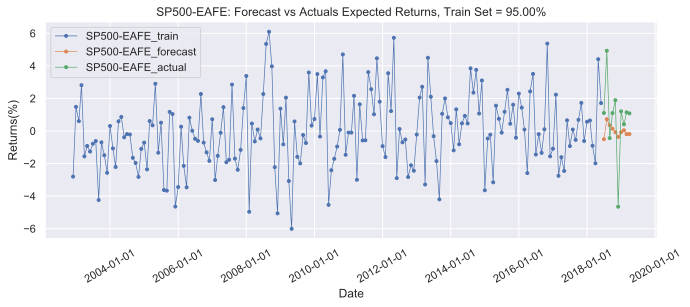

In [40]:
forecast_plot(df3_forecast_EAFE,df3_train_EAFE,df3_test_EAFE,95)

## Part Two: Global Indices VS Spread

### 5.1 Leading Indicators

* CCI_OECD

CCI_OECD
Date                
2015-01-01   0.69323
2015-02-01   0.75575
2015-03-01   0.72092
2015-04-01   0.62111
2015-05-01   0.52240
2015-06-01   0.47134
2015-07-01   0.39816
2015-08-01   0.32383
2015-09-01   0.27356
2015-10-01   0.33295
2015-11-01   0.38703
2015-12-01   0.27540
2016-01-01   0.04480
2016-02-01  -0.15910
2016-03-01  -0.25060
2016-04-01  -0.23710
2016-05-01  -0.11810
2016-06-01  -0.06970
2016-07-01  -0.02640
2016-08-01   0.05670
2016-09-01   0.11850
2016-10-01   0.03270
2016-11-01  -0.05380
2016-12-01  -0.04270
2017-01-01   0.04070
2017-02-01   0.17730
2017-03-01   0.31180
2017-04-01   0.38800
2017-05-01   0.38160
2017-06-01   0.38990
2017-07-01   0.46560
2017-08-01   0.51930
2017-09-01   0.54790
2017-10-01   0.60200
2017-11-01   0.55960
2017-12-01   0.49140
2018-01-01   0.49670
2018-02-01   0.51720
2018-03-01   0.46270
2018-04-01   0.35430
2018-05-01   0.26980
2018-06-01   0.24160
2018-07-01   0.21220
2018-08-01   0.10780
2018-09-01  -0.01390
2018-10-01  -0.17500
2018-11-01  -0.28920
2018-12-01  -0.37220
2019-01-01  -0.45330
2019-02-01  -0.44690
2019-03-01  -0.38580
2019-04-01  -0.33410
2019-05-01  -0.33180
2019-06-01  -0.38040
2019-07-01  -0.40760

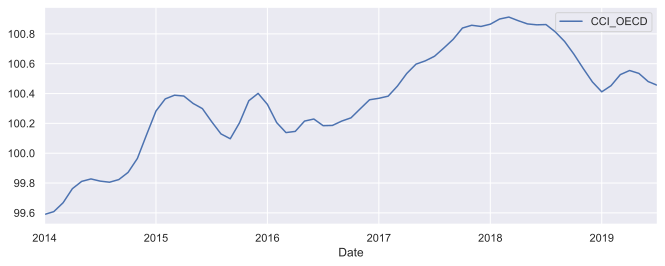

In [41]:
# indicators from OECD downloaded data
def OECD_Month(df,colname):
    df = df.drop(['LOCATION'],axis=1).rename(columns={'TIME':'Date','Value':colname})
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.asfreq(freq='MS',method='bfill')
    df.plot()
    return df
CCI = pd.read_csv("CCI.csv",usecols=[0,5,6])
CCI_OECD = CCI[CCI.LOCATION =='OECD'].reset_index(drop=True)
CCI_OECD = OECD_Month(CCI_OECD,'CCI_OECD')
# Eliminate seasonal effect
CCI_OECD = CCI_OECD.diff(periods=12).dropna()
CCI_OECD

In [42]:
merge4 = pd.concat([spread,CCI_OECD],join='inner',axis=1)
merge4

SP500-ACWI ex USA  SP500-EAFE  CCI_OECD
Date                                               
2015-01-01          -3.004995   -3.640927   0.69323
2015-02-01           0.135426   -0.462329   0.75575
2015-03-01          -0.125220   -0.224149   0.72092
2015-04-01          -4.079729   -3.153287   0.62111
2015-05-01           2.617151    1.556872   0.52240
2015-06-01           0.706198    0.750702   0.47134
2015-07-01           2.233196   -0.100101   0.39816
2015-08-01           1.488714    1.178442   0.32383
2015-09-01           2.067780    2.531146   0.27356
2015-10-01           0.791724    0.445470   0.33295
2015-11-01           2.136231    1.618398   0.38703
2015-12-01           0.132934   -0.411995   0.27540
2016-01-01           1.837809    2.299425   0.04480
2016-02-01           0.735844    1.435377  -0.15910
2016-03-01          -1.426814    0.086686  -0.25060
2016-04-01          -2.327833   -2.584420  -0.23710
2016-05-01           3.222917    2.433400  -0.11810
2016-06-01           1.632994    3.505440  -0.06970
2016-07-01          -1.328101   -1.444793  -0.02640
2016-08-01          -0.752520   -0.192963   0.05670
2016-09-01          -1.348740   -1.344472   0.11850
2016-10-01          -0.513472    0.105013   0.03270
2016-11-01           5.700507    5.372053  -0.05380
2016-12-01          -0.722398   -1.558560  -0.04270
2017-01-01          -1.708501   -1.086877   0.04070
2017-02-01           2.070558    2.232490   0.17730
2017-03-01          -2.542670   -2.754588   0.31180
2017-04-01          -1.212849   -1.607647   0.38800
2017-05-01          -2.042723   -2.453668   0.38160
2017-06-01           0.170341    0.657243   0.38990
2017-07-01          -1.703286   -0.927366   0.46560
2017-08-01          -0.467001    0.092321   0.51930
2017-09-01           0.072564   -0.545699   0.54790
2017-10-01           0.330533    0.687503   0.60200
2017-11-01           1.960533    1.726092   0.55960
2017-12-01          -1.232209   -0.614011   0.49140
2018-01-01           0.045902    0.571539   0.49670
2018-02-01           0.857244    0.646025   0.51720
2018-03-01          -0.945594   -0.906450   0.46270
2018-04-01          -1.312700   -1.986079   0.35430
2018-05-01           4.473996    4.411265   0.26980
2018-06-01           2.380531    1.712320   0.24160
2018-07-01           1.175291    1.107076   0.21220
2018-08-01           5.096612    4.931576   0.10780
2018-09-01          -0.025948   -0.435625  -0.01390
2018-10-01           1.290743    1.100899  -0.17500
2018-11-01           0.828146    1.896268  -0.28920
2018-12-01          -4.994920   -4.650366  -0.37220
2019-01-01           0.290283    1.209142  -0.45330
2019-02-01           0.994662    0.412375  -0.44690
2019-03-01           1.182602    1.147955  -0.38580
2019-04-01           1.248543    1.083302  -0.33410
2019-05-01          -1.287370   -1.882346  -0.33180
2019-06-01           0.818567    0.902598  -0.38040
2019-07-01           2.521947    2.582091  -0.40760

0


[]

SP500-ACWI ex USA  SP500-EAFE  CCI_OECD
Date                                               
2015-01-01          -3.004995   -3.640927   0.69323
2015-02-01           0.135426   -0.462329   0.75575
2015-03-01          -0.125220   -0.224149   0.72092
2015-04-01          -4.079729   -3.153287   0.62111
2015-05-01           2.617151    1.556872   0.52240
2015-06-01           0.706198    0.750702   0.47134
2015-07-01           2.233196   -0.100101   0.39816
2015-08-01           1.488714    1.178442   0.32383
2015-09-01           2.067780    2.531146   0.27356
2015-10-01           0.791724    0.445470   0.33295
2015-11-01           2.136231    1.618398   0.38703
2015-12-01           0.132934   -0.411995   0.27540
2016-01-01           1.837809    2.299425   0.04480
2016-02-01           0.735844    1.435377  -0.15910
2016-03-01          -1.426814    0.086686  -0.25060
2016-04-01          -2.327833   -2.584420  -0.23710
2016-05-01           3.222917    2.433400  -0.11810
2016-06-01           1.632994    3.505440  -0.06970
2016-07-01          -1.328101   -1.444793  -0.02640
2016-08-01          -0.752520   -0.192963   0.05670
2016-09-01          -1.348740   -1.344472   0.11850
2016-10-01          -0.513472    0.105013   0.03270
2016-11-01           5.700507    5.372053  -0.05380
2016-12-01          -0.722398   -1.558560  -0.04270
2017-01-01          -1.708501   -1.086877   0.04070
2017-02-01           2.070558    2.232490   0.17730
2017-03-01          -2.542670   -2.754588   0.31180
2017-04-01          -1.212849   -1.607647   0.38800
2017-05-01          -2.042723   -2.453668   0.38160
2017-06-01           0.170341    0.657243   0.38990
2017-07-01          -1.703286   -0.927366   0.46560
2017-08-01          -0.467001    0.092321   0.51930
2017-09-01           0.072564   -0.545699   0.54790
2017-10-01           0.330533    0.687503   0.60200
2017-11-01           1.960533    1.726092   0.55960
2017-12-01          -1.232209   -0.614011   0.49140
2018-01-01           0.045902    0.571539   0.49670
2018-02-01           0.857244    0.646025   0.51720
2018-03-01          -0.945594   -0.906450   0.46270
2018-04-01          -1.312700   -1.986079   0.35430
2018-05-01           4.473996    4.411265   0.26980
2018-06-01           2.380531    1.712320   0.24160
2018-07-01           1.175291    1.107076   0.21220
2018-08-01           5.096612    4.931576   0.10780
2018-09-01          -0.025948   -0.435625  -0.01390
2018-10-01           1.290743    1.100899  -0.17500
2018-11-01           0.828146    1.896268  -0.28920
2018-12-01          -4.994920   -4.650366  -0.37220
2019-01-01           0.290283    1.209142  -0.45330
2019-02-01           0.994662    0.412375  -0.44690
2019-03-01           1.182602    1.147955  -0.38580
2019-04-01           1.248543    1.083302  -0.33410
2019-05-01          -1.287370   -1.882346  -0.33180
2019-06-01           0.818567    0.902598  -0.38040
2019-07-01           2.521947    2.582091  -0.40760

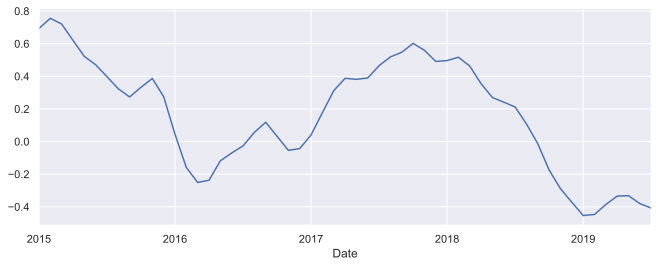

In [43]:
# ADF Test
merge4_diff = merge4.copy()

[index_remove4,merge4_differenced]=ADF_Test(merge4_diff)
index_remove4
merge4_differenced

#### 5.1.1 Forecast the spread for [SP500-ACWI ex USA]

In [44]:
# Grangers Causation Test
[causation_matrix,index_remove,merge4_tested] = causation_test(merge4_differenced,0)
causation_matrix
index_remove
merge4_tested

            SP500-ACWI ex USA  CCI_OECD
Date                                   
2015-01-01          -3.004995   0.69323
2015-02-01           0.135426   0.75575
2015-03-01          -0.125220   0.72092
2015-04-01          -4.079729   0.62111
2015-05-01           2.617151   0.52240
2015-06-01           0.706198   0.47134
2015-07-01           2.233196   0.39816
2015-08-01           1.488714   0.32383
2015-09-01           2.067780   0.27356
2015-10-01           0.791724   0.33295
2015-11-01           2.136231   0.38703
2015-12-01           0.132934   0.27540
2016-01-01           1.837809   0.04480
2016-02-01           0.735844  -0.15910
2016-03-01          -1.426814  -0.25060
2016-04-01          -2.327833  -0.23710
2016-05-01           3.222917  -0.11810
2016-06-01           1.632994  -0.06970
2016-07-01          -1.328101  -0.02640
2016-08-01          -0.752520   0.05670
2016-09-01          -1.348740   0.11850
2016-10-01          -0.513472   0.03270
2016-11-01           5.700507  -0.05380


SP500-ACWI ex USA_x  CCI_OECD_x
SP500-ACWI ex USA_y               1.0000         0.0
CCI_OECD_y                        0.0028         1.0

[]

SP500-ACWI ex USA  SP500-EAFE  CCI_OECD
Date                                               
2015-01-01          -3.004995   -3.640927   0.69323
2015-02-01           0.135426   -0.462329   0.75575
2015-03-01          -0.125220   -0.224149   0.72092
2015-04-01          -4.079729   -3.153287   0.62111
2015-05-01           2.617151    1.556872   0.52240
2015-06-01           0.706198    0.750702   0.47134
2015-07-01           2.233196   -0.100101   0.39816
2015-08-01           1.488714    1.178442   0.32383
2015-09-01           2.067780    2.531146   0.27356
2015-10-01           0.791724    0.445470   0.33295
2015-11-01           2.136231    1.618398   0.38703
2015-12-01           0.132934   -0.411995   0.27540
2016-01-01           1.837809    2.299425   0.04480
2016-02-01           0.735844    1.435377  -0.15910
2016-03-01          -1.426814    0.086686  -0.25060
2016-04-01          -2.327833   -2.584420  -0.23710
2016-05-01           3.222917    2.433400  -0.11810
2016-06-01           1.632994    3.505440  -0.06970
2016-07-01          -1.328101   -1.444793  -0.02640
2016-08-01          -0.752520   -0.192963   0.05670
2016-09-01          -1.348740   -1.344472   0.11850
2016-10-01          -0.513472    0.105013   0.03270
2016-11-01           5.700507    5.372053  -0.05380
2016-12-01          -0.722398   -1.558560  -0.04270
2017-01-01          -1.708501   -1.086877   0.04070
2017-02-01           2.070558    2.232490   0.17730
2017-03-01          -2.542670   -2.754588   0.31180
2017-04-01          -1.212849   -1.607647   0.38800
2017-05-01          -2.042723   -2.453668   0.38160
2017-06-01           0.170341    0.657243   0.38990
2017-07-01          -1.703286   -0.927366   0.46560
2017-08-01          -0.467001    0.092321   0.51930
2017-09-01           0.072564   -0.545699   0.54790
2017-10-01           0.330533    0.687503   0.60200
2017-11-01           1.960533    1.726092   0.55960
2017-12-01          -1.232209   -0.614011   0.49140
2018-01-01           0.045902    0.571539   0.49670
2018-02-01           0.857244    0.646025   0.51720
2018-03-01          -0.945594   -0.906450   0.46270
2018-04-01          -1.312700   -1.986079   0.35430
2018-05-01           4.473996    4.411265   0.26980
2018-06-01           2.380531    1.712320   0.24160
2018-07-01           1.175291    1.107076   0.21220
2018-08-01           5.096612    4.931576   0.10780
2018-09-01          -0.025948   -0.435625  -0.01390
2018-10-01           1.290743    1.100899  -0.17500
2018-11-01           0.828146    1.896268  -0.28920
2018-12-01          -4.994920   -4.650366  -0.37220
2019-01-01           0.290283    1.209142  -0.45330
2019-02-01           0.994662    0.412375  -0.44690
2019-03-01           1.182602    1.147955  -0.38580
2019-04-01           1.248543    1.083302  -0.33410
2019-05-01          -1.287370   -1.882346  -0.33180
2019-06-01           0.818567    0.902598  -0.38040
2019-07-01           2.521947    2.582091  -0.40760

In [45]:
# Train Set = 95%
[df4_train,df4_test,df4_forecast] = VAR_Model(merge4_tested,0,0.05)
df4_forecast 
df4_test

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     09:53:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.45547
Nobs:                     47.0000    HQIC:                  -3.99560
Log likelihood:          -9.82515    FPE:                  0.0135169
AIC:                     -4.32149    Det(Omega_mle):      0.00887599
--------------------------------------------------------------------
Results for equation SP500-ACWI ex USA
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.011591         0.423568            0.027           0.978
L1.SP500-ACWI ex USA        -0.045798         0.158930           -0.288           0.773
L1.CCI_OECD         

SP500-ACWI ex USA_forecast  CCI_OECD_forecast
Date                                                     
2019-05-01                    0.341348          -0.245390
2019-06-01                   -1.217016          -0.148224
2019-07-01                   -1.798018          -0.085802

SP500-ACWI ex USA  CCI_OECD
Date                                   
2019-05-01          -1.287370   -0.3318
2019-06-01           0.818567   -0.3804
2019-07-01           2.521947   -0.4076

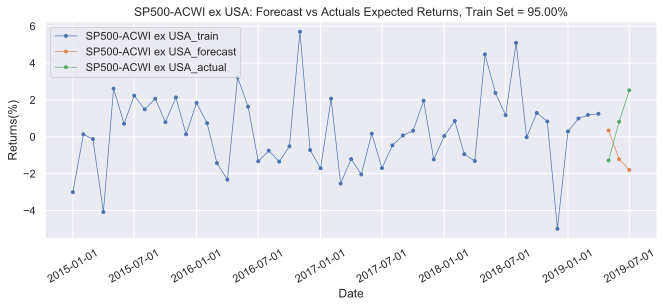

In [46]:
forecast_plot(df4_forecast,df4_train,df4_test,95)

#### 5.1.2 Forecast the spread for [SP500-EAFE]

In [47]:
[causation_matrix,index_remove,merge4_tested_EAFE] = causation_test(merge4_differenced,1)
causation_matrix
index_remove
merge4_tested_EAFE

            SP500-EAFE  CCI_OECD
Date                            
2015-01-01   -3.640927   0.69323
2015-02-01   -0.462329   0.75575
2015-03-01   -0.224149   0.72092
2015-04-01   -3.153287   0.62111
2015-05-01    1.556872   0.52240
2015-06-01    0.750702   0.47134
2015-07-01   -0.100101   0.39816
2015-08-01    1.178442   0.32383
2015-09-01    2.531146   0.27356
2015-10-01    0.445470   0.33295
2015-11-01    1.618398   0.38703
2015-12-01   -0.411995   0.27540
2016-01-01    2.299425   0.04480
2016-02-01    1.435377  -0.15910
2016-03-01    0.086686  -0.25060
2016-04-01   -2.584420  -0.23710
2016-05-01    2.433400  -0.11810
2016-06-01    3.505440  -0.06970
2016-07-01   -1.444793  -0.02640
2016-08-01   -0.192963   0.05670
2016-09-01   -1.344472   0.11850
2016-10-01    0.105013   0.03270
2016-11-01    5.372053  -0.05380
2016-12-01   -1.558560  -0.04270
2017-01-01   -1.086877   0.04070
2017-02-01    2.232490   0.17730
2017-03-01   -2.754588   0.31180
2017-04-01   -1.607647   0.38800
2017-05-01

SP500-EAFE_x  CCI_OECD_x
SP500-EAFE_y        1.0000      0.0005
CCI_OECD_y          0.0001      1.0000

[]

SP500-ACWI ex USA  SP500-EAFE  CCI_OECD
Date                                               
2015-01-01          -3.004995   -3.640927   0.69323
2015-02-01           0.135426   -0.462329   0.75575
2015-03-01          -0.125220   -0.224149   0.72092
2015-04-01          -4.079729   -3.153287   0.62111
2015-05-01           2.617151    1.556872   0.52240
2015-06-01           0.706198    0.750702   0.47134
2015-07-01           2.233196   -0.100101   0.39816
2015-08-01           1.488714    1.178442   0.32383
2015-09-01           2.067780    2.531146   0.27356
2015-10-01           0.791724    0.445470   0.33295
2015-11-01           2.136231    1.618398   0.38703
2015-12-01           0.132934   -0.411995   0.27540
2016-01-01           1.837809    2.299425   0.04480
2016-02-01           0.735844    1.435377  -0.15910
2016-03-01          -1.426814    0.086686  -0.25060
2016-04-01          -2.327833   -2.584420  -0.23710
2016-05-01           3.222917    2.433400  -0.11810
2016-06-01           1.632994    3.505440  -0.06970
2016-07-01          -1.328101   -1.444793  -0.02640
2016-08-01          -0.752520   -0.192963   0.05670
2016-09-01          -1.348740   -1.344472   0.11850
2016-10-01          -0.513472    0.105013   0.03270
2016-11-01           5.700507    5.372053  -0.05380
2016-12-01          -0.722398   -1.558560  -0.04270
2017-01-01          -1.708501   -1.086877   0.04070
2017-02-01           2.070558    2.232490   0.17730
2017-03-01          -2.542670   -2.754588   0.31180
2017-04-01          -1.212849   -1.607647   0.38800
2017-05-01          -2.042723   -2.453668   0.38160
2017-06-01           0.170341    0.657243   0.38990
2017-07-01          -1.703286   -0.927366   0.46560
2017-08-01          -0.467001    0.092321   0.51930
2017-09-01           0.072564   -0.545699   0.54790
2017-10-01           0.330533    0.687503   0.60200
2017-11-01           1.960533    1.726092   0.55960
2017-12-01          -1.232209   -0.614011   0.49140
2018-01-01           0.045902    0.571539   0.49670
2018-02-01           0.857244    0.646025   0.51720
2018-03-01          -0.945594   -0.906450   0.46270
2018-04-01          -1.312700   -1.986079   0.35430
2018-05-01           4.473996    4.411265   0.26980
2018-06-01           2.380531    1.712320   0.24160
2018-07-01           1.175291    1.107076   0.21220
2018-08-01           5.096612    4.931576   0.10780
2018-09-01          -0.025948   -0.435625  -0.01390
2018-10-01           1.290743    1.100899  -0.17500
2018-11-01           0.828146    1.896268  -0.28920
2018-12-01          -4.994920   -4.650366  -0.37220
2019-01-01           0.290283    1.209142  -0.45330
2019-02-01           0.994662    0.412375  -0.44690
2019-03-01           1.182602    1.147955  -0.38580
2019-04-01           1.248543    1.083302  -0.33410
2019-05-01          -1.287370   -1.882346  -0.33180
2019-06-01           0.818567    0.902598  -0.38040
2019-07-01           2.521947    2.582091  -0.40760

In [48]:
# Train Set = 95%
[df4_train_EAFE,df4_test_EAFE,df4_forecast_EAFE] = VAR_Model(merge4_tested_EAFE,1,0.05)
df4_forecast_EAFE 
df4_test_EAFE

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     09:53:43
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.62470
Nobs:                     48.0000    HQIC:                  -4.06123
Log likelihood:          -14.3845    FPE:                  0.0133342
AIC:                     -4.32640    Det(Omega_mle):      0.00945584
--------------------------------------------------------------------
Results for equation SP500-EAFE
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.385265         0.397770            0.969           0.333
L1.SP500-EAFE        -0.121227         0.151439           -0.801           0.423
L1.CCI_OECD          -9.127743         5.841925        

SP500-EAFE_forecast  CCI_OECD_forecast
Date                                              
2019-05-01            -0.263262          -0.302116
2019-06-01            -0.092918          -0.268831
2019-07-01            -0.136761          -0.219289

SP500-EAFE  CCI_OECD
Date                            
2019-05-01   -1.882346   -0.3318
2019-06-01    0.902598   -0.3804
2019-07-01    2.582091   -0.4076

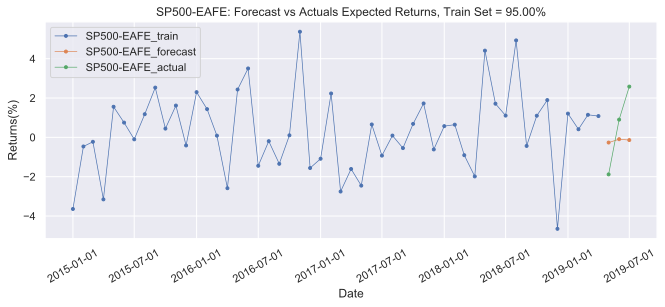

In [49]:
forecast_plot(df4_forecast_EAFE,df4_train_EAFE,df4_test_EAFE,95)

### 5.2 Coincident Indicators

* Producer Prices Index: Total Consumer Goods for the Euro Area (PITGCG01EZM661N)
* Total Retail Trade (OECD Total)
* Production of Total Industry (OECD Total)

PPI_Euro
2000-01-01      81.6
2000-02-01      81.9
2000-03-01      82.0
2000-04-01      82.2
2000-05-01      82.5
2000-06-01      82.6
2000-07-01      82.9
2000-08-01      83.1
2000-09-01      83.4
2000-10-01      83.6
2000-11-01      83.8
2000-12-01      83.9
2001-01-01      84.2
2001-02-01      84.6
2001-03-01      85.0
2001-04-01      85.3
2001-05-01      85.4
2001-06-01      85.6
2001-07-01      85.7
2001-08-01      85.6
2001-09-01      85.5
2001-10-01      85.5
2001-11-01      85.5
2001-12-01      85.6
2002-01-01      85.8
2002-02-01      85.8
2002-03-01      86.0
2002-04-01      86.0
2002-05-01      86.0
2002-06-01      85.9
...              ...
2017-01-01     101.0
2017-02-01     101.1
2017-03-01     101.1
2017-04-01     101.6
2017-05-01     101.7
2017-06-01     101.7
2017-07-01     101.7
2017-08-01     101.7
2017-09-01     101.7
2017-10-01     101.6
2017-11-01     101.4
2017-12-01     101.4
2018-01-01     101.2
2018-02-01     101.0
2018-03-01     101.0
2018-04-01     101.0
2018-05-01     101.0
2018-06-01     101.0
2018-07-01     100.9
2018-08-01     100.9
2018-09-01     100.8
2018-10-01     100.8
2018-11-01     100.9
2018-12-01     100.9
2019-01-01     101.0
2019-02-01     101.1
2019-03-01     101.2
2019-04-01     101.4
2019-05-01     101.5
2019-06-01     101.6

[234 rows x 1 columns]

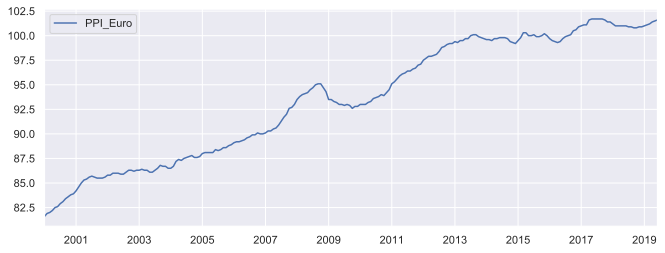

In [50]:
# Monthly Data
PPI_Euro = fred.get_series('PITGCG01EZM661N').dropna()
PPI_Euro = pd.DataFrame(PPI_Euro,columns=['PPI_Euro']).asfreq(freq='MS',method='bfill')
PPI_Euro.plot()
PPI_Euro
PPI_Euro = PPI_Euro.diff(periods=12).dropna()

C:\ProgramData\Anaconda3\lib\site-packages\pandasdmx\writer\data2pandas.py:124: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  d_frame = PD.concat(list(pd_series), axis=1, copy=False)


retail_trade
Date                    
1971-01-01       2.05460
1971-02-01       2.09187
1971-03-01       2.44833
1971-04-01       3.08063
1971-05-01       2.28762
1971-06-01       2.33528
1971-07-01       2.04932
1971-08-01       2.14708
1971-09-01       2.80954
1971-10-01       2.95419
1971-11-01       3.51473
1971-12-01       2.21546
1972-01-01       2.17222
1972-02-01       1.94425
1972-03-01       2.88956
1972-04-01       1.63648
1972-05-01       2.56399
1972-06-01       2.49373
1972-07-01       2.71403
1972-08-01       3.23228
1972-09-01       2.75641
1972-10-01       2.68422
1972-11-01       2.65864
1972-12-01       4.17277
1973-01-01       4.38253
1973-02-01       5.07041
1973-03-01       4.01656
1973-04-01       3.86458
1973-05-01       2.71320
1973-06-01       3.10242
...                  ...
2017-01-01       2.23530
2017-02-01       2.03270
2017-03-01       2.46300
2017-04-01       2.62460
2017-05-01       2.22530
2017-06-01       2.26020
2017-07-01       1.93330
2017-08-01       1.83340
2017-09-01       2.91480
2017-10-01       1.73080
2017-11-01       3.16760
2017-12-01       2.66040
2018-01-01       2.04910
2018-02-01       2.11920
2018-03-01       2.33680
2018-04-01       2.04620
2018-05-01       2.97770
2018-06-01       2.56580
2018-07-01       2.53690
2018-08-01       2.80940
2018-09-01       1.50590
2018-10-01       2.39080
2018-11-01       1.89680
2018-12-01       0.45340
2019-01-01       1.72650
2019-02-01       1.44880
2019-03-01       2.08450
2019-04-01       1.85890
2019-05-01       1.15560
2019-06-01       1.80580

[582 rows x 1 columns]

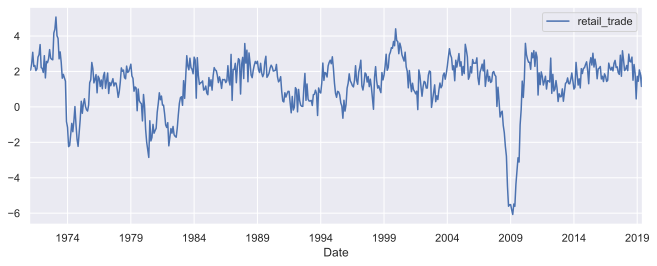

In [52]:
# Get OECD Data through API (not so stable),
# might need to rerun the cell to get the result
def OECD_API_M(df,colname):
    df = df.rename(columns={'index':'Date','M':colname})
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.asfreq(freq='MS',method='bfill')
    df = df.diff(periods=12).dropna()
    df.plot()
    return df

oecd = pandasdmx.Request('OECD')
data_response = oecd.data(resource_id='MEI_REAL')
retail_trade = data_response.write(data_response.data.series, parse_time=False)
retail_trade = retail_trade['SLRTTO01']['OECD']['M'].dropna()
retail_trade = retail_trade.reset_index()

retail_trade = OECD_API_M(retail_trade,'retail_trade')
retail_trade

industry_production
Date                           
1976-01-01              1.39705
1976-02-01              2.35386
1976-03-01              2.71172
1976-04-01              3.48753
1976-05-01              3.97053
1976-06-01              3.83950
1976-07-01              3.87385
1976-08-01              3.67011
1976-09-01              3.87121
1976-10-01              3.53334
1976-11-01              3.85906
1976-12-01              3.63586
1977-01-01              3.40326
1977-02-01              2.90801
1977-03-01              2.92768
1977-04-01              2.57885
1977-05-01              2.11731
1977-06-01              2.13179
1977-07-01              1.74768
1977-08-01              1.99897
1977-09-01              1.71192
1977-10-01              1.61783
1977-11-01              1.15530
1977-12-01              1.30957
1978-01-01              0.96064
1978-02-01              0.79423
1978-03-01              0.90087
1978-04-01              1.78888
1978-05-01              1.62082
1978-06-01              1.66024
...                         ...
2016-12-01              2.07272
2017-01-01              0.88680
2017-02-01              1.44130
2017-03-01              2.34949
2017-04-01              2.79930
2017-05-01              3.40613
2017-06-01              2.92670
2017-07-01              3.62010
2017-08-01              3.45430
2017-09-01              3.46820
2017-10-01              3.34320
2017-11-01              3.72860
2017-12-01              4.18740
2018-01-01              3.08300
2018-02-01              3.37700
2018-03-01              3.34440
2018-04-01              2.77140
2018-05-01              2.79950
2018-06-01              2.78140
2018-07-01              2.50500
2018-08-01              2.51110
2018-09-01              2.19170
2018-10-01              2.28470
2018-11-01              0.61830
2018-12-01             -0.18640
2019-01-01              0.92780
2019-02-01              0.42170
2019-03-01              0.32690
2019-04-01             -0.00130
2019-05-01              0.68260

[521 rows x 1 columns]

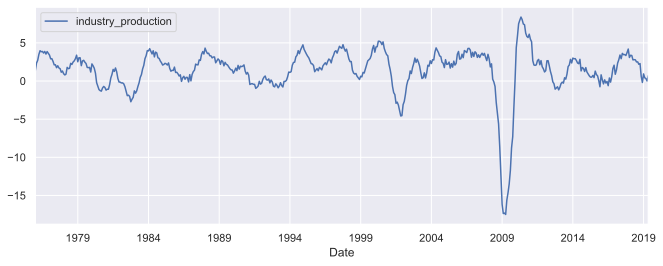

In [53]:
data_response = oecd.data(resource_id='MEI_REAL')
industry_production = data_response.write(data_response.data.series, parse_time=False)
industry_production = industry_production['PRINTO01']['OECD']['M'].dropna()
industry_production = industry_production.reset_index()
industry_production = OECD_API_M(industry_production,'industry_production')
industry_production

In [54]:
merge5 = pd.concat([spread,PPI_Euro,retail_trade,industry_production],join='inner',axis=1)
merge5

SP500-ACWI ex USA  SP500-EAFE  PPI_Euro  retail_trade  \
Date                                                                
2002-10-01           3.073344    3.056363       0.8      -0.02766   
2002-11-01           0.865385    1.111491       0.7       0.38458   
2002-12-01          -2.929204   -2.802643       0.7       0.79210   
2003-01-01           0.803645    1.484666       0.5       1.24183   
2003-02-01           0.351309    0.606749       0.6       0.29569   
2003-03-01           2.863060    2.816638       0.3       0.62376   
2003-04-01          -1.315927   -1.557381       0.3       0.41647   
2003-05-01          -1.130339   -0.918217       0.1       0.95801   
2003-06-01          -1.549900   -1.262002       0.2       1.34549   
2003-07-01          -1.003121   -0.782466       0.4       1.07792   
2003-08-01          -1.146842   -0.614686       0.4       1.20372   
2003-09-01          -3.943516   -4.237714       0.5       1.77791   
2003-10-01          -0.923415   -0.695939       0.4       1.91264   
2003-11-01          -1.431610   -1.488539       0.5       1.56190   
2003-12-01          -2.399238   -2.570411       0.2       1.89094   
2004-01-01           0.134022    0.308726       0.2       2.30543   
2004-02-01          -1.278922   -1.068684       0.3       2.82545   
2004-03-01          -2.223979   -2.210518       0.9       3.28362   
2004-04-01           1.539649    0.594733       1.1       2.93429   
2004-05-01           0.972669    0.865415       1.2       2.77610   
2004-06-01          -0.321996   -0.384448       1.4       2.09806   
2004-07-01          -0.511821   -0.190041       1.3       2.32043   
2004-08-01          -0.543693   -0.212167       1.2       1.47737   
2004-09-01          -2.217515   -1.647963       1.0       2.63283   
2004-10-01          -2.021052   -1.961425       0.9       2.24865   
2004-11-01          -2.898286   -2.821222       0.9       2.59353   
2004-12-01          -1.002109   -1.098537       1.2       3.00965   
2005-01-01          -0.809420   -0.709824       1.5       2.30397   
2005-02-01          -2.916108   -2.357492       1.4       2.54524   
2005-03-01           0.857202    0.614029       0.9       1.78599   
...                       ...         ...       ...           ...   
2016-12-01          -0.722398   -1.558560       0.9       2.07900   
2017-01-01          -1.708501   -1.086877       1.3       2.23530   
2017-02-01           2.070558    2.232490       1.6       2.03270   
2017-03-01          -2.542670   -2.754588       1.7       2.46300   
2017-04-01          -1.212849   -1.607647       2.3       2.62460   
2017-05-01          -2.042723   -2.453668       2.3       2.22530   
2017-06-01           0.170341    0.657243       2.0       2.26020   
2017-07-01          -1.703286   -0.927366       1.8       1.93330   
2017-08-01          -0.467001    0.092321       1.7       1.83340   
2017-09-01           0.072564   -0.545699       1.6       2.91480   
2017-10-01           0.330533    0.687503       1.1       1.73080   
2017-11-01           1.960533    1.726092       0.8       3.16760   
2017-12-01          -1.232209   -0.614011       0.5       2.66040   
2018-01-01           0.045902    0.571539       0.2       2.04910   
2018-02-01           0.857244    0.646025      -0.1       2.11920   
2018-03-01          -0.945594   -0.906450      -0.1       2.33680   
2018-04-01          -1.312700   -1.986079      -0.6       2.04620   
2018-05-01           4.473996    4.411265      -0.7       2.97770   
2018-06-01           2.380531    1.712320      -0.7       2.56580   
2018-07-01           1.175291    1.107076      -0.8       2.53690   
2018-08-01           5.096612    4.931576      -0.8       2.80940   
2018-09-01          -0.025948   -0.435625      -0.9       1.50590   
2018-10-01           1.290743    1.100899      -0.8       2.39080   
2018-11-01           0.828146    1.896268      -0.5       1.89680   
2018-12-01          -4.994920   -4.650366      -0.5       0.45340   
2019-01-01

1
1
0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


[]

SP500-ACWI ex USA  SP500-EAFE      PPI_Euro  retail_trade  \
Date                                                                    
2002-12-01          -2.929204   -2.802643  0.000000e+00       0.40752   
2003-01-01           0.803645    1.484666 -2.000000e-01       0.44973   
2003-02-01           0.351309    0.606749  1.000000e-01      -0.94614   
2003-03-01           2.863060    2.816638 -3.000000e-01       0.32807   
2003-04-01          -1.315927   -1.557381  0.000000e+00      -0.20729   
2003-05-01          -1.130339   -0.918217 -2.000000e-01       0.54154   
2003-06-01          -1.549900   -1.262002  1.000000e-01       0.38748   
2003-07-01          -1.003121   -0.782466  2.000000e-01      -0.26757   
2003-08-01          -1.146842   -0.614686  1.421085e-14       0.12580   
2003-09-01          -3.943516   -4.237714  1.000000e-01       0.57419   
2003-10-01          -0.923415   -0.695939 -1.000000e-01       0.13473   
2003-11-01          -1.431610   -1.488539  1.000000e-01      -0.35074   
2003-12-01          -2.399238   -2.570411 -3.000000e-01       0.32904   
2004-01-01           0.134022    0.308726  0.000000e+00       0.41449   
2004-02-01          -1.278922   -1.068684  1.000000e-01       0.52002   
2004-03-01          -2.223979   -2.210518  6.000000e-01       0.45817   
2004-04-01           1.539649    0.594733  2.000000e-01      -0.34933   
2004-05-01           0.972669    0.865415  1.000000e-01      -0.15819   
2004-06-01          -0.321996   -0.384448  2.000000e-01      -0.67804   
2004-07-01          -0.511821   -0.190041 -1.000000e-01       0.22237   
2004-08-01          -0.543693   -0.212167 -1.000000e-01      -0.84306   
2004-09-01          -2.217515   -1.647963 -2.000000e-01       1.15546   
2004-10-01          -2.021052   -1.961425 -1.000000e-01      -0.38418   
2004-11-01          -2.898286   -2.821222  0.000000e+00       0.34488   
2004-12-01          -1.002109   -1.098537  3.000000e-01       0.41612   
2005-01-01          -0.809420   -0.709824  3.000000e-01      -0.70568   
2005-02-01          -2.916108   -2.357492 -1.000000e-01       0.24127   
2005-03-01           0.857202    0.614029 -5.000000e-01      -0.75925   
2005-04-01           0.566197    0.347771 -2.000000e-01       0.49364   
2005-05-01           2.420680    2.902898  1.000000e-01      -0.39944   
...                       ...         ...           ...           ...   
2016-12-01          -0.722398   -1.558560  5.000000e-01      -0.14240   
2017-01-01          -1.708501   -1.086877  4.000000e-01       0.15630   
2017-02-01           2.070558    2.232490  3.000000e-01      -0.20260   
2017-03-01          -2.542670   -2.754588  1.000000e-01       0.43030   
2017-04-01          -1.212849   -1.607647  6.000000e-01       0.16160   
2017-05-01          -2.042723   -2.453668  0.000000e+00      -0.39930   
2017-06-01           0.170341    0.657243 -3.000000e-01       0.03490   
2017-07-01          -1.703286   -0.927366 -2.000000e-01      -0.32690   
2017-08-01          -0.467001    0.092321 -1.000000e-01      -0.09990   
2017-09-01           0.072564   -0.545699 -1.000000e-01       1.08140   
2017-10-01           0.330533    0.687503 -5.000000e-01      -1.18400   
2017-11-01           1.960533    1.726092 -3.000000e-01       1.43680   
2017-12-01          -1.232209   -0.614011 -3.000000e-01      -0.50720   
2018-01-01           0.045902    0.571539 -3.000000e-01      -0.61130   
2018-02-01           0.857244    0.646025 -3.000000e-01       0.07010   
2018-03-01          -0.945594   -0.906450  0.000000e+00       0.21760   
2018-04-01          -1.312700   -1.986079 -5.000000e-01      -0.29060   
2018-05-01           4.473996    4.411265 -1.000000e-01       0.93150   
2018-06-01           2.380531    1.712320  0.000000e+00      -0.41190   
2018-07-01           1.175291    1.107076 -1.000000e-01      -0.02890   
2018-08-01           5.096612    4.931576  0.000000e+00       0.27250   
2018-09-01          -0.025948   -0.435625 -1.000000e-01      -1.30350 

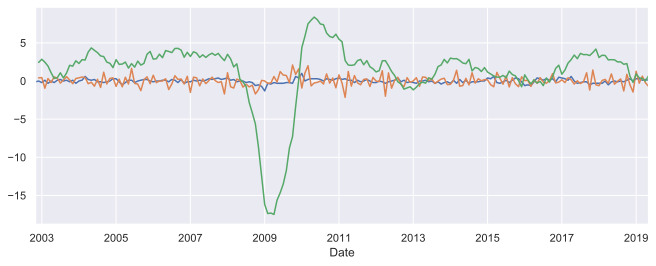

In [55]:
# ADF Test
merge5_diff = merge5.copy()

[index_remove5,merge5_differenced]=ADF_Test(merge5_diff)
index_remove5
merge5_differenced

#### 5.2.1 Forecast the spread for [SP500-ACWI ex USA]

In [56]:
# Grangers Causation Test
[causation_matrix,index_remove,merge5_tested] = causation_test(merge5_differenced,0)
causation_matrix
index_remove
merge5_tested

            SP500-ACWI ex USA      PPI_Euro  retail_trade  industry_production
Date                                                                          
2002-12-01          -2.929204  0.000000e+00       0.40752              2.44371
2003-01-01           0.803645 -2.000000e-01       0.44973              2.85048
2003-02-01           0.351309  1.000000e-01      -0.94614              2.46994
2003-03-01           2.863060 -3.000000e-01       0.32807              1.96518
2003-04-01          -1.315927  0.000000e+00      -0.20729              1.09203
2003-05-01          -1.130339 -2.000000e-01       0.54154              0.33580
2003-06-01          -1.549900  1.000000e-01       0.38748              0.42996
2003-07-01          -1.003121  2.000000e-01      -0.26757              1.07355
2003-08-01          -1.146842  1.421085e-14       0.12580              0.40083
2003-09-01          -3.943516  1.000000e-01       0.57419              1.05044
2003-10-01          -0.923415 -1.000000e-01       0.

SP500-ACWI ex USA_x  PPI_Euro_x  retail_trade_x  \
SP500-ACWI ex USA_y                 1.0000      0.6262          0.5382   
PPI_Euro_y                          0.0493      1.0000          0.0005   
retail_trade_y                      0.0002      0.0000          1.0000   
industry_production_y               0.0000      0.0001          0.0000   

                       industry_production_x  
SP500-ACWI ex USA_y                   0.2900  
PPI_Euro_y                            0.0002  
retail_trade_y                        0.0000  
industry_production_y                 1.0000

[2, 3, 4]

SP500-ACWI ex USA  SP500-EAFE
Date                                     
2002-12-01          -2.929204   -2.802643
2003-01-01           0.803645    1.484666
2003-02-01           0.351309    0.606749
2003-03-01           2.863060    2.816638
2003-04-01          -1.315927   -1.557381
2003-05-01          -1.130339   -0.918217
2003-06-01          -1.549900   -1.262002
2003-07-01          -1.003121   -0.782466
2003-08-01          -1.146842   -0.614686
2003-09-01          -3.943516   -4.237714
2003-10-01          -0.923415   -0.695939
2003-11-01          -1.431610   -1.488539
2003-12-01          -2.399238   -2.570411
2004-01-01           0.134022    0.308726
2004-02-01          -1.278922   -1.068684
2004-03-01          -2.223979   -2.210518
2004-04-01           1.539649    0.594733
2004-05-01           0.972669    0.865415
2004-06-01          -0.321996   -0.384448
2004-07-01          -0.511821   -0.190041
2004-08-01          -0.543693   -0.212167
2004-09-01          -2.217515   -1.647963
2004-10-01          -2.021052   -1.961425
2004-11-01          -2.898286   -2.821222
2004-12-01          -1.002109   -1.098537
2005-01-01          -0.809420   -0.709824
2005-02-01          -2.916108   -2.357492
2005-03-01           0.857202    0.614029
2005-04-01           0.566197    0.347771
2005-05-01           2.420680    2.902898
...                       ...         ...
2016-12-01          -0.722398   -1.558560
2017-01-01          -1.708501   -1.086877
2017-02-01           2.070558    2.232490
2017-03-01          -2.542670   -2.754588
2017-04-01          -1.212849   -1.607647
2017-05-01          -2.042723   -2.453668
2017-06-01           0.170341    0.657243
2017-07-01          -1.703286   -0.927366
2017-08-01          -0.467001    0.092321
2017-09-01           0.072564   -0.545699
2017-10-01           0.330533    0.687503
2017-11-01           1.960533    1.726092
2017-12-01          -1.232209   -0.614011
2018-01-01           0.045902    0.571539
2018-02-01           0.857244    0.646025
2018-03-01          -0.945594   -0.906450
2018-04-01          -1.312700   -1.986079
2018-05-01           4.473996    4.411265
2018-06-01           2.380531    1.712320
2018-07-01           1.175291    1.107076
2018-08-01           5.096612    4.931576
2018-09-01          -0.025948   -0.435625
2018-10-01           1.290743    1.100899
2018-11-01           0.828146    1.896268
2018-12-01          -4.994920   -4.650366
2019-01-01           0.290283    1.209142
2019-02-01           0.994662    0.412375
2019-03-01           1.182602    1.147955
2019-04-01           1.248543    1.083302
2019-05-01          -1.287370   -1.882346

[198 rows x 2 columns]

In [ ]:
# Train Set = 95%
[df5_train,df5_test,df5_forecast] = VAR_Model(merge5_tested,0,0.05)
df5_forecast 
df5_test

In [ ]:
forecast_plot(df5_forecast,df5_train,df5_test,95)

#### 5.2.2 Forecast the spread for [SP500-EAFE]

In [57]:
[causation_matrix,index_remove,merge5_tested_EAFE] = causation_test(merge5_differenced,1)
causation_matrix
index_remove
merge5_tested_EAFE

            SP500-EAFE      PPI_Euro  retail_trade  industry_production
Date                                                                   
2002-12-01   -2.802643  0.000000e+00       0.40752              2.44371
2003-01-01    1.484666 -2.000000e-01       0.44973              2.85048
2003-02-01    0.606749  1.000000e-01      -0.94614              2.46994
2003-03-01    2.816638 -3.000000e-01       0.32807              1.96518
2003-04-01   -1.557381  0.000000e+00      -0.20729              1.09203
2003-05-01   -0.918217 -2.000000e-01       0.54154              0.33580
2003-06-01   -1.262002  1.000000e-01       0.38748              0.42996
2003-07-01   -0.782466  2.000000e-01      -0.26757              1.07355
2003-08-01   -0.614686  1.421085e-14       0.12580              0.40083
2003-09-01   -4.237714  1.000000e-01       0.57419              1.05044
2003-10-01   -0.695939 -1.000000e-01       0.13473              2.06259
2003-11-01   -1.488539  1.000000e-01      -0.35074              

SP500-EAFE_x  PPI_Euro_x  retail_trade_x  \
SP500-EAFE_y                 1.0000      0.5066          0.4303   
PPI_Euro_y                   0.2334      1.0000          0.0005   
retail_trade_y               0.0019      0.0000          1.0000   
industry_production_y        0.0008      0.0001          0.0000   

                       industry_production_x  
SP500-EAFE_y                          0.2942  
PPI_Euro_y                            0.0002  
retail_trade_y                        0.0000  
industry_production_y                 1.0000

[2, 3, 4]

SP500-ACWI ex USA  SP500-EAFE
Date                                     
2002-12-01          -2.929204   -2.802643
2003-01-01           0.803645    1.484666
2003-02-01           0.351309    0.606749
2003-03-01           2.863060    2.816638
2003-04-01          -1.315927   -1.557381
2003-05-01          -1.130339   -0.918217
2003-06-01          -1.549900   -1.262002
2003-07-01          -1.003121   -0.782466
2003-08-01          -1.146842   -0.614686
2003-09-01          -3.943516   -4.237714
2003-10-01          -0.923415   -0.695939
2003-11-01          -1.431610   -1.488539
2003-12-01          -2.399238   -2.570411
2004-01-01           0.134022    0.308726
2004-02-01          -1.278922   -1.068684
2004-03-01          -2.223979   -2.210518
2004-04-01           1.539649    0.594733
2004-05-01           0.972669    0.865415
2004-06-01          -0.321996   -0.384448
2004-07-01          -0.511821   -0.190041
2004-08-01          -0.543693   -0.212167
2004-09-01          -2.217515   -1.647963
2004-10-01          -2.021052   -1.961425
2004-11-01          -2.898286   -2.821222
2004-12-01          -1.002109   -1.098537
2005-01-01          -0.809420   -0.709824
2005-02-01          -2.916108   -2.357492
2005-03-01           0.857202    0.614029
2005-04-01           0.566197    0.347771
2005-05-01           2.420680    2.902898
...                       ...         ...
2016-12-01          -0.722398   -1.558560
2017-01-01          -1.708501   -1.086877
2017-02-01           2.070558    2.232490
2017-03-01          -2.542670   -2.754588
2017-04-01          -1.212849   -1.607647
2017-05-01          -2.042723   -2.453668
2017-06-01           0.170341    0.657243
2017-07-01          -1.703286   -0.927366
2017-08-01          -0.467001    0.092321
2017-09-01           0.072564   -0.545699
2017-10-01           0.330533    0.687503
2017-11-01           1.960533    1.726092
2017-12-01          -1.232209   -0.614011
2018-01-01           0.045902    0.571539
2018-02-01           0.857244    0.646025
2018-03-01          -0.945594   -0.906450
2018-04-01          -1.312700   -1.986079
2018-05-01           4.473996    4.411265
2018-06-01           2.380531    1.712320
2018-07-01           1.175291    1.107076
2018-08-01           5.096612    4.931576
2018-09-01          -0.025948   -0.435625
2018-10-01           1.290743    1.100899
2018-11-01           0.828146    1.896268
2018-12-01          -4.994920   -4.650366
2019-01-01           0.290283    1.209142
2019-02-01           0.994662    0.412375
2019-03-01           1.182602    1.147955
2019-04-01           1.248543    1.083302
2019-05-01          -1.287370   -1.882346

[198 rows x 2 columns]

In [58]:
# Train Set = 95%
[df5_train_EAFE,df5_test_EAFE,df5_forecast_EAFE] = VAR_Model(merge3_tested_EAFE,1,0.05)
df5_forecast_EAFE 
df5_test_EAFE

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     11:14:49
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                  -0.353048
Nobs:                     181.000    HQIC:                  -1.40374
Log likelihood:          -735.436    FPE:                   0.120867
AIC:                     -2.12017    Det(Omega_mle):       0.0720365
--------------------------------------------------------------------
Results for equation SP500-EAFE
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.019414         0.167657           -0.116           0.908
L1.SP500-EAFE              0.075161         0.080793            0.930           0.352
L1.A191RP1Q027SBEA         0.057452

SP500-EAFE_forecast  A191RP1Q027SBEA_forecast  \
Date                                                        
2018-07-01            -0.506153                  1.395093   
2018-08-01             0.723979                  0.297371   
2018-09-01             0.354885                  1.273724   
2018-10-01             0.140198                  1.121703   
2018-11-01            -0.076593                  0.477593   
2018-12-01            -0.360297                 -0.196949   
2019-01-01            -0.078072                 -0.617962   
2019-02-01             0.047360                 -0.619553   
2019-03-01            -0.191844                 -0.508713   
2019-04-01            -0.187404                 -0.815138   

            CPALTT01USQ657N_forecast  FEDFUNDS_forecast  
Date                                                     
2018-07-01                  0.258697           0.747159  
2018-08-01                  0.114773           0.644162  
2018-09-01                  0.263531           0.604578  
2018-10-01                 -0.017671           0.568296  
2018-11-01                 -0.131857           0.473494  
2018-12-01                 -0.149748           0.422604  
2019-01-01                 -0.114891           0.376066  
2019-02-01                 -0.057052           0.334358  
2019-03-01                 -0.030169           0.302862  
2019-04-01                 -0.038303           0.252708

SP500-EAFE  A191RP1Q027SBEA  CPALTT01USQ657N  FEDFUNDS
Date                                                              
2018-07-01    1.107076             -0.6        -0.069348      0.76
2018-08-01    4.931576             -0.6        -0.069348      0.75
2018-09-01   -0.435625             -0.6        -0.069348      0.80
2018-10-01    1.100899             -3.5        -0.428124      1.04
2018-11-01    1.896268             -3.5        -0.428124      1.04
2018-12-01   -4.650366             -3.5        -0.428124      0.97
2019-01-01    1.209142             -1.1        -0.551002      0.99
2019-02-01    0.412375             -1.1        -0.551002      0.98
2019-03-01    1.147955             -1.1        -0.551002      0.90
2019-04-01    1.083302             -2.5         0.165438      0.73

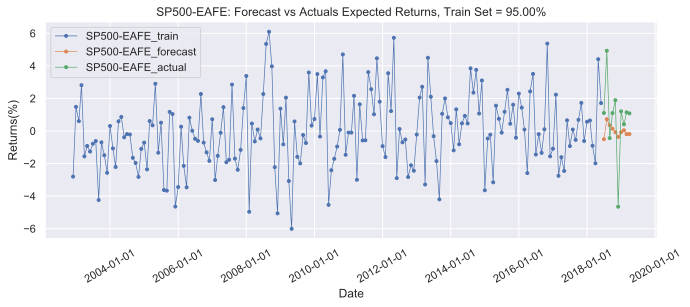

In [59]:
forecast_plot(df5_forecast_EAFE,df5_train_EAFE,df5_test_EAFE,95)

### 5.3 Lagging Indicators

* Real GDP Growth (Advanced)
* Real GDP Growth (Emerging Market)
* Inflation Rate (Advanced)
* Inflation Rate (Emerging Market)
* Current account balance percent of GDP (Emerging Market)
* Current account balance percent of GDP (Advanced)
* Unemployment rate (OECD Total)
* Youth Unemployment Rate for Developing Countries in East Asia and Pacific (SLUEM1524ZSEAP)
* General government net lending/borrowing Percent of GDP (Emerging Market)
* General government gross debt Percent of GDP (Adanced)

In [60]:
GDP = pd.read_excel("IMF_GDP.xlsx")
Inflation = pd.read_excel("IMF_Inflation.xlsx")
Balance = pd.read_excel("IMF_Current.xlsx")
NetBL = pd.read_excel("IMF_NetBL.xlsx")
Debt = pd.read_excel("IMF_Debt.xlsx")

In [61]:
def IMF_Data(df):
    # Emerging Economies
    col_name = df.columns[0]
    df_Emerging = df[df[col_name]=='Emerging market and developing economies'].T
    df_Emerging = df_Emerging.reset_index().iloc[1:,:]
    col1 = df_Emerging.columns[0]
    col2 = df_Emerging.columns[1]
    col_name1 = col_name+"_Emerging"
    df_Emerging = df_Emerging.rename(columns = {col1:'Date',col2:col_name1})
    df_Emerging = df_Emerging[df_Emerging[col_name1]!='no data'].reset_index(drop=True)
    df_Emerging['Date'] = pd.to_datetime(df_Emerging['Date'],format='%Y')
    df_Emerging = df_Emerging.set_index('Date').asfreq(freq='MS',method='ffill').astype({col_name1: 'float64'})
    df_Emerging = df_Emerging.diff(periods=12).dropna()
    df_Emerging.plot()
    
    # Advanced Economies
    df_Advanced = df[df[col_name]=='Advanced economies'].T
    df_Advanced = df_Advanced.reset_index().iloc[1:,:]
    col3 = df_Advanced.columns[1]
    col_name2 = col_name+'_Advanced'
    df_Advanced = df_Advanced.rename(columns = {col1:'Date',col3:col_name2})
    df_Advanced = df_Advanced[df_Advanced[col_name2]!='no data'].reset_index(drop=True)
    df_Advanced['Date'] = pd.to_datetime(df_Advanced['Date'],format='%Y')
    df_Advanced = df_Advanced.set_index('Date').asfreq(freq='MS',method='ffill').astype({col_name2: 'float64'})
    df_Advanced = df_Advanced.diff(periods=12).dropna()
    df_Advanced.plot()
    return df_Emerging,df_Advanced

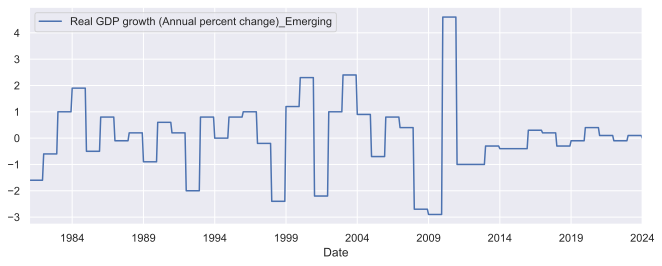

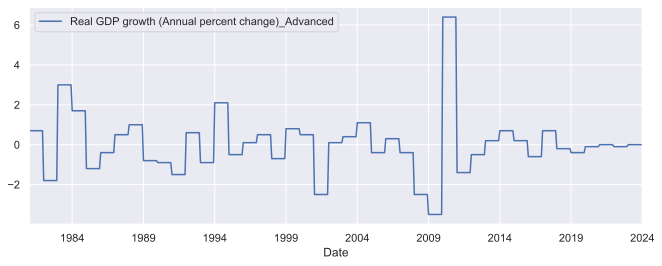

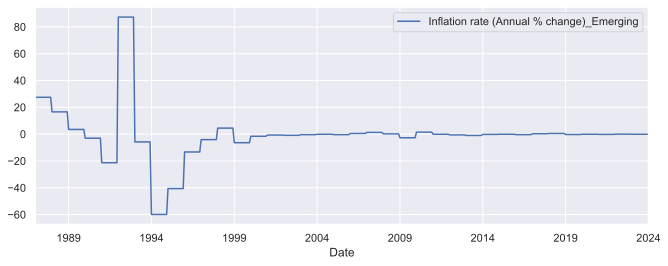

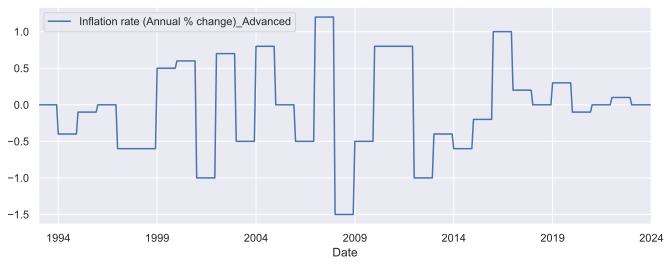

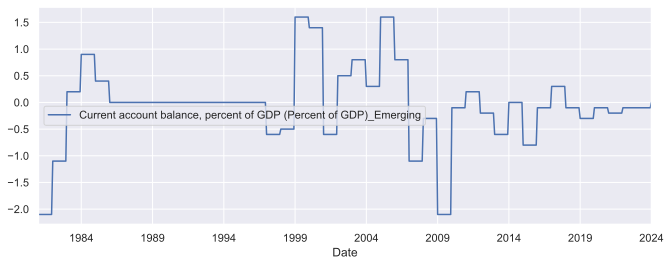

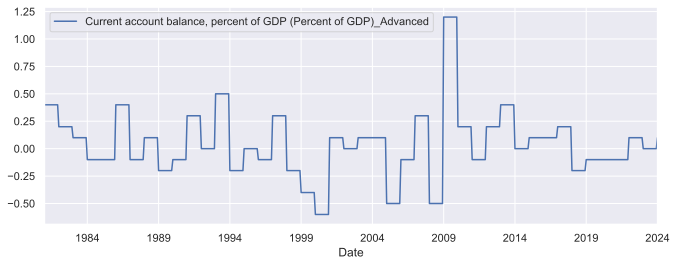

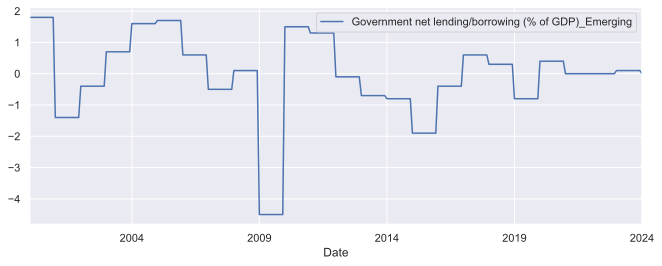

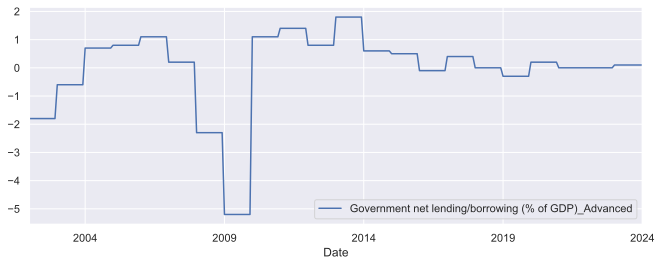

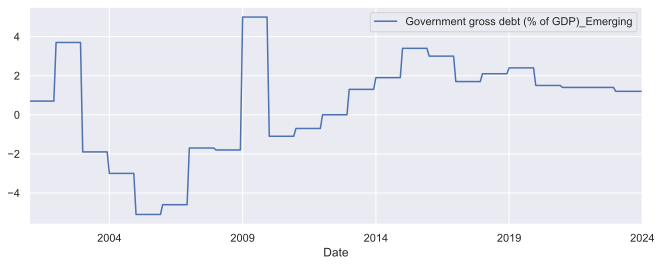

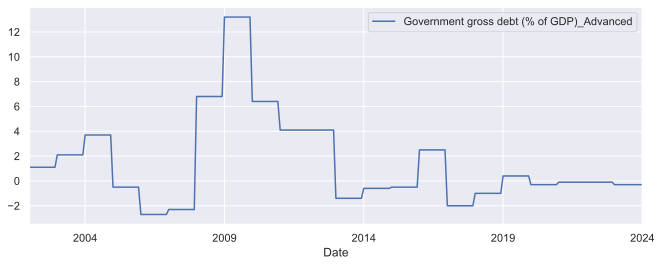

In [62]:
[GDP_Emerging,GDP_Advanced] = IMF_Data(GDP)
[Inflation_Emerging,Inflation_Advanced] = IMF_Data(Inflation)
[Balance_Emerging,Balance_Advanced] = IMF_Data(Balance)
[NetBL_Emerging,NetBL_Advanced] = IMF_Data(NetBL)
[Debt_Emerging,Debt_Advanced] = IMF_Data(Debt)

In [63]:
merge6 = pd.concat([spread,GDP_Emerging,GDP_Advanced,Inflation_Emerging,Inflation_Advanced,
                     Balance_Emerging,Balance_Advanced,NetBL_Emerging,NetBL_Advanced,
                     Debt_Emerging,Debt_Advanced],join='inner',axis=1)
merge6

SP500-ACWI ex USA  SP500-EAFE  \
Date                                        
2002-10-01           3.073344    3.056363   
2002-11-01           0.865385    1.111491   
2002-12-01          -2.929204   -2.802643   
2003-01-01           0.803645    1.484666   
2003-02-01           0.351309    0.606749   
2003-03-01           2.863060    2.816638   
2003-04-01          -1.315927   -1.557381   
2003-05-01          -1.130339   -0.918217   
2003-06-01          -1.549900   -1.262002   
2003-07-01          -1.003121   -0.782466   
2003-08-01          -1.146842   -0.614686   
2003-09-01          -3.943516   -4.237714   
2003-10-01          -0.923415   -0.695939   
2003-11-01          -1.431610   -1.488539   
2003-12-01          -2.399238   -2.570411   
2004-01-01           0.134022    0.308726   
2004-02-01          -1.278922   -1.068684   
2004-03-01          -2.223979   -2.210518   
2004-04-01           1.539649    0.594733   
2004-05-01           0.972669    0.865415   
2004-06-01          -0.321996   -0.384448   
2004-07-01          -0.511821   -0.190041   
2004-08-01          -0.543693   -0.212167   
2004-09-01          -2.217515   -1.647963   
2004-10-01          -2.021052   -1.961425   
2004-11-01          -2.898286   -2.821222   
2004-12-01          -1.002109   -1.098537   
2005-01-01          -0.809420   -0.709824   
2005-02-01          -2.916108   -2.357492   
2005-03-01           0.857202    0.614029   
...                       ...         ...   
2017-02-01           2.070558    2.232490   
2017-03-01          -2.542670   -2.754588   
2017-04-01          -1.212849   -1.607647   
2017-05-01          -2.042723   -2.453668   
2017-06-01           0.170341    0.657243   
2017-07-01          -1.703286   -0.927366   
2017-08-01          -0.467001    0.092321   
2017-09-01           0.072564   -0.545699   
2017-10-01           0.330533    0.687503   
2017-11-01           1.960533    1.726092   
2017-12-01          -1.232209   -0.614011   
2018-01-01           0.045902    0.571539   
2018-02-01           0.857244    0.646025   
2018-03-01          -0.945594   -0.906450   
2018-04-01          -1.312700   -1.986079   
2018-05-01           4.473996    4.411265   
2018-06-01           2.380531    1.712320   
2018-07-01           1.175291    1.107076   
2018-08-01           5.096612    4.931576   
2018-09-01          -0.025948   -0.435625   
2018-10-01           1.290743    1.100899   
2018-11-01           0.828146    1.896268   
2018-12-01          -4.994920   -4.650366   
2019-01-01           0.290283    1.209142   
2019-02-01           0.994662    0.412375   
2019-03-01           1.182602    1.147955   
2019-04-01           1.248543    1.083302   
2019-05-01          -1.287370   -1.882346   
2019-06-01           0.818567    0.902598   
2019-07-01           2.521947    2.582091   

            Real GDP growth (Annual percent change)_Emerging  \
Date                                                           
2002-10-01                                               1.0   
2002-11-01                                               1.0   
2002-12-01                                               1.0   
2003-01-01                                               2.4   
2003-02-01                                               2.4   
2003-03-01                                               2.4   
2003-04-01                                               2.4   
2003-05-01                                               2.4   
2003-06-01                                               2.4   
2003-07-01                                               2.4   
2003-08-01                                               2.4   
2003-09-01                                               2.4   
2003-10-01                                               2.4   
2003-11-01                                               2.4   
2003-12-01                                               2.4   
2004-01-01                                               0.9   
2004-02-01              

#### 5.3.1 Forecast the spread for [SP500-ACWI ex USA]

In [64]:
# Grangers Causation Test
[causation_matrix,index_remove,merge6_tested] = causation_test(merge6,0)
causation_matrix
index_remove
merge6_tested

            SP500-ACWI ex USA  \
Date                            
2002-10-01           3.073344   
2002-11-01           0.865385   
2002-12-01          -2.929204   
2003-01-01           0.803645   
2003-02-01           0.351309   
2003-03-01           2.863060   
2003-04-01          -1.315927   
2003-05-01          -1.130339   
2003-06-01          -1.549900   
2003-07-01          -1.003121   
2003-08-01          -1.146842   
2003-09-01          -3.943516   
2003-10-01          -0.923415   
2003-11-01          -1.431610   
2003-12-01          -2.399238   
2004-01-01           0.134022   
2004-02-01          -1.278922   
2004-03-01          -2.223979   
2004-04-01           1.539649   
2004-05-01           0.972669   
2004-06-01          -0.321996   
2004-07-01          -0.511821   
2004-08-01          -0.543693   
2004-09-01          -2.217515   
2004-10-01          -2.021052   
2004-11-01          -2.898286   
2004-12-01          -1.002109   
2005-01-01          -0.809420   
2005-02-01

SP500-ACWI ex USA_x  \
SP500-ACWI ex USA_y                                              1.0000   
Real GDP growth (Annual percent change)_Emerging_y               0.0391   
Real GDP growth (Annual percent change)_Advanced_y               0.0310   
Inflation rate (Annual % change)_Emerging_y                      0.0003   
Inflation rate (Annual % change)_Advanced_y                      0.1237   
Current account balance, percent of GDP (Percen...               0.0015   
Current account balance, percent of GDP (Percen...               0.0000   
Government net lending/borrowing (% of GDP)_Eme...               0.0000   
Government net lending/borrowing (% of GDP)_Adv...               0.0475   
Government gross debt (% of GDP)_Emerging_y                      0.0000   
Government gross debt (% of GDP)_Advanced_y                      0.0910   

                                                    Real GDP growth (Annual percent change)_Emerging_x  \
SP500-ACWI ex USA_y                                                                            0.0616    
Real GDP growth (Annual percent change)_Emerging_y                                             1.0000    
Real GDP growth (Annual percent change)_Advanced_y                                             0.7748    
Inflation rate (Annual % change)_Emerging_y                                                    0.0155    
Inflation rate (Annual % change)_Advanced_y                                                    0.0513    
Current account balance, percent of GDP (Percen...                                             0.2382    
Current account balance, percent of GDP (Percen...                                             0.1962    
Government net lending/borrowing (% of GDP)_Eme...                                             0.0735    
Government net lending/borrowing (% of GDP)_Adv...                                             0.3538    
Government gross debt (% of GDP)_Emerging_y                                                    0.2210    
Government gross debt (% of GDP)_Advanced_y                                                    0.6354    

                                                    Real GDP growth (Annual percent change)_Advanced_x  \
SP500-ACWI ex USA_y                                                                            0.1104    
Real GDP growth (Annual percent change)_Emerging_y                                             0.4474    
Real GDP growth (Annual percent change)_Advanced_y                                             1.0000    
Inflation rate (Annual % change)_Emerging_y                                                    0.0000    
Inflation rate (Annual % change)_Advanced_y                                                    0.3030    
Current account balance, percent of GDP (Percen...                                             0.3953    
Current account balance, percent of GDP (Percen...                                             0.2326    
Government net lending/borrowing (% of GDP)_Eme...                                             0.2944    
Government net lending/borrowing (% of GDP)_Adv...                                             0.4020    
Government gross debt (% of GDP)_Emerging_y                                                    0.7646    
Government gross debt (% of GDP)_Advanced_y                                                    0.5086    

                                                    Inflation rate (Annual % change)_Emerging_x  \
SP500-ACWI ex USA_y                                                                      0.0221   
Real GDP growth (Annual percent change)_Emerging_y                                       0.0000   
Real GDP growth (Annual percent change)_Advanced_y                                       0.0000   
Inflation rate (Annual % change)_Emerging_y                                              1.0000   
Inflation rate (Annual % change)_Advanced_y                                              0.9191   
Current acc

[2, 3, 6]

SP500-ACWI ex USA  SP500-EAFE  \
Date                                        
2002-10-01           3.073344    3.056363   
2002-11-01           0.865385    1.111491   
2002-12-01          -2.929204   -2.802643   
2003-01-01           0.803645    1.484666   
2003-02-01           0.351309    0.606749   
2003-03-01           2.863060    2.816638   
2003-04-01          -1.315927   -1.557381   
2003-05-01          -1.130339   -0.918217   
2003-06-01          -1.549900   -1.262002   
2003-07-01          -1.003121   -0.782466   
2003-08-01          -1.146842   -0.614686   
2003-09-01          -3.943516   -4.237714   
2003-10-01          -0.923415   -0.695939   
2003-11-01          -1.431610   -1.488539   
2003-12-01          -2.399238   -2.570411   
2004-01-01           0.134022    0.308726   
2004-02-01          -1.278922   -1.068684   
2004-03-01          -2.223979   -2.210518   
2004-04-01           1.539649    0.594733   
2004-05-01           0.972669    0.865415   
2004-06-01          -0.321996   -0.384448   
2004-07-01          -0.511821   -0.190041   
2004-08-01          -0.543693   -0.212167   
2004-09-01          -2.217515   -1.647963   
2004-10-01          -2.021052   -1.961425   
2004-11-01          -2.898286   -2.821222   
2004-12-01          -1.002109   -1.098537   
2005-01-01          -0.809420   -0.709824   
2005-02-01          -2.916108   -2.357492   
2005-03-01           0.857202    0.614029   
...                       ...         ...   
2017-02-01           2.070558    2.232490   
2017-03-01          -2.542670   -2.754588   
2017-04-01          -1.212849   -1.607647   
2017-05-01          -2.042723   -2.453668   
2017-06-01           0.170341    0.657243   
2017-07-01          -1.703286   -0.927366   
2017-08-01          -0.467001    0.092321   
2017-09-01           0.072564   -0.545699   
2017-10-01           0.330533    0.687503   
2017-11-01           1.960533    1.726092   
2017-12-01          -1.232209   -0.614011   
2018-01-01           0.045902    0.571539   
2018-02-01           0.857244    0.646025   
2018-03-01          -0.945594   -0.906450   
2018-04-01          -1.312700   -1.986079   
2018-05-01           4.473996    4.411265   
2018-06-01           2.380531    1.712320   
2018-07-01           1.175291    1.107076   
2018-08-01           5.096612    4.931576   
2018-09-01          -0.025948   -0.435625   
2018-10-01           1.290743    1.100899   
2018-11-01           0.828146    1.896268   
2018-12-01          -4.994920   -4.650366   
2019-01-01           0.290283    1.209142   
2019-02-01           0.994662    0.412375   
2019-03-01           1.182602    1.147955   
2019-04-01           1.248543    1.083302   
2019-05-01          -1.287370   -1.882346   
2019-06-01           0.818567    0.902598   
2019-07-01           2.521947    2.582091   

            Inflation rate (Annual % change)_Emerging  \
Date                                                    
2002-10-01                                       -0.9   
2002-11-01                                       -0.9   
2002-12-01                                       -0.9   
2003-01-01                                       -0.4   
2003-02-01                                       -0.4   
2003-03-01                                       -0.4   
2003-04-01                                       -0.4   
2003-05-01                                       -0.4   
2003-06-01                                       -0.4   
2003-07-01                                       -0.4   
2003-08-01                                       -0.4   
2003-09-01                                       -0.4   
2003-10-01                                       -0.4   
2003-11-01                                       -0.4   
2003-12-01                                       -0.4   
2004-01-01                                       -0.1   
2004-02-01                                       -0.1   
2004-03-01                                       -0.1   
2004-04-01                          

In [65]:
# Train Set = 95%
[df6_train,df6_test,df6_forecast] = VAR_Model(merge6_tested,0,0.05)
df6_forecast 
df6_test

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     11:16:20
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -13.4833
Nobs:                     190.000    HQIC:                  -14.2153
Log likelihood:          -686.977    FPE:                4.07502e-07
AIC:                     -14.7138    Det(Omega_mle):     2.81406e-07
--------------------------------------------------------------------
Results for equation SP500-ACWI ex USA
                                                                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------------------
const                                                                       -0.041727         0.2175

SP500-ACWI ex USA_forecast  \
Date                                     
2018-09-01                    1.179427   
2018-10-01                    0.806764   
2018-11-01                    0.724456   
2018-12-01                    0.670200   
2019-01-01                    0.622515   
2019-02-01                    0.579324   
2019-03-01                    0.540129   
2019-04-01                    0.504586   
2019-05-01                    0.472381   
2019-06-01                    0.443225   
2019-07-01                    0.416849   

            Inflation rate (Annual % change)_Emerging_forecast  \
Date                                                             
2018-09-01                                           0.490028    
2018-10-01                                           0.417730    
2018-11-01                                           0.349440    
2018-12-01                                           0.289413    
2019-01-01                                           0.237022    
2019-02-01                                           0.191358    
2019-03-01                                           0.151588    
2019-04-01                                           0.116969    
2019-05-01                                           0.086849    
2019-06-01                                           0.060649    
2019-07-01                                           0.037862    

            Inflation rate (Annual % change)_Advanced_forecast  \
Date                                                             
2018-09-01                                          -0.081971    
2018-10-01                                          -0.113428    
2018-11-01                                          -0.135865    
2018-12-01                                          -0.153281    
2019-01-01                                          -0.166585    
2019-02-01                                          -0.176375    
2019-03-01                                          -0.183164    
2019-04-01                                          -0.187406    
2019-05-01                                          -0.189499    
2019-06-01                                          -0.189798    
2019-07-01                                          -0.188609    

            Current account balance, percent of GDP (Percent of GDP)_Advanced_forecast  \
Date                                                                                     
2018-09-01                                          -0.226526                            
2018-10-01                                          -0.193120                            
2018-11-01                                          -0.158168                            
2018-12-01                                          -0.126133                            
2019-01-01                                          -0.097149                            
2019-02-01                                          -0.071008                            
2019-03-01                                          -0.047488                            
2019-04-01                                          -0.026375                            
2019-05-01                                          -0.007468                            
2019-06-01                                           0.009423                            
2019-07-01                                           0.024472                            

            Government net lending/borrowing (% of GDP)_Emerging_forecast  \
Date                                                                        
2018-09-01                                           0.340474               
2018-10-01                                           0.260235               
2018-11-01                                           0.181676               
2018-12-01                                           0.113434               
2019-01-01                                           0.055099               
2019-02-01                           

SP500-ACWI ex USA  Inflation rate (Annual % change)_Emerging  \
Date                                                                       
2018-09-01          -0.025948                                        0.5   
2018-10-01           1.290743                                        0.5   
2018-11-01           0.828146                                        0.5   
2018-12-01          -4.994920                                        0.5   
2019-01-01           0.290283                                       -0.3   
2019-02-01           0.994662                                       -0.3   
2019-03-01           1.182602                                       -0.3   
2019-04-01           1.248543                                       -0.3   
2019-05-01          -1.287370                                       -0.3   
2019-06-01           0.818567                                       -0.3   
2019-07-01           2.521947                                       -0.3   

            Inflation rate (Annual % change)_Advanced  \
Date                                                    
2018-09-01                                        0.0   
2018-10-01                                        0.0   
2018-11-01                                        0.0   
2018-12-01                                        0.0   
2019-01-01                                        0.3   
2019-02-01                                        0.3   
2019-03-01                                        0.3   
2019-04-01                                        0.3   
2019-05-01                                        0.3   
2019-06-01                                        0.3   
2019-07-01                                        0.3   

            Current account balance, percent of GDP (Percent of GDP)_Advanced  \
Date                                                                            
2018-09-01                                               -0.2                   
2018-10-01                                               -0.2                   
2018-11-01                                               -0.2                   
2018-12-01                                               -0.2                   
2019-01-01                                               -0.1                   
2019-02-01                                               -0.1                   
2019-03-01                                               -0.1                   
2019-04-01                                               -0.1                   
2019-05-01                                               -0.1                   
2019-06-01                                               -0.1                   
2019-07-01                                               -0.1                   

            Government net lending/borrowing (% of GDP)_Emerging  \
Date                                                               
2018-09-01                                                0.3      
2018-10-01                                                0.3      
2018-11-01                                                0.3      
2018-12-01                                                0.3      
2019-01-01                                               -0.8      
2019-02-01                                               -0.8      
2019-03-01                                               -0.8      
2019-04-01                                               -0.8      
2019-05-01                                               -0.8      
2019-06-01                                               -0.8      
2019-07-01                                               -0.8      

            Government net lending/borrowing (% of GDP)_Advanced  \
Date                                                               
2018-09-01                                                0.0      
2018-10-01                                                0.0      
2018-11-01                                                0.0      
20

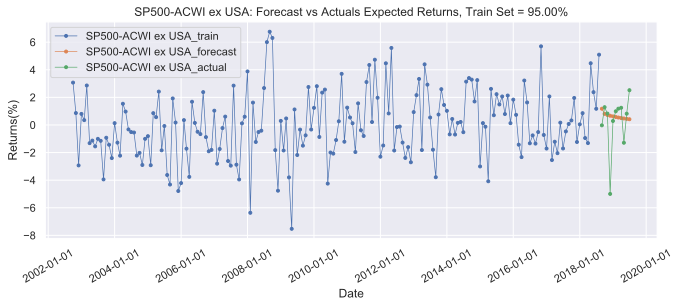

In [66]:
forecast_plot(df6_forecast,df6_train,df6_test,95)

#### 5.3.2 Forecast the spread for [SP500-EAFE]

In [67]:
[causation_matrix,index_remove,merge6_tested_EAFE] = causation_test(merge6,1)
causation_matrix
index_remove
merge6_tested_EAFE

            SP500-EAFE  Real GDP growth (Annual percent change)_Emerging  \
Date                                                                       
2002-10-01    3.056363                                               1.0   
2002-11-01    1.111491                                               1.0   
2002-12-01   -2.802643                                               1.0   
2003-01-01    1.484666                                               2.4   
2003-02-01    0.606749                                               2.4   
2003-03-01    2.816638                                               2.4   
2003-04-01   -1.557381                                               2.4   
2003-05-01   -0.918217                                               2.4   
2003-06-01   -1.262002                                               2.4   
2003-07-01   -0.782466                                               2.4   
2003-08-01   -0.614686                                               2.4   
2003-09-01  

SP500-EAFE_x  \
SP500-EAFE_y                                              1.0000   
Real GDP growth (Annual percent change)_Emerging_y        0.0359   
Real GDP growth (Annual percent change)_Advanced_y        0.0223   
Inflation rate (Annual % change)_Emerging_y               0.0002   
Inflation rate (Annual % change)_Advanced_y               0.2327   
Current account balance, percent of GDP (Percen...        0.0106   
Current account balance, percent of GDP (Percen...        0.0003   
Government net lending/borrowing (% of GDP)_Eme...        0.0000   
Government net lending/borrowing (% of GDP)_Adv...        0.0194   
Government gross debt (% of GDP)_Emerging_y               0.0000   
Government gross debt (% of GDP)_Advanced_y               0.0191   

                                                    Real GDP growth (Annual percent change)_Emerging_x  \
SP500-EAFE_y                                                                                   0.0233    
Real GDP growth (Annual percent change)_Emerging_y                                             1.0000    
Real GDP growth (Annual percent change)_Advanced_y                                             0.7748    
Inflation rate (Annual % change)_Emerging_y                                                    0.0155    
Inflation rate (Annual % change)_Advanced_y                                                    0.0513    
Current account balance, percent of GDP (Percen...                                             0.2382    
Current account balance, percent of GDP (Percen...                                             0.1962    
Government net lending/borrowing (% of GDP)_Eme...                                             0.0735    
Government net lending/borrowing (% of GDP)_Adv...                                             0.3538    
Government gross debt (% of GDP)_Emerging_y                                                    0.2210    
Government gross debt (% of GDP)_Advanced_y                                                    0.6354    

                                                    Real GDP growth (Annual percent change)_Advanced_x  \
SP500-EAFE_y                                                                                   0.0305    
Real GDP growth (Annual percent change)_Emerging_y                                             0.4474    
Real GDP growth (Annual percent change)_Advanced_y                                             1.0000    
Inflation rate (Annual % change)_Emerging_y                                                    0.0000    
Inflation rate (Annual % change)_Advanced_y                                                    0.3030    
Current account balance, percent of GDP (Percen...                                             0.3953    
Current account balance, percent of GDP (Percen...                                             0.2326    
Government net lending/borrowing (% of GDP)_Eme...                                             0.2944    
Government net lending/borrowing (% of GDP)_Adv...                                             0.4020    
Government gross debt (% of GDP)_Emerging_y                                                    0.7646    
Government gross debt (% of GDP)_Advanced_y                                                    0.5086    

                                                    Inflation rate (Annual % change)_Emerging_x  \
SP500-EAFE_y                                                                             0.0114   
Real GDP growth (Annual percent change)_Emerging_y                                       0.0000   
Real GDP growth (Annual percent change)_Advanced_y                                       0.0000   
Inflation rate (Annual % change)_Emerging_y                                              1.0000   
Inflation rate (Annual % change)_Advanced_y                                              0.9191   
Current account balance, percent of GDP (Percen...                                       0.4311

[6]

SP500-ACWI ex USA  SP500-EAFE  \
Date                                        
2002-10-01           3.073344    3.056363   
2002-11-01           0.865385    1.111491   
2002-12-01          -2.929204   -2.802643   
2003-01-01           0.803645    1.484666   
2003-02-01           0.351309    0.606749   
2003-03-01           2.863060    2.816638   
2003-04-01          -1.315927   -1.557381   
2003-05-01          -1.130339   -0.918217   
2003-06-01          -1.549900   -1.262002   
2003-07-01          -1.003121   -0.782466   
2003-08-01          -1.146842   -0.614686   
2003-09-01          -3.943516   -4.237714   
2003-10-01          -0.923415   -0.695939   
2003-11-01          -1.431610   -1.488539   
2003-12-01          -2.399238   -2.570411   
2004-01-01           0.134022    0.308726   
2004-02-01          -1.278922   -1.068684   
2004-03-01          -2.223979   -2.210518   
2004-04-01           1.539649    0.594733   
2004-05-01           0.972669    0.865415   
2004-06-01          -0.321996   -0.384448   
2004-07-01          -0.511821   -0.190041   
2004-08-01          -0.543693   -0.212167   
2004-09-01          -2.217515   -1.647963   
2004-10-01          -2.021052   -1.961425   
2004-11-01          -2.898286   -2.821222   
2004-12-01          -1.002109   -1.098537   
2005-01-01          -0.809420   -0.709824   
2005-02-01          -2.916108   -2.357492   
2005-03-01           0.857202    0.614029   
...                       ...         ...   
2017-02-01           2.070558    2.232490   
2017-03-01          -2.542670   -2.754588   
2017-04-01          -1.212849   -1.607647   
2017-05-01          -2.042723   -2.453668   
2017-06-01           0.170341    0.657243   
2017-07-01          -1.703286   -0.927366   
2017-08-01          -0.467001    0.092321   
2017-09-01           0.072564   -0.545699   
2017-10-01           0.330533    0.687503   
2017-11-01           1.960533    1.726092   
2017-12-01          -1.232209   -0.614011   
2018-01-01           0.045902    0.571539   
2018-02-01           0.857244    0.646025   
2018-03-01          -0.945594   -0.906450   
2018-04-01          -1.312700   -1.986079   
2018-05-01           4.473996    4.411265   
2018-06-01           2.380531    1.712320   
2018-07-01           1.175291    1.107076   
2018-08-01           5.096612    4.931576   
2018-09-01          -0.025948   -0.435625   
2018-10-01           1.290743    1.100899   
2018-11-01           0.828146    1.896268   
2018-12-01          -4.994920   -4.650366   
2019-01-01           0.290283    1.209142   
2019-02-01           0.994662    0.412375   
2019-03-01           1.182602    1.147955   
2019-04-01           1.248543    1.083302   
2019-05-01          -1.287370   -1.882346   
2019-06-01           0.818567    0.902598   
2019-07-01           2.521947    2.582091   

            Real GDP growth (Annual percent change)_Emerging  \
Date                                                           
2002-10-01                                               1.0   
2002-11-01                                               1.0   
2002-12-01                                               1.0   
2003-01-01                                               2.4   
2003-02-01                                               2.4   
2003-03-01                                               2.4   
2003-04-01                                               2.4   
2003-05-01                                               2.4   
2003-06-01                                               2.4   
2003-07-01                                               2.4   
2003-08-01                                               2.4   
2003-09-01                                               2.4   
2003-10-01                                               2.4   
2003-11-01                                               2.4   
2003-12-01                                               2.4   
2004-01-01                                               0.9   
2004-02-01              

In [68]:
# Train Set = 95%
[df6_train_EAFE,df6_test_EAFE,df6_forecast_EAFE] = VAR_Model(merge6_tested_EAFE,1,0.05)
df6_forecast_EAFE 
df6_test_EAFE

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2019
Time:                     11:17:08
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -17.4948
Nobs:                     190.000    HQIC:                  -18.6131
Log likelihood:          -745.393    FPE:                3.85716e-09
AIC:                     -19.3746    Det(Omega_mle):     2.19707e-09
--------------------------------------------------------------------
Results for equation SP500-EAFE
                                                                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------------------
const                                                                       -0.017721         0.217837     

SP500-EAFE_forecast  \
Date                              
2018-09-01             1.063548   
2018-10-01             0.839263   
2018-11-01             0.788636   
2018-12-01             0.748786   
2019-01-01             0.712015   
2019-02-01             0.677888   
2019-03-01             0.646289   
2019-04-01             0.617109   
2019-05-01             0.590226   
2019-06-01             0.565516   
2019-07-01             0.542850   

            Real GDP growth (Annual percent change)_Emerging_forecast  \
Date                                                                    
2018-09-01                                          -0.344748           
2018-10-01                                          -0.397477           
2018-11-01                                          -0.438114           
2018-12-01                                          -0.467361           
2019-01-01                                          -0.486752           
2019-02-01                                          -0.497717           
2019-03-01                                          -0.501550           
2019-04-01                                          -0.499412           
2019-05-01                                          -0.492337           
2019-06-01                                          -0.481245           
2019-07-01                                          -0.466950           

            Real GDP growth (Annual percent change)_Advanced_forecast  \
Date                                                                    
2018-09-01                                          -0.237490           
2018-10-01                                          -0.349280           
2018-11-01                                          -0.440305           
2018-12-01                                          -0.509317           
2019-01-01                                          -0.559151           
2019-02-01                                          -0.592543           
2019-03-01                                          -0.611948           
2019-04-01                                          -0.619556           
2019-05-01                                          -0.617309           
2019-06-01                                          -0.606924           
2019-07-01                                          -0.589914           

            Inflation rate (Annual % change)_Emerging_forecast  \
Date                                                             
2018-09-01                                           0.485787    
2018-10-01                                           0.401748    
2018-11-01                                           0.323143    
2018-12-01                                           0.252786    
2019-01-01                                           0.190122    
2019-02-01                                           0.134473    
2019-03-01                                           0.085190    
2019-04-01                                           0.041667    
2019-05-01                                           0.003341    
2019-06-01                                          -0.030314    
2019-07-01                                          -0.059780    

            Inflation rate (Annual % change)_Advanced_forecast  \
Date                                                             
2018-09-01                                          -0.098082    
2018-10-01                                          -0.140324    
2018-11-01                                          -0.173555    
2018-12-01                                          -0.200680    
2019-01-01                                          -0.222484    
2019-02-01                                          -0.239602    
2019-03-01                                          -0.252606    
2019-04-01                                          -0.262022    
2019-05-01                                          -0.268324    
2019-06-01                                          -0.271944    
2019-

SP500-EAFE  Real GDP growth (Annual percent change)_Emerging  \
Date                                                                       
2018-09-01   -0.435625                                              -0.3   
2018-10-01    1.100899                                              -0.3   
2018-11-01    1.896268                                              -0.3   
2018-12-01   -4.650366                                              -0.3   
2019-01-01    1.209142                                              -0.1   
2019-02-01    0.412375                                              -0.1   
2019-03-01    1.147955                                              -0.1   
2019-04-01    1.083302                                              -0.1   
2019-05-01   -1.882346                                              -0.1   
2019-06-01    0.902598                                              -0.1   
2019-07-01    2.582091                                              -0.1   

            Real GDP growth (Annual percent change)_Advanced  \
Date                                                           
2018-09-01                                              -0.2   
2018-10-01                                              -0.2   
2018-11-01                                              -0.2   
2018-12-01                                              -0.2   
2019-01-01                                              -0.4   
2019-02-01                                              -0.4   
2019-03-01                                              -0.4   
2019-04-01                                              -0.4   
2019-05-01                                              -0.4   
2019-06-01                                              -0.4   
2019-07-01                                              -0.4   

            Inflation rate (Annual % change)_Emerging  \
Date                                                    
2018-09-01                                        0.5   
2018-10-01                                        0.5   
2018-11-01                                        0.5   
2018-12-01                                        0.5   
2019-01-01                                       -0.3   
2019-02-01                                       -0.3   
2019-03-01                                       -0.3   
2019-04-01                                       -0.3   
2019-05-01                                       -0.3   
2019-06-01                                       -0.3   
2019-07-01                                       -0.3   

            Inflation rate (Annual % change)_Advanced  \
Date                                                    
2018-09-01                                        0.0   
2018-10-01                                        0.0   
2018-11-01                                        0.0   
2018-12-01                                        0.0   
2019-01-01                                        0.3   
2019-02-01                                        0.3   
2019-03-01                                        0.3   
2019-04-01                                        0.3   
2019-05-01                                        0.3   
2019-06-01                                        0.3   
2019-07-01                                        0.3   

            Current account balance, percent of GDP (Percent of GDP)_Advanced  \
Date                                                                            
2018-09-01                                               -0.2                   
2018-10-01                                               -0.2                   
2018-11-01                                               -0.2                   
2018-12-01                                               -0.2                   
2019-01-01                                               -0.1                   
2019-02-01                                               -0.1                   
2019-03-01                                               -

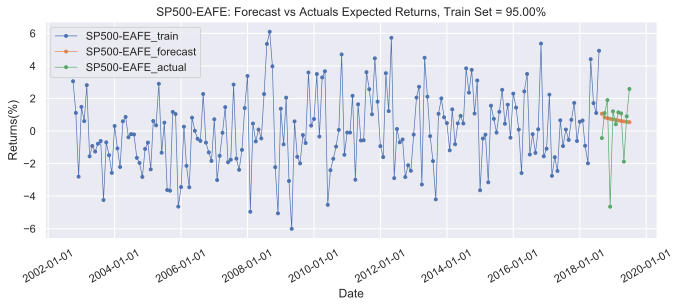

In [69]:
forecast_plot(df6_forecast_EAFE,df6_train_EAFE,df6_test_EAFE,95)